In [1]:

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import cProfile

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import SplineTransformer

import optuna
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

from sklearn.decomposition import PCA, KernelPCA
from sklearn.cluster import FeatureAgglomeration
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

import cv2 as cv2
from skimage.color import rgb2gray
from skimage.feature import hog, graycomatrix, graycoprops
from skimage.filters import gabor_kernel, gabor
from skimage import img_as_float32
from skimage.transform import resize

from joblib import Parallel, delayed

In [2]:
train = pd.read_csv('mnist_train.csv')
test  = pd.read_csv('mnist_test.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to 28x28
dtypes: int64(785)
memory usage: 359.3 MB


# Preprocessing

### One hot encoding

In [3]:
encoder = OneHotEncoder()

train_target = train['label']
test_target = test['label']

train_values = train.drop('label', axis=1)
test_values = test.drop('label', axis=1)

train_values = train_values.values.reshape(-1, 28, 28) 
test_values = test_values.values.reshape(-1, 28, 28)

train_target_encoded = encoder.fit_transform(train_target.values.reshape(-1, 1)).toarray()
test_target_encoded = encoder.transform(test_target.values.reshape(-1, 1)).toarray()

print("Shape of train_values:", train_values.shape)
print("Shape of train_target_encoded:", train_target_encoded.shape)

print("Shape of test_values:", test_values.shape)
print("Shape of test_target_encoded:", test_target_encoded.shape)

Shape of train_values: (60000, 28, 28)
Shape of train_target_encoded: (60000, 10)
Shape of test_values: (10000, 28, 28)
Shape of test_target_encoded: (10000, 10)


In [4]:
X_train = train_values
X_train = train_values.astype(np.uint8)

y_train_ENC = train_target_encoded
y_train = np.argmax(y_train_ENC, axis=1)

X_test = test_values
X_test = test_values.astype(np.uint8)

y_test_ENC = test_target_encoded
y_test = np.argmax(y_test_ENC, axis=1)

### Normalizacja histogramem

In [5]:
# # Sprawdzenie i konwersja typu danych
# if X_train.dtype != np.uint8:
#     X_train = X_train.astype(np.float32)
# if X_test.dtype != np.uint8:
#     X_test = X_test.astype(np.float32)

# Sprawdzenie i ewentualna korekta kształtu danych
if X_train.shape[1:] != (28, 28):
    X_train = X_train.reshape(-1, 28, 28)
if X_test.shape[1:] != (28, 28):
    X_test = X_test.reshape(-1, 28, 28)

# Wyrównywanie histogramu
for i in range(X_train.shape[0]):
    X_train[i] = cv2.equalizeHist(X_train[i])

for i in range(X_test.shape[0]):
    X_test[i] = cv2.equalizeHist(X_test[i])

### Powiększanie i wygładzenie obrazu

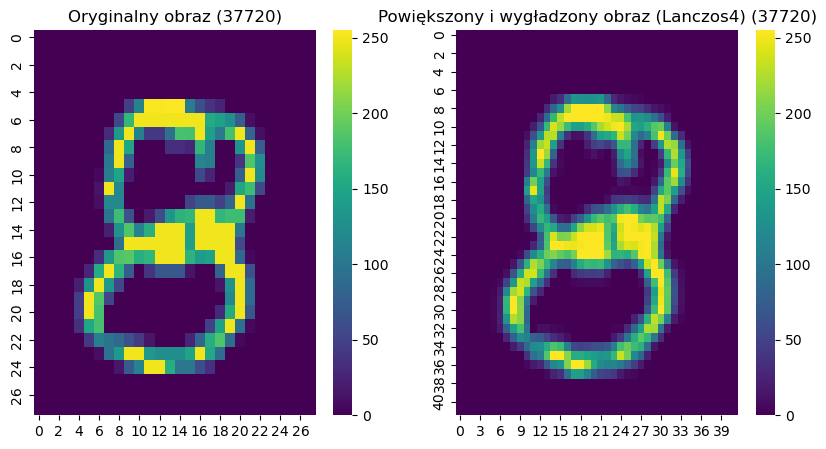

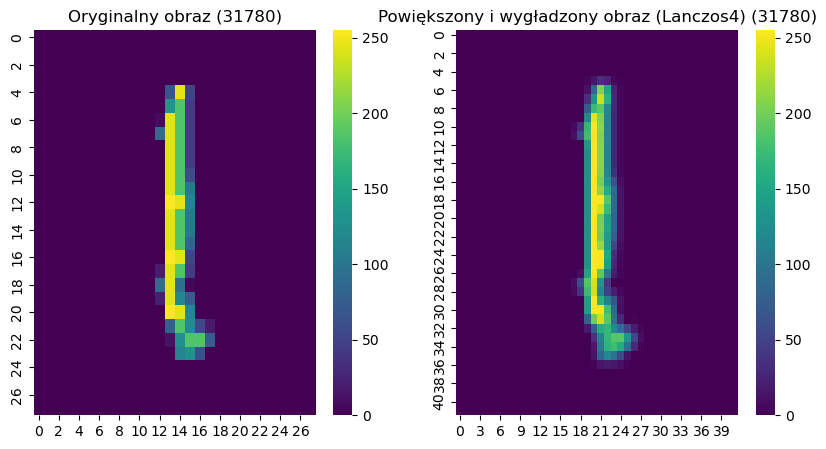

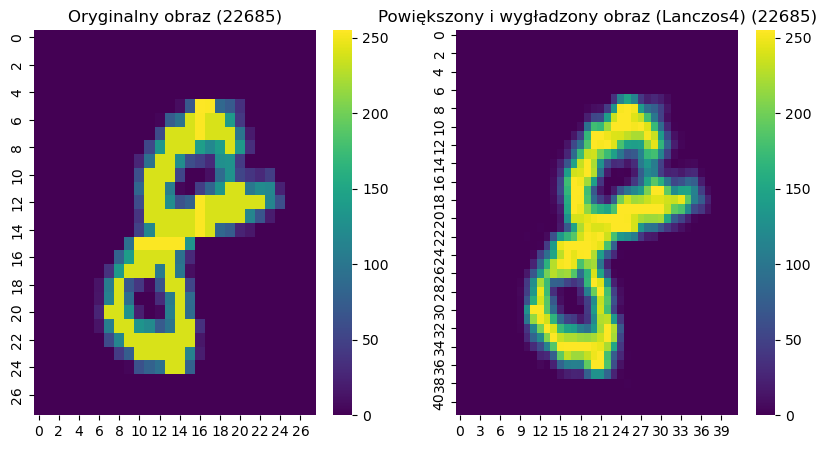

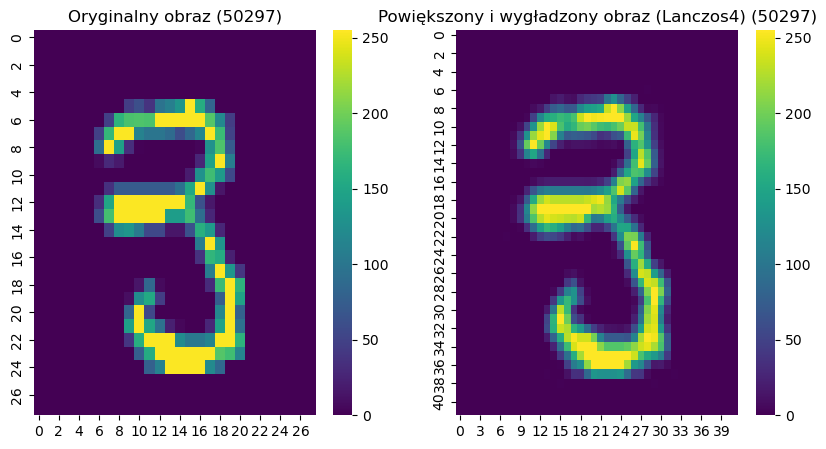

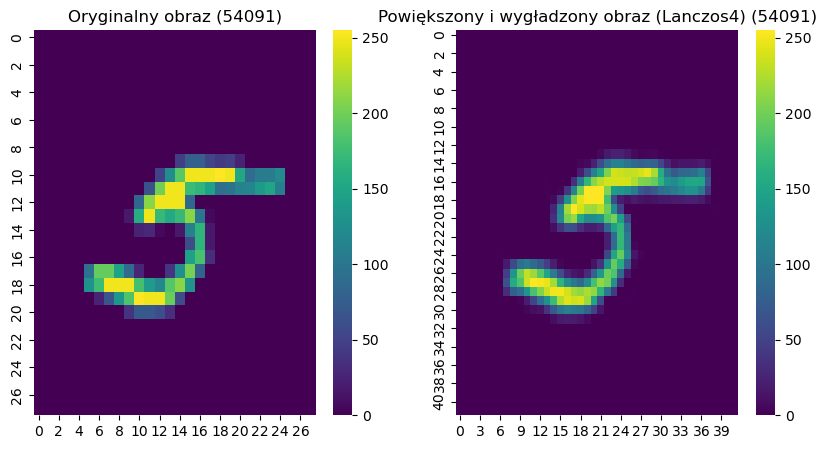

In [6]:
def enlarge_and_smooth(image, new_size):
    """Powiększa obraz za pomocą interpolacji bicubic."""
    enlarged_image = cv2.resize(image, new_size, interpolation=cv2.INTER_CUBIC)
    return enlarged_image

# Sztuczne zwiększenie rozmiaru obrazu 
sample_indices = np.random.choice(X_train.shape[0], 5, replace=False)

# Dla każdego wybranego obrazu
for idx in sample_indices:
    # Oryginalny obraz
    original_image = X_train[idx]

    # Powiększony i wygładzony obraz
    enlarged_smoothed_image = enlarge_and_smooth(original_image, new_size=(42, 42))  # Przykładowy nowy rozmiar

    # Wyświetl oryginalny i przekształcony obraz obok siebie
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    sns.heatmap(original_image, cmap="viridis", ax=axes[0])
    axes[0].set_title(f'Oryginalny obraz ({idx})')

    sns.heatmap(enlarged_smoothed_image, cmap="viridis", ax=axes[1])
    axes[1].set_title(f'Powiększony i wygładzony obraz (Lanczos4) ({idx})')

    #plt.show()

### Sprawdzenie modelu wykorzystując SVC

In [7]:
# # Baseline accuracy without transformations
# X_train_base, X_val_base, y_train_base, y_val_base = train_test_split(X_train, y_train, test_size=0.2, random_state=69)

# qda_base = QDA()
# qda_base.fit(X_train_base.reshape(X_train_base.shape[0], -1), y_train_base)  # Flatten images for QDA
# y_pred_qda_base = qda_base.predict(X_val_base.reshape(X_val_base.shape[0], -1))
# accuracy_qda_base = accuracy_score(y_val_base, y_pred_qda_base)

# svm_base = SVC()
# svm_base.fit(X_train_base.reshape(X_train_base.shape[0], -1), y_train_base)  # Flatten images for SVM
# y_pred_svm_base = svm_base.predict(X_val_base.reshape(X_val_base.shape[0], -1))
# accuracy_svm_base = accuracy_score(y_val_base, y_pred_svm_base)

# print("Baseline QDA accuracy:", accuracy_qda_base)
# print("Baseline SVM accuracy:", accuracy_svm_base)

Baseline QDA accuracy: 0.5525


Baseline SVM accuracy: 0.9793

# Deklaracja funkcji dla ekstrakcji cech z obrazu

In [8]:

def calculate_hog_parallel(images, orientations=None, pixels_per_cell=None, cells_per_block=None, n_jobs=-1):
    """Oblicza deskryptory HOG dla obrazu."""
    
     # Ustawienie wartości domyślnych, jeśli parametry nie są podane
    if orientations is None:
        orientations = 9
    if pixels_per_cell is None:
        pixels_per_cell = (8, 8)
    if cells_per_block is None:
        cells_per_block = (2, 2)
    
    def calculate_hog(image, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block):
        
        image = img_as_float32(image)

        fd = hog(image, orientations=orientations, pixels_per_cell=pixels_per_cell,
                cells_per_block=cells_per_block, visualize=False, channel_axis=None)

        return fd
    
    return Parallel(n_jobs=n_jobs)(delayed(calculate_hog)(image, orientations, pixels_per_cell, cells_per_block) for image in images)


def apply_gabor_filters_parallel(images, thetas=None, sigmas=None, frequencies=None, n_jobs=-1):
    """
    Stosuje filtry Gabora do wielu obrazów równolegle.

    Argumenty:
        images: Lista obrazów wejściowych.
        thetas: (Opcjonalnie) Lista kątów orientacji filtrów Gabora (w radianach). Jeśli None, używane są wartości domyślne.
        sigmas: (Opcjonalnie) Lista odchyleń standardowych filtrów Gabora. Jeśli None, używane są wartości domyślne.
        frequencies: (Opcjonalnie) Lista częstotliwości przestrzennych filtrów Gabora. Jeśli None, używane są wartości domyślne.
        n_jobs: Liczba rdzeni procesora do wykorzystania podczas zrównoleglania. -1 oznacza użycie wszystkich dostępnych rdzeni.

    Zwraca:
        Listę tablic NumPy zawierających obrazy przefiltrowane filtrami Gabora, o typie danych float32.
    """

    # Ustawienie wartości domyślnych, jeśli parametry nie są podane
    if thetas is None:
        thetas = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    if sigmas is None:
        sigmas = [1, 3]
    if frequencies is None:
        frequencies = [0.05, 0.25]

    def apply_gabor_filters_single(image):
        image = img_as_float32(image)
        filtered_images = [gabor(image, frequency, theta=theta, sigma_x=sigma, sigma_y=sigma)[0]
                           for theta in thetas for sigma in sigmas for frequency in frequencies]
        return np.array(filtered_images, dtype=np.float32)

    return Parallel(n_jobs=n_jobs)(delayed(apply_gabor_filters_single)(image) for image in images)


def extract_features_HOG_Gabor(X, hog_orientations=None, hog_pixels_per_cell=None, hog_cells_per_block=None, 
                              gabor_thetas=None, gabor_sigmas=None, gabor_frequencies=None):
    """Generator zwracający cechy HOG i Gabora dla obrazów."""

    hog_features_list = calculate_hog_parallel(X, orientations=hog_orientations, pixels_per_cell=hog_pixels_per_cell, cells_per_block=hog_cells_per_block)
    gabor_features_list = apply_gabor_filters_parallel(X, thetas=gabor_thetas, sigmas=gabor_sigmas, frequencies=gabor_frequencies)

    for hog_features, gabor_features in zip(hog_features_list, gabor_features_list):
        
        gabor_features_flattened = np.array([img.flatten() for img in gabor_features])

        # Dopasowujemy kształt hog_features do gabor_features_flattened
        hog_features_reshaped = np.repeat(hog_features.reshape(1, -1), gabor_features_flattened.shape[0], axis=0)

        # Łączymy cechy HOG i Gabora w poziomie
        concatenated_features = np.hstack((hog_features_reshaped, gabor_features_flattened))

        concatenated_features = concatenated_features.flatten()

        yield concatenated_features

#################################################################################################################################################
################################################  Directional filters, ORB    ###################################################################

def apply_directional_filters(image, kernel_sizes=[3, 5, 7]):
    """Stosuje filtry kierunkowe do obrazu."""
    filtered_images = []
    for kernel_size in kernel_sizes:
        kernel_horizontal = cv2.getDerivKernels(1, 0, kernel_size, normalize=True)
        kernel_vertical = cv2.getDerivKernels(0, 1, kernel_size, normalize=True)
        filtered_horizontal = cv2.filter2D(image, cv2.CV_32F, kernel_horizontal[0])
        filtered_vertical = cv2.filter2D(image, cv2.CV_32F, kernel_vertical[0])
        filtered_images.append(filtered_horizontal.flatten())
        filtered_images.append(filtered_vertical.flatten())
        if kernel_size % 2 == 0 or kernel_size > 31:
            raise ValueError(f"Nieprawidłowy rozmiar jądra: {kernel_size}. Rozmiar jądra musi być nieparzysty i nie większy niż 31.")
    return np.array(filtered_images).squeeze()

def extract_orb_features(image, nfeatures=500):
    """Wyodrębnia cechy ORB z obrazu."""
    orb = cv2.ORB_create(nfeatures=nfeatures)  
    keypoints, descriptors = orb.detectAndCompute(image, None)
    if descriptors is None:
        return np.zeros(nfeatures * 32)  
    return descriptors.flatten()



#################################################################################################################################################
################################################  GLCM, Zernike    ##############################################################################
def extract_glcm_features(image, distances=[1], angles=[0], properties=['contrast', 'energy', 'homogeneity', 'correlation']):
    """Wyodrębnia cechy GLCM z obrazu."""
    if len(image.shape) > 2:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    glcm = graycomatrix(image, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)

    features = []
    for prop in properties:
        features.extend(graycoprops(glcm, prop).flatten())

    return np.array(features)


## Testowanie modelu dla HOG i filtrów Gabora i porównanie wydajności przy zastosowaniu redukcji wymiarów. 

In [9]:
# def train_and_evaluate_models(X_train, y_train, use_pca=True):
#     """
#     Trenuje i ocenia modele QDA i SVC, opcjonalnie z redukcją wymiarów PCA.

#     Argumenty:
#         X_train: Dane treningowe.
#         y_train: Etykiety treningowe.
#         use_pca: Flaga wskazująca, czy używać PCA (domyślnie True).
#     """

#     # Ekstrakcja cech HOG i Gabor za pomocą generatora
#     X_train_features = np.array(list(extract_features_HOG_Gabor(X_train)))

#     # Podział na zbiór treningowy i walidacyjny
#     X_train, X_val, y_train, y_val = train_test_split(X_train_features, y_train, test_size=0.2, random_state=69)

#     # Redukcja wymiarów (opcjonalnie)
#     if use_pca:
#         pca_dim = PCA(n_components=50)
#         X_train = pca_dim.fit_transform(X_train)
#         X_val = pca_dim.transform(X_val)

#     # Tworzenie i trenowanie modelu QDA
#     qda = QDA()
#     qda.fit(X_train, y_train)

#     # Tworzenie i trenowanie modelu SVC
#     svc = SVC(kernel='rbf')
#     svc.fit(X_train, y_train)

#     # Ocena modelu
#     y_pred_qda = qda.predict(X_val)
#     accuracy_qda = accuracy_score(y_val, y_pred_qda)

#     y_pred_svc = svc.predict(X_val)
#     accuracy_svc = accuracy_score(y_val, y_pred_svc)

#     print("Dokładność QDA HOG i Gabor", "po PCA:" if use_pca else ":", accuracy_qda)
#     print("Dokładność SVC HOG i Gabor", "po PCA:" if use_pca else ":", accuracy_svc)

# # Test z PCA
# train_and_evaluate_models(X_train, y_train, use_pca=True)
#train_and_evaluate_models(X_train, y_train, use_pca=False)
#cProfile.run('train_and_evaluate_models(X_train, y_train, use_pca=True)') 

Dokładność QDA HOG i Gabor       : 0.5734


Dokładność SVC HOG i Gabor       : 0.987





Dokładność QDA HOG i Gabor po PCA: 0.9701


Dokładność SVC HOG i Gabor po PCA: 0.9869

Czas obliczeń dla PCA 3min vs 30min bez PCA

## OPTUNA dla HOG, Gabor, PCA

In [10]:
# import warnings
# warnings.filterwarnings("ignore", module="optuna")


# def objective(trial, X_train, y_train):
#     """
#     Funkcja celu dla optymalizacji Optuna. 
#     Przyjmuje próbę (trial), dane treningowe (X_train) i etykiety (y_train).
#     Zwraca dokładność QDA i SVM na danych walidacyjnych po zastosowaniu sekwencji transformacji.
#     """

#     # Parametry HOG
#     orientations      = trial.suggest_int("hog_orientations", 2, 16)
#     pixels_per_cell   = trial.suggest_categorical("hog_pixels_per_cell", [str((2, 2)), str((2, 3)), str((3, 2)), str((3, 3)), str((4, 4)), str((5, 5)),str((6, 6)), str((7, 7))])
#     cells_per_block   = trial.suggest_categorical("hog_cells_per_block", [str((1, 1)), str((2, 2)), str((3, 3)), str((4, 4))])

#     # Parametry filtrów Gabora
#     gabor_thetas      = trial.suggest_categorical("gabor_thetas", ([0],  [np.pi / 14],  [np.pi / 12], [0, np.pi / 14 ], [0, np.pi / 12 ] ))
#     gabor_sigmas      = trial.suggest_categorical("gabor_sigmas", ([0.33], [0.66], [1], [0.33 , 1.25], [0.66, 2.35], [1, 3]))
#     gabor_frequencies = trial.suggest_categorical("gabor_frequencies", ([0.025], [0.05], [0.125], [0.025, 0.125], [0.05, 0.175], [0.05, 0.25]))
        
#     #PCA
#     PCA_n_components  =  trial.suggest_int("PCA_Components", 4, 228)
#     kernel = trial.suggest_categorical("kernel_pca_kernel", ['linear', 'poly', 'rbf', 'sigmoid', 'cosine'])
#     gamma = None
#     if kernel in ['poly', 'rbf']:
#         gamma = trial.suggest_loguniform("kernel_pca_gamma", 0.001, 1)
        
#     # Powiększanie i wygładzanie
#     # X_train_split = np.array([enlarge_and_smooth(img, new_size) for img in X_train])
#     # X_val = np.array([enlarge_and_smooth(img, new_size) for img in X_val])
    
#     # Ekstrakcja cech HOG i Gabor
#     X_train_features = np.array(list(extract_features_HOG_Gabor(
#         X_train, 
#         hog_orientations=orientations, 
#         hog_pixels_per_cell=eval(pixels_per_cell), # Konwersja stringa na krotkę
#         hog_cells_per_block=eval(cells_per_block),  # Konwersja stringa na krotkę
#         gabor_thetas=gabor_thetas, 
#         gabor_sigmas=gabor_sigmas, 
#         gabor_frequencies=gabor_frequencies
#     )))

#     # Podział na zbiór treningowy i walidacyjny
#     X_train_filters, X_val_filters, y_train_filters, y_val_filters = train_test_split(X_train_features, y_train, test_size=0.2, random_state=69)
    
    
#     # Kernel PCA
#     kpca = KernelPCA(n_components=PCA_n_components, kernel=kernel, gamma=gamma)
#     X_train_reduced = kpca.fit_transform(X_train_filters)
#     X_val_reduced = kpca.transform(X_val_filters)
                
#     # SVC
#     svc = SVC(kernel='rbf')
#     svc.fit(X_train_reduced, y_train_filters)
#     y_pred_svm = svc.predict(X_val_reduced)
#     accuracy_svm = accuracy_score(y_val_filters, y_pred_svm)

#     return accuracy_svm

# # Optymalizacji
                            
# study = optuna.create_study(directions=["maximize"], sampler=optuna.samplers.CmaEsSampler() ) 
# study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=100, n_jobs=1)


# print("Best parameters:", study.best_params)
# print("Best QDA accuracy:", study.best_trial.values[0]) 
# print("Best SVM accuracy:", study.best_trial.values[1]) 

# # [I 2024-09-17 05:43:37,964] Trial 13 finished with value: 0.99133 and parameters: {'hog_orientations': 16, 'hog_pixels_per_cell': '(4, 4)', 'hog_cells_per_block': '(3, 3)', 'gabor_thetas': [0.2243994752564138], 'gabor_sigmas': [0.66, 2.35], 'gabor_frequencies': [0.025], 'PCA_Components': 209, 'kernel_pca_kernel': 'cosine'}. Best is trial 13 with value: 0.9913333333333333.
# # [I 2024-09-17 08:45:58,345] Trial 19 finished with value: 0.99175 and parameters: {'hog_orientations': 6, 'hog_pixels_per_cell': '(2, 3)', 'hog_cells_per_block': '(2, 2)', 'gabor_thetas': [0.2617993877991494], 'gabor_sigmas': [1], 'gabor_frequencies': [0.025], 'PCA_Components': 132, 'kernel_pca_kernel': 'sigmoid'}. Best is trial 19 with value: 0.99175.
# # [I 2024-09-17 10:45:29,605] Trial 23 finished with value: 0.99225 and parameters: {'hog_orientations': 6, 'hog_pixels_per_cell': '(3, 3)', 'hog_cells_per_block': '(2, 2)', 'gabor_thetas': [0], 'gabor_sigmas': [1], 'gabor_frequencies': [0.05, 0.25], 'PCA_Components': 150, 'kernel_pca_kernel': 'cosine'}. Best is trial 23 with value: 0.99225.
# # [I 2024-09-17 13:24:59,082] Trial 28 finished with value: 0.99108 and parameters: {'hog_orientations': 9, 'hog_pixels_per_cell': '(3, 2)', 'hog_cells_per_block': '(1, 1)', 'gabor_thetas': [0, 0.2617993877991494], 'gabor_sigmas': [1], 'gabor_frequencies': [0.05, 0.25], 'PCA_Components': 190, 'kernel_pca_kernel': 'sigmoid'}. Best is trial 23 with value: 0.99225.
# # [I 2024-09-17 13:54:44,248] Trial 29 finished with value: 0.9915 and parameters: {'hog_orientations': 7, 'hog_pixels_per_cell': '(4, 4)', 'hog_cells_per_block': '(4, 4)', 'gabor_thetas': [0.2617993877991494], 'gabor_sigmas': [0.66, 2.35], 'gabor_frequencies': [0.05], 'PCA_Components': 164, 'kernel_pca_kernel': 'cosine'}. Best is trial 23 with value: 0.99225.
# # [I 2024-09-17 18:02:03,444] Trial 37 finished with value: 0.99066 and parameters: {'hog_orientations': 9, 'hog_pixels_per_cell': '(3, 2)', 'hog_cells_per_block': '(4, 4)', 'gabor_thetas': [0], 'gabor_sigmas': [0.66, 2.35], 'gabor_frequencies': [0.05, 0.175], 'PCA_Components': 169, 'kernel_pca_kernel': 'rbf', 'kernel_pca_gamma': 0.0032186977490984547}. Best is trial 23 with value: 0.99225.
# # [I 2024-09-17 19:02:58,946] Trial 39 finished with value: 0.9915 and parameters: {'hog_orientations': 6, 'hog_pixels_per_cell': '(4, 4)', 'hog_cells_per_block': '(4, 4)', 'gabor_thetas': [0, 0.2243994752564138], 'gabor_sigmas': [1, 3], 'gabor_frequencies': [0.125], 'PCA_Components': 148, 'kernel_pca_kernel': 'linear'}. Best is trial 23 with value: 0.99225.


### Wykorzystanie wcześniej otrzymanch hiperparamatrów dla HOG i filtrów Gabora po KPCA w celu stworzenia wektora cech z obrazów.

In [11]:
# X_train_features = np.array(list(extract_features_HOG_Gabor(
#         X_train, 
#         hog_orientations=6, 
#         hog_pixels_per_cell=eval('(3, 3)'), 
#         hog_cells_per_block=eval('(2, 2)'),  
#         gabor_thetas=[0], 
#         gabor_sigmas=[1], 
#         gabor_frequencies=[0.05, 0.25]
#     )))


# kpca = KernelPCA(n_components=150, kernel='cosine')

# X_train_filters, X_val_filters, y_train_filters, y_val_filters = train_test_split(X_train_features, y_train_ENC, test_size=0.2, random_state=69)

# X_train_reduced = kpca.fit_transform(X_train_filters)
# X_val_reduced = kpca.transform(X_val_filters)


# np.save('X_train_reduced.npy', X_train_reduced)
# np.save('X_val_reduced.npy', X_val_reduced)
# np.save('y_train_filters.npy', y_train_filters)
# np.save('y_val_filters.npy', y_val_filters)


#### Pierwszy model na sieci konwolucyjnej dla bazy z HOG i Gabora.

In [12]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, LayerNormalization , BatchNormalization, PReLU , Input, ActivityRegularization, GlobalAveragePooling1D, SeparableConv1D 
# from tensorflow.keras.optimizers.schedules import ExponentialDecay
# from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Lion
# from tensorflow.keras.callbacks import EarlyStopping
# import gc



# X_train_reduced = np.load('X_train_reduced.npy')
# X_val_reduced = np.load('X_val_reduced.npy')
# y_train_filters = np.load('y_train_filters.npy')
# y_val_filters = np.load('y_val_filters.npy')

# X_train_reduced = X_train_reduced.reshape(X_train_reduced.shape[0], X_train_reduced.shape[1], 1)
# X_val_reduced = X_val_reduced.reshape(X_val_reduced.shape[0], X_val_reduced.shape[1], 1)

# def calculate_max_pool_size(input_length, prev_pool_size, min_output_size=2):
#     calculated_pool_size = input_length // prev_pool_size
#     return max(min_output_size, calculated_pool_size)


# def objective(trial):
#     """Funkcja celu dla Optuny."""
#     #os.environ['TF_NUM_INTRAOP_THREADS'] = '1' ## Czy Kers działa na pojedycznym wątku ????
#     gc.collect()
#     tf.keras.backend.clear_session()
#     gc.collect()

#     activation_functions = ['relu', 'elu', 'leaky_relu', 'tanh']
#     activation = trial.suggest_categorical('activation', activation_functions)

#     # Definiowanie modelu
#     model = Sequential()
#     model.add(Input(shape=(X_train_reduced.shape[1], 1)))

#     # Pierwsza warstwa konwolucyjna
#     model.add(Conv1D(filters=trial.suggest_int('conv1d_filters_1', 48, 450),
#                      kernel_size=trial.suggest_int('kernel_size_1', 2, 16),
#                      #activation=activation,
#                      padding='same', 
#                      #dilation_rate=trial.suggest_int('dilation_rate_1', 1, 4)
#                      )
#               )
#     model.add(PReLU())                #$$$$$$$ LAYER przed PRelu
#     model.add(LayerNormalization())   ######
#     model.add(ActivityRegularization(l1=trial.suggest_float('l1_1', 1e-6, 1e-1, log=True), 
#                                      l2=trial.suggest_float('l2_1', 1e-6, 1e-1, log=True)
#                                      )
#               )
#     pool_size_1 = trial.suggest_int('pool_size_1', 2, 10)
#     model.add(MaxPooling1D(pool_size=pool_size_1))



#     # Druga warstwa konwolucyjna
#     input_length_2 = X_train_reduced.shape[1] // pool_size_1
#     model.add(Conv1D(filters=trial.suggest_int('conv1d_filters_2', 24, 400),
#                      kernel_size=trial.suggest_int('kernel_size_2', 2, 14),
#                      padding='same',
#                      #activation=activation,
#                      #dilation_rate=trial.suggest_int('dilation_rate_2', 1, 4)
#                      )
#               )
#     model.add(PReLU())
#     model.add(LayerNormalization())
#     model.add(ActivityRegularization(l1=trial.suggest_float('l1_2', 1e-6, 1e-1, log=True), 
#                                      l2=trial.suggest_float('l2_2', 1e-6, 1e-1, log=True)
#                                      )
#               )
#     pool_size_2 = trial.suggest_int('pool_size_2', 2, input_length_2 // 2)
#     #pool_size_2 = trial.suggest_int('pool_size_2', 2, 10)
#     model.add(MaxPooling1D(pool_size=pool_size_2))



#     # Trzecia warstwa konwolucyjna
#     #input_length_3 = input_length_2 // pool_size_2
#     model.add(Conv1D(filters=trial.suggest_int('conv1d_filters_3', 32, 300),
#                      kernel_size=trial.suggest_int('kernel_size_3', 2, 12),
#                      padding='same',
#                      )
#               )
#     model.add(PReLU())
#     model.add(LayerNormalization())
#     model.add(Dropout(rate=trial.suggest_float('dropout_rate_3', 0.01, 0.5)
#                       )
#               )
#     #pool_size_3 = trial.suggest_int('pool_size_3', 2, max(2, input_length_3 // 2))
#     #pool_size_3 = trial.suggest_int('pool_size_3', 2, 8)
#     #model.add(MaxPooling1D(pool_size=pool_size_3))

#     # Warstwy Dense
#     model.add(GlobalAveragePooling1D())
    
#     model.add(Dense(units=trial.suggest_int('dense_units_1', 40, 300), activation=activation))
#     model.add(Dropout(rate=trial.suggest_float('dropout_rate_4', 0.01, 0.75)))
    
#     model.add(Dense(units=trial.suggest_int('dense_units_2', 20, 200), activation=activation))
#     model.add(Dropout(rate=trial.suggest_float('dropout_rate_5', 0.01, 0.65)))
    
#     model.add(Dense(10, activation='softmax'))

#     # Optymalizator
#     lr_initial = trial.suggest_float("lr_initial", 1e-5, 1e-1, log=True)
#     decay_steps = trial.suggest_int("decay_steps", 10, 150)
#     decay_rate = trial.suggest_float("decay_rate", 0.01, 0.99)
#     lr_schedule = ExponentialDecay(initial_learning_rate=lr_initial,
#                                   decay_steps=decay_steps,
#                                   decay_rate=decay_rate)

#     optimizer_name = trial.suggest_categorical('optimizer', ['Lion'])
#     optimizer_class = getattr(tf.keras.optimizers, optimizer_name)
#     optimizer = optimizer_class(learning_rate=lr_schedule)

    
#     model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

#     # Early Stopping
#     early_stopping = EarlyStopping(monitor='val_accuracy', patience=16, start_from_epoch=10, min_delta = 0.00005)

#     # Trenowanie modelu
#     model.fit(X_train_reduced, y_train_filters,
#               epochs=trial.suggest_int('epochs', 40, 150),
#               batch_size=trial.suggest_int('batch_size', 64, 1920),
#               validation_data=(X_val_reduced, y_val_filters),
#               verbose=1,
#               callbacks=[early_stopping])

#     # Ewaluacja modelu
#     _, accuracy = model.evaluate(X_val_reduced, y_val_filters, verbose=0)

#     del model
#     return accuracy

# study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())
# study.optimize(objective, n_trials=600, n_jobs=1, gc_after_trial=True) ## Czy keras działa na wszystkich wątkach, ale optuna na pojedynczym. 


# # Najlepsze parametry i wynik
# print("Najlepsze parametry:", study.best_params)
# print("Najlepsza dokładność:", study.best_value)

# #[I 2024-10-04 05:18:28,377] Trial 26 finished with value: 0.9810000061988831 and parameters: {'activation': 'elu', 'conv1d_filters_1': 347, 'kernel_size_1': 7,  'l1_1': 0.0002141584459916536, 'l2_1': 4.201061472934882e-06, 'pool_size_1': 6, 'conv1d_filters_2': 77, 'kernel_size_2': 14, 'l1_2': 3.203529032832527e-06, 'l2_2': 0.00015793896479891322, 'pool_size_2': 2, 'conv1d_filters_3': 258, 'kernel_size_3': 4, 'dropout_rate_3': 0.3297488074504043, 'dense_units_1': 271, 'dropout_rate_4': 0.5097723961373417, 'dense_units_2': 78, 'dropout_rate_5': 0.15473996425601394, 'lr_initial': 0.0004175922071628326, 'decay_steps': 33, 'decay_rate': 0.9780884395210858, 'optimizer': 'Lion', 'epochs': 123, 'batch_size': 264}. Best is trial 26 with value: 0.9810000061988831.
# #[I 2024-10-04 14:58:14,236] Trial 61 finished with value: 0.9797499775886536 and parameters: {'activation': 'elu', 'conv1d_filters_1': 424, 'kernel_size_1': 13, 'l1_1': 0.0005501543495144062, 'l2_1': 0.02794377888054429,   'pool_size_1': 7, 'conv1d_filters_2': 79, 'kernel_size_2': 12, 'l1_2': 1.3699264627909325e-06, 'l2_2': 6.577814668979489e-06, 'pool_size_2': 3, 'conv1d_filters_3': 280, 'kernel_size_3': 3, 'dropout_rate_3': 0.21341586312675653, 'dense_units_1': 292, 'dropout_rate_4': 0.22415600475665626, 'dense_units_2': 106, 'dropout_rate_5': 0.09686035013603865, 'lr_initial': 0.0004430745906851504, 'decay_steps': 22, 'decay_rate': 0.9872365423551039, 'optimizer': 'Lion', 'epochs': 150, 'batch_size': 216}. Best is trial 26 with value: 0.9810000061988831.


#### Drugi model na GRU

In [13]:
# import tensorflow as tf
# from tensorflow.keras.layers import Input, LSTM , GRU , LayerNormalization, PReLU, ActivityRegularization, Dense, GlobalAveragePooling1D, Dropout
# from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers.schedules import ExponentialDecay
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# import optuna


# X_train_reduced = np.load('X_train_reduced.npy')
# X_val_reduced = np.load('X_val_reduced.npy')
# y_train_filters = np.load('y_train_filters.npy')
# y_val_filters = np.load('y_val_filters.npy')

# X_train_reduced = X_train_reduced.reshape(X_train_reduced.shape[0], X_train_reduced.shape[1], 1)
# X_val_reduced = X_val_reduced.reshape(X_val_reduced.shape[0], X_val_reduced.shape[1], 1)

# def objective(trial):
    
#     Inp = Input(shape=(X_train_reduced.shape[1], 1))

#     x = PReLU()(Inp)
#     x = GRU(
#         units=trial.suggest_int('units_1', 24, 600),
#         activation='silu',
#         return_sequences=True  # Dodano return_sequences=True
#     )(x)
#     x = LayerNormalization()(x)
#     x = ActivityRegularization(
#         l1=trial.suggest_float('l1_1', 1e-6, 1e-1, log=True),
#         l2=trial.suggest_float('l2_1', 1e-6, 1e-1, log=True)
#     )(x)

#     x = PReLU()(x)
#     x = GRU(
#         units=trial.suggest_int('units_2', 24, 600),
#         activation='silu'
#     )(x)
#     x = LayerNormalization()(x)
#     x = ActivityRegularization(
#         l1=trial.suggest_float('l1_2', 1e-6, 1e-1, log=True),
#         l2=trial.suggest_float('l2_2', 1e-6, 1e-1, log=True)
#     )(x)

#     x = Dense(units=trial.suggest_int('dense_units', 24, 600), activation='silu')(x)
#     x = Dropout(rate=trial.suggest_float('dropout_rate_last', 0.01, 0.75))(x)
#     outputs = Dense(10, activation='softmax')(x)

#     model = Model(inputs=Inp, outputs=outputs)
#     tf.keras.utils.plot_model(model, to_file='model.png')


#     # ReduceLROnPlateau
#     reduce_lr = ReduceLROnPlateau(
#         monitor='val_loss',
#         factor=trial.suggest_float("reduce_lr_factor", 0.1, 0.9, step=0.1),
#         patience=trial.suggest_int("reduce_lr_patience", 2, 12),
#         min_lr=trial.suggest_float("reduce_lr_min_lr", 1e-7, 1e-4, log=True)
#     )

#     # Optymalizator
#     optimizer_name = trial.suggest_categorical('optimizer', ['AdamW'])
#     optimizer_class = getattr(tf.keras.optimizers, optimizer_name)
    
#     # Początkową wartość learning rate
#     lr_initial = trial.suggest_float("lr_initial", 5e-3, 1e-1, log=True)
#     optimizer = optimizer_class(learning_rate=lr_initial)  

#     model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
#     #model.summary()

#     # Early Stopping
#     early_stopping = EarlyStopping(monitor='val_accuracy', patience=12, start_from_epoch=8, min_delta = 0.0001)
    
#     # Trenowanie modelu
#     model.fit(X_train_reduced, y_train_filters,
#               epochs=trial.suggest_int('epochs', 25, 80),
#               batch_size=trial.suggest_int('batch_size', 64, 1920),
#               validation_data=(X_val_reduced, y_val_filters),
#               verbose=0,
#               callbacks=[early_stopping, reduce_lr])

#     # Ewaluacja modelu
#     _, accuracy = model.evaluate(X_val_reduced, y_val_filters, verbose=0)
    
    
#     del model
#     return accuracy

# study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())
# study.optimize(objective, n_trials=600, n_jobs=1, gc_after_trial=True) ## Czy keras działa na wszystkich wątkach, ale optuna na pojedynczym. 


# # Najlepsze parametry i wynik
# print("Najlepsze parametry:", study.best_params)
# print("Najlepsza dokładność:", study.best_value)   

### Sieć CONV2D z zamrożonym PCA dla danych pierwotnych

In [ ]:
import tensorflow as tf
import keras
from keras import layers
import tensorflow_probability as tfp
import optuna
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

X_train_image, X_val_image, y_train_image, y_val_image = train_test_split(X_train, y_train_ENC, test_size=0.2, random_state=69)
X_train_image = X_train_image.astype('float32')
X_val_image = X_val_image.astype('float32')
X_train_image = np.expand_dims(X_train_image, axis=-1)  
X_val_image = np.expand_dims(X_val_image, axis=-1) 
 
def objective(trial):
    # Przestrzeń hiperparametrów
    num_filters1 = trial.suggest_int("num_filters1", 32, 256)    # Pierwsza warstwa Conv2d
    num_filters2 = trial.suggest_int("num_filters2", 64, 256)    # Druga warstwa Conv2d
    num_filters3 = trial.suggest_int("num_filters3", 128, 256)   # Trzecia warstwa Conv2d
    n_components = trial.suggest_int("PCA_components", 350, 500) # PCA

    l1_1=trial.suggest_float('l1_1', 1e-6, 1e-1, log=True)
    l2_1=trial.suggest_float('l2_1', 1e-6, 1e-1, log=True)
    
    l1_2=trial.suggest_float('l1_2', 1e-6, 1e-1, log=True)
    l2_2=trial.suggest_float('l2_2', 1e-6, 1e-1, log=True)

    l1_3=trial.suggest_float('l1_3', 1e-6, 1e-1, log=True)
    l2_3=trial.suggest_float('l2_3', 1e-6, 1e-1, log=True)
    
    activation_functions = ['relu', 'gelu', 'leaky_relu', 'silu', 'mish']
    activation = trial.suggest_categorical('activation', activation_functions)
    
    
    # Warstwy konwolucyjne 2D
    conv_layers = [
        # Pierwsza warstwa Conv2d
        tf.keras.layers.Conv2D(
                                num_filters1,
                                kernel_size=2,
                                activation=activation,
                                kernel_regularizer=tf.keras.regularizers.l2(l2_1),
                                bias_regularizer=tf.keras.regularizers.l1(l1_1),
                                padding='same',
                                input_shape=(X_train_image.shape[1:])
                                ),
        
        tf.keras.layers.MaxPool2D(pool_size=2,strides=1,
                                 ),
        # Druga warstwa Conv2d
        tf.keras.layers.Conv2D(
                                num_filters2,
                                kernel_size=2,
                                activation=activation,
                                kernel_regularizer=tf.keras.regularizers.l2(l2_2),
                                bias_regularizer=tf.keras.regularizers.l1(l1_2),                                
                                padding='same',
                                ),
        tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
        # Trzecia warstwa Conv2d
        tf.keras.layers.Conv2D(
                                num_filters3,
                                kernel_size=2,
                                activation=activation,
                                kernel_regularizer=tf.keras.regularizers.l2(l2_3),
                                bias_regularizer=tf.keras.regularizers.l1(l1_3),                                
                                padding='same'
                                ),
        tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
        
        tf.keras.layers.Flatten(),
                ]

    ### Obliczenia dla zamrożonego PCA na podstawie pierwszej inicjalizacji modelu
    conv_model = keras.models.Sequential(conv_layers)  
    X_train_PCA = conv_model.predict(X_train_image)
    
    X_train_PCA = tf.reshape(X_train_PCA, [X_train_PCA.shape[0], -1])

    # Macierz kowariancji
    covariance_matrix = tfp.stats.covariance(X_train_PCA, sample_axis=0, event_axis=-1)
    # Wektory i wartości własne
    eigenvalues, eigenvectors = tf.linalg.eigh(covariance_matrix)
    sorted_indices = tf.argsort(eigenvalues, direction='DESCENDING')
    eigenvalues = tf.gather(eigenvalues, sorted_indices)
    eigenvectors = tf.gather(eigenvectors, sorted_indices, axis=1)
    
    #### Opcja druga na SVD, ale wymaga jeszcze zabawy
    # s, u, v = tf.linalg.svd(covariance_matrix)
    # eigenvectors = v
    # eigenvalues = tf.square(s) 
    
    # Warstwa PCA
    model = keras.models.Sequential(conv_layers + [
        tf.keras.layers.Lambda(lambda x, eigenvectors: tf.matmul(x, eigenvectors), arguments={'eigenvectors': eigenvectors[:, :n_components]})
    ])

    # Output (klasyfikacja)
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    #model.summary()
    tf.keras.utils.plot_model(model, show_shapes=True, to_file='model.png')
    

    # Optymalizator
    optimizer_name = trial.suggest_categorical('optimizer', ['AdamW'])
    optimizer_class = getattr(tf.keras.optimizers, optimizer_name)
    
    # Początkową wartość learning rate
    lr_initial = trial.suggest_float("lr_initial", 5e-3, 1e-1, log=True)
    optimizer = optimizer_class(learning_rate=lr_initial)  

    ## Kompilacja modelu
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    # Early Stopping
    early_stopping = EarlyStopping(monitor='categorical_accuracy', patience=8, start_from_epoch=8, min_delta=0.0001)
    
    # ReduceLROnPlateau
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=trial.suggest_float("reduce_lr_factor", 0.1, 0.9, step=0.1),
        patience=trial.suggest_int("reduce_lr_patience", 2, 12),
        min_lr=trial.suggest_float("reduce_lr_min_lr", 1e-7, 1e-4, log=True)
    )
    
    # Trenowanie i ocena modelu
    history = model.fit(X_train_image, y_train_image,
                        epochs=trial.suggest_int('epochs', 15, 80),
                        batch_size=trial.suggest_int('batch_size', 64, 1920),
                        validation_data=(X_val_image, y_val_image),
                        callbacks=[early_stopping, reduce_lr]
                        )
    
    accuracy = history.history['val_categorical_accuracy'][-1]

    return accuracy


study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=600, n_jobs=1, gc_after_trial=True) 

# Najlepsze parametry i wynik
print("Najlepsze parametry:", study.best_params)
print("Najlepsza dokładność:", study.best_value)

#Trial 10 finished with value: 0.9884999990463257 and parameters: {'num_filters1': 35, 'num_filters2': 66, 'num_filters3': 251, 'PCA_components': 404, 'l1_1': 0.010382474092204483, 'l2_1': 0.00056103397078657, 'l1_2': 0.0007829797350707273, 'l2_2': 0.03547149066256722, 'l1_3': 0.09000786756934993, 'l2_3': 8.307021605965408e-06, 'activation': 'silu', 'optimizer': 'AdamW', 'lr_initial': 0.01132612446690548, 'reduce_lr_factor': 0.1, 'reduce_lr_patience': 2, 'reduce_lr_min_lr': 9.09129559213764e-05, 'epochs': 28, 'batch_size': 538}.
#Trial 24 finished with value: 0.9890000224113464 and parameters: {'num_filters1': 87, 'num_filters2': 106, 'num_filters3': 227, 'PCA_components': 416, 'l1_1': 0.08813574181461847, 'l2_1': 7.12968438542002e-05, 'l1_2': 3.2743954573515036e-05, 'l2_2': 0.0037696446264538033, 'l1_3': 0.04512986735375382, 'l2_3': 8.166633341647626e-05, 'activation': 'silu', 'optimizer': 'AdamW', 'lr_initial': 0.006711986236273397, 'reduce_lr_factor': 0.2, 'reduce_lr_patience': 4, 'reduce_lr_min_lr': 2.3648250625236786e-05, 'epochs': 27, 'batch_size': 105}.
#Trial 25 finished with value: 0.9894999861717224 and parameters: {'num_filters1': 89, 'num_filters2': 106, 'num_filters3': 232, 'PCA_components': 434, 'l1_1': 0.09689379756720506, 'l2_1': 4.255012103571851e-05, 'l1_2': 3.8736408101382694e-05, 'l2_2': 0.003089013776555346, 'l1_3': 0.029622920197155355, 'l2_3': 5.930227144452765e-05, 'activation': 'relu', 'optimizer': 'AdamW', 'lr_initial': 0.00673133655623355, 'reduce_lr_factor': 0.2, 'reduce_lr_patience': 4, 'reduce_lr_min_lr': 8.578607626063041e-06, 'epochs': 26, 'batch_size': 92}.
#Trial 44 finished with value: 0.9900000095367432 and parameters: {'num_filters1': 182, 'num_filters2': 151, 'num_filters3': 205, 'PCA_components': 392, 'l1_1': 4.2542142921230786e-05, 'l2_1': 5.3926130634303964e-05, 'l1_2': 4.838981289661434e-05, 'l2_2': 0.00486783149602562, 'l1_3': 0.00755364390197699, 'l2_3': 8.05377458317696e-05, 'activation': 'relu', 'optimizer': 'AdamW', 'lr_initial': 0.006103288572595075, 'reduce_lr_factor': 0.2, 'reduce_lr_patience': 4, 'reduce_lr_min_lr': 6.880845050443546e-06, 'epochs': 74, 'batch_size': 174}.
#Trial 51 finished with value: 0.9901666641235352 and parameters: {'num_filters1': 180, 'num_filters2': 156, 'num_filters3': 222, 'PCA_components': 370, 'l1_1': 6.421281258114941e-06, 'l2_1': 5.5198235091606774e-05, 'l1_2': 0.0005161798365001176, 'l2_2': 0.0047101345919299455, 'l1_3': 0.0556719385199307, 'l2_3': 8.175643526727064e-05, 'activation': 'relu', 'optimizer': 'AdamW', 'lr_initial': 0.00581986579372653, 'reduce_lr_factor': 0.2, 'reduce_lr_patience': 4, 'reduce_lr_min_lr': 3.032691833767043e-06, 'epochs': 71, 'batch_size': 150}.
#Trial 76 finished with value: 0.9906666874885559 and parameters: {'num_filters1': 194, 'num_filters2': 167, 'num_filters3': 221, 'PCA_components': 383, 'l1_1': 1.4917571854023011e-06, 'l2_1': 0.0003844462705458024, 'l1_2': 0.0011921068803372, 'l2_2': 0.00021948428596782946, 'l1_3': 0.05677951548917238, 'l2_3': 7.714986268695782e-05, 'activation': 'relu', 'optimizer': 'AdamW', 'lr_initial': 0.006869840110235172, 'reduce_lr_factor': 0.2, 'reduce_lr_patience': 7, 'reduce_lr_min_lr': 2.028747844465778e-06, 'epochs': 51, 'batch_size': 479}.
#Trial 77 finished with value: 0.9902499914169312 and parameters: {'num_filters1': 194, 'num_filters2': 192, 'num_filters3': 214, 'PCA_components': 383, 'l1_1': 1.3308891310241568e-06, 'l2_1': 0.0005008865912237707, 'l1_2': 0.000929752101716963, 'l2_2': 0.00016890763170861927, 'l1_3': 0.057826887813294266, 'l2_3': 0.0014005491546819544, 'activation': 'relu', 'optimizer': 'AdamW', 'lr_initial': 0.005582111710051362, 'reduce_lr_factor': 0.1, 'reduce_lr_patience': 7, 'reduce_lr_min_lr': 1.6600272491208153e-06, 'epochs': 51, 'batch_size': 585}.


31/31 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - categorical_accuracy: 0.2022 - loss: 98.4759 - val_categorical_accuracy: 0.4442 - val_loss: 13.4918 - learning_rate: 0.0203
Epoch 2/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - categorical_accuracy: 0.5580 - loss: 11.8568 - val_categorical_accuracy: 0.8058 - val_loss: 7.8976 - learning_rate: 0.0203
Epoch 3/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - categorical_accuracy: 0.8204 - loss: 7.1261 - val_categorical_accuracy: 0.8544 - val_loss: 5.2737 - learning_rate: 0.0203
Epoch 4/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - categorical_accuracy: 0.8745 - loss: 4.8248 - val_categorical_accuracy: 0.9003 - val_loss: 3.7688 - learning_rate: 0.0203
Epoch 5/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - categorical_accuracy: 0.8970 - loss: 3.5353 - val_categorical_accuracy: 0.7967 - val_loss: 3.4119 - learning_rate: 0.0203
Epoch 6/80
31/31 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - categorical_accuracy: 0.8646 - loss: 2.8933 - val_categorical_accuracy: 0.9211 - val_l

[I 2024-10-07 21:46:42,378] Trial 0 finished with value: 0.9735000133514404 and parameters: {'num_filters1': 106, 'num_filters2': 232, 'num_filters3': 157, 'PCA_components': 469, 'l1_1': 0.0063706902484962635, 'l2_1': 8.651692867133822e-06, 'l1_2': 0.03330948462699045, 'l2_2': 6.472720261585783e-05, 'l1_3': 0.000884987597115497, 'l2_3': 0.01636225095990254, 'activation': 'relu', 'optimizer': 'AdamW', 'lr_initial': 0.020256390573718204, 'reduce_lr_factor': 0.9, 'reduce_lr_patience': 7, 'reduce_lr_min_lr': 1.2184696207382068e-07, 'epochs': 80, 'batch_size': 1562}. Best is trial 0 with value: 0.9735000133514404.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step
Epoch 1/67
44/44 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - categorical_accuracy: 0.1519 - loss: 80.6311 - val_categorical_accuracy: 0.3473 - val_loss: 2.4651 - learning_rate: 0.0235
Epoch 2/67
44/44 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - categorical_accuracy: 0.4598 - loss: 2.1600 - val_categorical_accuracy: 0.7401 - val_loss: 1.3134 - learning_rate: 0.0235
Epoch 3/67
44/44 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - categorical_accuracy: 0.7764 - loss: 1.1955 - val_categorical_accuracy: 0.8632 - val_loss: 0.8803 - learning_rate: 0.0235
Epoch 4/67
44/44 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - categorical_accuracy: 0.8689 - loss: 0.8507 - val_categorical_accuracy: 0.9003 - val_loss: 0.7214 - learning_rate: 0.0235
Epoch 5/67
44/44 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - categorical_accuracy: 0.9059 - loss: 0.6890 - val_categorical_accuracy: 0.9227 - val_loss: 0.6094 - learning_rate: 0.0235
Epoch 6/67
44/44 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - categorical_accuracy: 0.9255 - l

[I 2024-10-07 23:03:30,304] Trial 1 finished with value: 0.9800833463668823 and parameters: {'num_filters1': 136, 'num_filters2': 201, 'num_filters3': 191, 'PCA_components': 456, 'l1_1': 0.0007893606674466632, 'l2_1': 0.008649801449099118, 'l1_2': 1.0270043438825821e-05, 'l2_2': 0.000209593335481902, 'l1_3': 9.266273932605986e-05, 'l2_3': 1.274801447246298e-05, 'activation': 'mish', 'optimizer': 'AdamW', 'lr_initial': 0.02351216150152615, 'reduce_lr_factor': 0.30000000000000004, 'reduce_lr_patience': 7, 'reduce_lr_min_lr': 5.01566312248487e-06, 'epochs': 67, 'batch_size': 1092}. Best is trial 1 with value: 0.9800833463668823.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step
Epoch 1/42
48/48 ━━━━━━━━━━━━━━━━━━━━ 29s 578ms/step - categorical_accuracy: 0.1885 - loss: 70849.9531 - val_categorical_accuracy: 0.7517 - val_loss: 2100.1306 - learning_rate: 0.0960
Epoch 2/42
48/48 ━━━━━━━━━━━━━━━━━━━━ 28s 577ms/step - categorical_accuracy: 0.7992 - loss: 1274.9493 - val_categorical_accuracy: 0.8610 - val_loss: 359.1638 - learning_rate: 0.0960
Epoch 3/42
48/48 ━━━━━━━━━━━━━━━━━━━━ 28s 575ms/step - categorical_accuracy: 0.8609 - loss: 288.7064 - val_categorical_accuracy: 0.8801 - val_loss: 164.7185 - learning_rate: 0.0960
Epoch 4/42
48/48 ━━━━━━━━━━━━━━━━━━━━ 28s 589ms/step - categorical_accuracy: 0.8885 - loss: 134.4043 - val_categorical_accuracy: 0.8798 - val_loss: 130.3801 - learning_rate: 0.0960
Epoch 5/42
48/48 ━━━━━━━━━━━━━━━━━━━━ 28s 593ms/step - categorical_accuracy: 0.8859 - loss: 113.9890 - val_categorical_accuracy: 0.9056 - val_loss: 62.0488 - learning_rate: 0.0960
Epoch 6/42
48/48 ━━━━━━━━━━━━━━━━━━━━ 29s 595ms/s

[I 2024-10-07 23:24:05,054] Trial 2 finished with value: 0.9614166617393494 and parameters: {'num_filters1': 146, 'num_filters2': 96, 'num_filters3': 167, 'PCA_components': 492, 'l1_1': 0.0001362925996608902, 'l2_1': 3.8990143572943306e-05, 'l1_2': 1.8408095969054377e-06, 'l2_2': 6.665833192970671e-06, 'l1_3': 0.021274509534795656, 'l2_3': 0.0003751447854912873, 'activation': 'leaky_relu', 'optimizer': 'AdamW', 'lr_initial': 0.09603247309961747, 'reduce_lr_factor': 0.5, 'reduce_lr_patience': 7, 'reduce_lr_min_lr': 1.2139451035869718e-06, 'epochs': 42, 'batch_size': 1002}. Best is trial 1 with value: 0.9800833463668823.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step
Epoch 1/46
43/43 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - categorical_accuracy: 0.2314 - loss: 72.9468 - val_categorical_accuracy: 0.6547 - val_loss: 16.1802 - learning_rate: 0.0229
Epoch 2/46
43/43 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - categorical_accuracy: 0.6263 - loss: 13.5525 - val_categorical_accuracy: 0.7888 - val_loss: 7.4997 - learning_rate: 0.0229
Epoch 3/46
43/43 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - categorical_accuracy: 0.8163 - loss: 6.4942 - val_categorical_accuracy: 0.8874 - val_loss: 4.2162 - learning_rate: 0.0229
Epoch 4/46
43/43 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - categorical_accuracy: 0.8896 - loss: 3.7754 - val_categorical_accuracy: 0.9200 - val_loss: 2.6652 - learning_rate: 0.0229
Epoch 5/46
43/43 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - categorical_accuracy: 0.9053 - loss: 2.5290 - val_categorical_accuracy: 0.8923 - val_loss: 2.2713 - learning_rate: 0.0229
Epoch 6/46
43/43 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - categorical_accuracy: 0.9207 - 

[I 2024-10-08 00:03:28,880] Trial 3 finished with value: 0.9770833253860474 and parameters: {'num_filters1': 82, 'num_filters2': 141, 'num_filters3': 238, 'PCA_components': 446, 'l1_1': 0.0005310524214784894, 'l2_1': 0.0005257455732512973, 'l1_2': 0.009460846555964327, 'l2_2': 0.0007356465079355668, 'l1_3': 0.00041002463454453756, 'l2_3': 0.029830146296287188, 'activation': 'gelu', 'optimizer': 'AdamW', 'lr_initial': 0.02290187341740668, 'reduce_lr_factor': 0.7000000000000001, 'reduce_lr_patience': 3, 'reduce_lr_min_lr': 5.708138498040397e-07, 'epochs': 46, 'batch_size': 1123}. Best is trial 1 with value: 0.9800833463668823.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step
Epoch 1/65
34/34 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - categorical_accuracy: 0.1853 - loss: 1020.4044 - val_categorical_accuracy: 0.5058 - val_loss: 14.6087 - learning_rate: 0.0474
Epoch 2/65
34/34 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - categorical_accuracy: 0.5744 - loss: 13.6615 - val_categorical_accuracy: 0.6775 - val_loss: 10.9362 - learning_rate: 0.0474
Epoch 3/65
34/34 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - categorical_accuracy: 0.7097 - loss: 10.2431 - val_categorical_accuracy: 0.7651 - val_loss: 8.4968 - learning_rate: 0.0474
Epoch 4/65
34/34 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - categorical_accuracy: 0.7702 - loss: 8.1117 - val_categorical_accuracy: 0.8071 - val_loss: 6.9614 - learning_rate: 0.0474
Epoch 5/65
34/34 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - categorical_accuracy: 0.8124 - loss: 6.6733 - val_categorical_accuracy: 0.8221 - val_loss: 5.9156 - learning_rate: 0.0474
Epoch 6/65
34/34 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - categorical_accuracy: 0.80

[I 2024-10-08 00:30:17,557] Trial 4 finished with value: 0.940500020980835 and parameters: {'num_filters1': 200, 'num_filters2': 160, 'num_filters3': 225, 'PCA_components': 459, 'l1_1': 0.002715007247582918, 'l2_1': 6.1194507229028475e-06, 'l1_2': 3.9791775631642236e-06, 'l2_2': 1.0743392637534082e-05, 'l1_3': 0.00018959523071078633, 'l2_3': 0.002350532051109177, 'activation': 'relu', 'optimizer': 'AdamW', 'lr_initial': 0.0474323185319378, 'reduce_lr_factor': 0.5, 'reduce_lr_patience': 10, 'reduce_lr_min_lr': 5.717896334192614e-06, 'epochs': 65, 'batch_size': 1427}. Best is trial 1 with value: 0.9800833463668823.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step
Epoch 1/49
27/27 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - categorical_accuracy: 0.1835 - loss: 23.3787 - val_categorical_accuracy: 0.6383 - val_loss: 1.8368 - learning_rate: 0.0085
Epoch 2/49
27/27 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - categorical_accuracy: 0.7712 - loss: 1.4290 - val_categorical_accuracy: 0.9164 - val_loss: 0.9178 - learning_rate: 0.0085
Epoch 3/49
27/27 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - categorical_accuracy: 0.9291 - loss: 0.8567 - val_categorical_accuracy: 0.9447 - val_loss: 0.7537 - learning_rate: 0.0085
Epoch 4/49
27/27 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - categorical_accuracy: 0.9502 - loss: 0.7296 - val_categorical_accuracy: 0.9519 - val_loss: 0.6726 - learning_rate: 0.0085
Epoch 5/49
27/27 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - categorical_accuracy: 0.9595 - loss: 0.6443 - val_categorical_accuracy: 0.9592 - val_loss: 0.6067 - learning_rate: 0.0085
Epoch 6/49
27/27 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - categorical_accuracy: 0.9667 - l

[I 2024-10-08 00:56:43,609] Trial 5 finished with value: 0.9759166836738586 and parameters: {'num_filters1': 194, 'num_filters2': 120, 'num_filters3': 200, 'PCA_components': 449, 'l1_1': 0.08465627206147534, 'l2_1': 0.025600362482623793, 'l1_2': 1.0962324958827504e-05, 'l2_2': 0.002062189382443561, 'l1_3': 1.5480962159542783e-06, 'l2_3': 0.00026234096079517943, 'activation': 'gelu', 'optimizer': 'AdamW', 'lr_initial': 0.008492443812279258, 'reduce_lr_factor': 0.30000000000000004, 'reduce_lr_patience': 4, 'reduce_lr_min_lr': 3.4390007114809195e-07, 'epochs': 49, 'batch_size': 1807}. Best is trial 1 with value: 0.9800833463668823.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step
Epoch 1/80
106/106 ━━━━━━━━━━━━━━━━━━━━ 84s 787ms/step - categorical_accuracy: 0.5656 - loss: 10.6645 - val_categorical_accuracy: 0.9418 - val_loss: 0.1930 - learning_rate: 0.0052
Epoch 2/80
106/106 ━━━━━━━━━━━━━━━━━━━━ 83s 785ms/step - categorical_accuracy: 0.9540 - loss: 0.1590 - val_categorical_accuracy: 0.9661 - val_loss: 0.1138 - learning_rate: 0.0052
Epoch 3/80
106/106 ━━━━━━━━━━━━━━━━━━━━ 83s 785ms/step - categorical_accuracy: 0.9694 - loss: 0.1047 - val_categorical_accuracy: 0.9712 - val_loss: 0.0974 - learning_rate: 0.0052
Epoch 4/80
106/106 ━━━━━━━━━━━━━━━━━━━━ 83s 785ms/step - categorical_accuracy: 0.9758 - loss: 0.0862 - val_categorical_accuracy: 0.9723 - val_loss: 0.0982 - learning_rate: 0.0052
Epoch 5/80
106/106 ━━━━━━━━━━━━━━━━━━━━ 83s 784ms/step - categorical_accuracy: 0.9807 - loss: 0.0678 - val_categorical_accuracy: 0.9783 - val_loss: 0.0778 - learning_rate: 0.0052
Epoch 6/80
106/106 ━━━━━━━━━━━━━━━━━━━━ 83s 784ms/step - ca

[I 2024-10-08 01:52:24,760] Trial 6 finished with value: 0.9818333387374878 and parameters: {'num_filters1': 224, 'num_filters2': 152, 'num_filters3': 187, 'PCA_components': 451, 'l1_1': 2.609656604301012e-05, 'l2_1': 1.1308475514721364e-06, 'l1_2': 0.0033222040594903836, 'l2_2': 2.0790644696323367e-06, 'l1_3': 8.375450201216022e-05, 'l2_3': 2.1399835555420392e-05, 'activation': 'gelu', 'optimizer': 'AdamW', 'lr_initial': 0.005190798797081338, 'reduce_lr_factor': 0.9, 'reduce_lr_patience': 12, 'reduce_lr_min_lr': 3.6551713892268647e-06, 'epochs': 80, 'batch_size': 456}. Best is trial 6 with value: 0.9818333387374878.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step
Epoch 1/21
39/39 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - categorical_accuracy: 0.1910 - loss: 128.7432 - val_categorical_accuracy: 0.7520 - val_loss: 2.1264 - learning_rate: 0.0207
Epoch 2/21
39/39 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - categorical_accuracy: 0.8058 - loss: 1.9260 - val_categorical_accuracy: 0.8832 - val_loss: 1.5077 - learning_rate: 0.0207
Epoch 3/21
39/39 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - categorical_accuracy: 0.8932 - loss: 1.4195 - val_categorical_accuracy: 0.9151 - val_loss: 1.2243 - learning_rate: 0.0207
Epoch 4/21
39/39 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - categorical_accuracy: 0.9199 - loss: 1.1777 - val_categorical_accuracy: 0.9258 - val_loss: 1.0625 - learning_rate: 0.0207
Epoch 5/21
39/39 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - categorical_accuracy: 0.9366 - loss: 1.0168 - val_categorical_accuracy: 0.9444 - val_loss: 0.9282 - learning_rate: 0.0207
Epoch 6/21
39/39 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - categorical_accuracy: 0.9503 - l

[I 2024-10-08 02:10:44,776] Trial 7 finished with value: 0.5920833349227905 and parameters: {'num_filters1': 100, 'num_filters2': 190, 'num_filters3': 129, 'PCA_components': 361, 'l1_1': 0.05107771457520125, 'l2_1': 1.7163411553899976e-05, 'l1_2': 0.0003186008602092561, 'l2_2': 0.0007084110638585321, 'l1_3': 2.2660235280826e-06, 'l2_3': 0.000297241990684134, 'activation': 'mish', 'optimizer': 'AdamW', 'lr_initial': 0.020679070327222628, 'reduce_lr_factor': 0.1, 'reduce_lr_patience': 12, 'reduce_lr_min_lr': 1.015039910440243e-06, 'epochs': 21, 'batch_size': 1247}. Best is trial 6 with value: 0.9818333387374878.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step
Epoch 1/55
28/28 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - categorical_accuracy: 0.2198 - loss: 33.7891 - val_categorical_accuracy: 0.7173 - val_loss: 1.4192 - learning_rate: 0.0053
Epoch 2/55
28/28 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - categorical_accuracy: 0.7837 - loss: 1.1998 - val_categorical_accuracy: 0.8946 - val_loss: 0.8256 - learning_rate: 0.0053
Epoch 3/55
28/28 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - categorical_accuracy: 0.9076 - loss: 0.7583 - val_categorical_accuracy: 0.9316 - val_loss: 0.6639 - learning_rate: 0.0053
Epoch 4/55
28/28 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - categorical_accuracy: 0.9424 - loss: 0.6183 - val_categorical_accuracy: 0.9453 - val_loss: 0.5884 - learning_rate: 0.0053
Epoch 5/55
28/28 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - categorical_accuracy: 0.9509 - loss: 0.5560 - val_categorical_accuracy: 0.9532 - val_loss: 0.5275 - learning_rate: 0.0053
Epoch 6/55
28/28 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - categorical_accuracy: 0.9567 - l

[I 2024-10-08 03:26:25,593] Trial 8 finished with value: 0.9854166507720947 and parameters: {'num_filters1': 251, 'num_filters2': 175, 'num_filters3': 198, 'PCA_components': 491, 'l1_1': 0.024717454037683984, 'l2_1': 4.3144172909562474e-05, 'l1_2': 2.492744310494105e-05, 'l2_2': 0.00184284071720328, 'l1_3': 0.06368964108243116, 'l2_3': 4.0748989373071625e-05, 'activation': 'silu', 'optimizer': 'AdamW', 'lr_initial': 0.005286493260182657, 'reduce_lr_factor': 0.4, 'reduce_lr_patience': 2, 'reduce_lr_min_lr': 1.0409429158342344e-05, 'epochs': 55, 'batch_size': 1774}. Best is trial 8 with value: 0.9854166507720947.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step
Epoch 1/49
38/38 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - categorical_accuracy: 0.3086 - loss: 39.8329 - val_categorical_accuracy: 0.8670 - val_loss: 3.3919 - learning_rate: 0.0055
Epoch 2/49
38/38 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - categorical_accuracy: 0.8972 - loss: 3.0888 - val_categorical_accuracy: 0.9382 - val_loss: 2.4070 - learning_rate: 0.0055
Epoch 3/49
38/38 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - categorical_accuracy: 0.9412 - loss: 2.2591 - val_categorical_accuracy: 0.9544 - val_loss: 1.8618 - learning_rate: 0.0055
Epoch 4/49
38/38 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - categorical_accuracy: 0.9581 - loss: 1.7646 - val_categorical_accuracy: 0.9576 - val_loss: 1.5172 - learning_rate: 0.0055
Epoch 5/49
38/38 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - categorical_accuracy: 0.9635 - loss: 1.4329 - val_categorical_accuracy: 0.9661 - val_loss: 1.2437 - learning_rate: 0.0055
Epoch 6/49
38/38 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - categorical_accuracy: 0.9673 - lo

[I 2024-10-08 04:17:27,062] Trial 9 finished with value: 0.9850833415985107 and parameters: {'num_filters1': 160, 'num_filters2': 153, 'num_filters3': 193, 'PCA_components': 481, 'l1_1': 7.364057680095294e-06, 'l2_1': 0.029848675464898652, 'l1_2': 6.02324231982645e-05, 'l2_2': 0.022224515416361376, 'l1_3': 8.451125250206452e-05, 'l2_3': 3.703868437327452e-05, 'activation': 'mish', 'optimizer': 'AdamW', 'lr_initial': 0.005493740850524042, 'reduce_lr_factor': 0.5, 'reduce_lr_patience': 5, 'reduce_lr_min_lr': 1.3222580206136426e-05, 'epochs': 49, 'batch_size': 1265}. Best is trial 8 with value: 0.9854166507720947.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
Epoch 1/28
90/90 ━━━━━━━━━━━━━━━━━━━━ 18s 192ms/step - categorical_accuracy: 0.5409 - loss: 9.1035 - val_categorical_accuracy: 0.7038 - val_loss: 2.4750 - learning_rate: 0.0113
Epoch 2/28
90/90 ━━━━━━━━━━━━━━━━━━━━ 17s 191ms/step - categorical_accuracy: 0.9184 - loss: 1.1259 - val_categorical_accuracy: 0.9591 - val_loss: 0.6720 - learning_rate: 0.0113
Epoch 3/28
90/90 ━━━━━━━━━━━━━━━━━━━━ 17s 191ms/step - categorical_accuracy: 0.9682 - loss: 0.5683 - val_categorical_accuracy: 0.9722 - val_loss: 0.3785 - learning_rate: 0.0113
Epoch 4/28
90/90 ━━━━━━━━━━━━━━━━━━━━ 17s 191ms/step - categorical_accuracy: 0.9767 - loss: 0.3362 - val_categorical_accuracy: 0.9765 - val_loss: 0.2768 - learning_rate: 0.0113
Epoch 5/28
90/90 ━━━━━━━━━━━━━━━━━━━━ 17s 191ms/step - categorical_accuracy: 0.9775 - loss: 0.2563 - val_categorical_accuracy: 0.9808 - val_loss: 0.1998 - learning_rate: 0.0113
Epoch 6/28
90/90 ━━━━━━━━━━━━━━━━━━━━ 17s 191ms/step - categorical_accur

[I 2024-10-08 04:28:33,487] Trial 10 finished with value: 0.9884999990463257 and parameters: {'num_filters1': 35, 'num_filters2': 66, 'num_filters3': 251, 'PCA_components': 404, 'l1_1': 0.010382474092204483, 'l2_1': 0.00056103397078657, 'l1_2': 0.0007829797350707273, 'l2_2': 0.03547149066256722, 'l1_3': 0.09000786756934993, 'l2_3': 8.307021605965408e-06, 'activation': 'silu', 'optimizer': 'AdamW', 'lr_initial': 0.01132612446690548, 'reduce_lr_factor': 0.1, 'reduce_lr_patience': 2, 'reduce_lr_min_lr': 9.09129559213764e-05, 'epochs': 28, 'batch_size': 538}. Best is trial 10 with value: 0.9884999990463257.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 18s 175ms/step - categorical_accuracy: 0.5160 - loss: 13.0100 - val_categorical_accuracy: 0.9425 - val_loss: 1.2263 - learning_rate: 0.0107
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 17s 173ms/step - categorical_accuracy: 0.9561 - loss: 0.9942 - val_categorical_accuracy: 0.9679 - val_loss: 0.5574 - learning_rate: 0.0107
Epoch 3/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 17s 173ms/step - categorical_accuracy: 0.9487 - loss: 0.6063 - val_categorical_accuracy: 0.9726 - val_loss: 0.3670 - learning_rate: 0.0107
Epoch 4/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 17s 173ms/step - categorical_accuracy: 0.9771 - loss: 0.3163 - val_categorical_accuracy: 0.9759 - val_loss: 0.2276 - learning_rate: 0.0107
Epoch 5/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 17s 173ms/step - categorical_accuracy: 0.9809 - loss: 0.2132 - val_categorical_accuracy: 0.9785 - val_loss: 0.1830 - learning_rate: 0.0107
Epoch 6/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 17s 173ms/step - categorical_accu

[I 2024-10-08 04:37:04,754] Trial 11 finished with value: 0.9869166612625122 and parameters: {'num_filters1': 34, 'num_filters2': 65, 'num_filters3': 248, 'PCA_components': 402, 'l1_1': 0.0127594763984859, 'l2_1': 0.0004987268915529584, 'l1_2': 0.00046480064176539085, 'l2_2': 0.04547454995247117, 'l1_3': 0.08152933678793066, 'l2_3': 1.62908002618842e-06, 'activation': 'silu', 'optimizer': 'AdamW', 'lr_initial': 0.01065370712316285, 'reduce_lr_factor': 0.1, 'reduce_lr_patience': 2, 'reduce_lr_min_lr': 9.722494065740355e-05, 'epochs': 20, 'batch_size': 497}. Best is trial 10 with value: 0.9884999990463257.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
Epoch 1/15
91/91 ━━━━━━━━━━━━━━━━━━━━ 19s 196ms/step - categorical_accuracy: 0.4943 - loss: 14.3979 - val_categorical_accuracy: 0.9298 - val_loss: 1.4279 - learning_rate: 0.0110
Epoch 2/15
91/91 ━━━━━━━━━━━━━━━━━━━━ 18s 194ms/step - categorical_accuracy: 0.9362 - loss: 1.2015 - val_categorical_accuracy: 0.9030 - val_loss: 0.9336 - learning_rate: 0.0110
Epoch 3/15
91/91 ━━━━━━━━━━━━━━━━━━━━ 18s 194ms/step - categorical_accuracy: 0.8724 - loss: 1.6614 - val_categorical_accuracy: 0.9506 - val_loss: 0.5613 - learning_rate: 0.0110
Epoch 4/15
91/91 ━━━━━━━━━━━━━━━━━━━━ 18s 194ms/step - categorical_accuracy: 0.9606 - loss: 0.4759 - val_categorical_accuracy: 0.9672 - val_loss: 0.3304 - learning_rate: 0.0110
Epoch 5/15
91/91 ━━━━━━━━━━━━━━━━━━━━ 18s 194ms/step - categorical_accuracy: 0.9725 - loss: 0.2930 - val_categorical_accuracy: 0.9676 - val_loss: 0.2497 - learning_rate: 0.0110
Epoch 6/15
91/91 ━━━━━━━━━━━━━━━━━━━━ 18s 194ms/step - categorical_accu

[I 2024-10-08 04:44:38,920] Trial 12 finished with value: 0.9859166741371155 and parameters: {'num_filters1': 37, 'num_filters2': 66, 'num_filters3': 254, 'PCA_components': 396, 'l1_1': 0.007366900876155516, 'l2_1': 0.000703823805828827, 'l1_2': 0.00089331556477136, 'l2_2': 0.06340456382676805, 'l1_3': 0.006641404678999481, 'l2_3': 1.0909047187808413e-06, 'activation': 'silu', 'optimizer': 'AdamW', 'lr_initial': 0.011014145221176962, 'reduce_lr_factor': 0.1, 'reduce_lr_patience': 2, 'reduce_lr_min_lr': 9.700743397852452e-05, 'epochs': 15, 'batch_size': 533}. Best is trial 10 with value: 0.9884999990463257.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
Epoch 1/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 19s 34ms/step - categorical_accuracy: 0.6491 - loss: 5.3835 - val_categorical_accuracy: 0.9488 - val_loss: 0.5247 - learning_rate: 0.0119
Epoch 2/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 18s 33ms/step - categorical_accuracy: 0.9597 - loss: 0.4186 - val_categorical_accuracy: 0.9707 - val_loss: 0.2493 - learning_rate: 0.0119
Epoch 3/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 18s 33ms/step - categorical_accuracy: 0.9683 - loss: 0.2468 - val_categorical_accuracy: 0.9719 - val_loss: 0.1997 - learning_rate: 0.0119
Epoch 4/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 18s 33ms/step - categorical_accuracy: 0.9784 - loss: 0.1659 - val_categorical_accuracy: 0.9772 - val_loss: 0.1541 - learning_rate: 0.0119
Epoch 5/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 18s 33ms/step - categorical_accuracy: 0.9787 - loss: 0.1384 - val_categorical_accuracy: 0.9767 - val_loss: 0.1363 - learning_rate: 0.0119
Epoch 6/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 18s 33ms/step - categorical

[I 2024-10-08 04:57:01,481] Trial 13 finished with value: 0.9827499985694885 and parameters: {'num_filters1': 49, 'num_filters2': 66, 'num_filters3': 254, 'PCA_components': 408, 'l1_1': 0.002148081011973972, 'l2_1': 0.002480585556284588, 'l1_2': 0.00011256966344307073, 'l2_2': 0.010022901291155153, 'l1_3': 0.07912643166191308, 'l2_3': 1.187527975256913e-06, 'activation': 'silu', 'optimizer': 'AdamW', 'lr_initial': 0.011896418847531225, 'reduce_lr_factor': 0.2, 'reduce_lr_patience': 5, 'reduce_lr_min_lr': 9.55620770242933e-05, 'epochs': 30, 'batch_size': 87}. Best is trial 10 with value: 0.9884999990463257.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step
Epoch 1/32
73/73 ━━━━━━━━━━━━━━━━━━━━ 27s 360ms/step - categorical_accuracy: 0.4540 - loss: 17.2963 - val_categorical_accuracy: 0.9481 - val_loss: 2.1011 - learning_rate: 0.0128
Epoch 2/32
73/73 ━━━━━━━━━━━━━━━━━━━━ 26s 359ms/step - categorical_accuracy: 0.9558 - loss: 1.5814 - val_categorical_accuracy: 0.9628 - val_loss: 0.6796 - learning_rate: 0.0128
Epoch 3/32
73/73 ━━━━━━━━━━━━━━━━━━━━ 26s 359ms/step - categorical_accuracy: 0.9685 - loss: 0.5544 - val_categorical_accuracy: 0.9708 - val_loss: 0.3151 - learning_rate: 0.0128
Epoch 4/32
73/73 ━━━━━━━━━━━━━━━━━━━━ 25s 338ms/step - categorical_accuracy: 0.9742 - loss: 0.2650 - val_categorical_accuracy: 0.9708 - val_loss: 0.1894 - learning_rate: 0.0128
Epoch 5/32
73/73 ━━━━━━━━━━━━━━━━━━━━ 26s 359ms/step - categorical_accuracy: 0.9790 - loss: 0.1581 - val_categorical_accuracy: 0.9760 - val_loss: 0.1446 - learning_rate: 0.0128
Epoch 6/32
73/73 ━━━━━━━━━━━━━━━━━━━━ 26s 360ms/step - categorical_accu

[I 2024-10-08 05:08:27,489] Trial 14 finished with value: 0.8948333263397217 and parameters: {'num_filters1': 66, 'num_filters2': 100, 'num_filters3': 226, 'PCA_components': 380, 'l1_1': 0.0133857100987181, 'l2_1': 0.0001617768924410211, 'l1_2': 0.0012431218531555439, 'l2_2': 0.07811338195628904, 'l1_3': 0.0037602865515716554, 'l2_3': 5.709313422570674e-06, 'activation': 'silu', 'optimizer': 'AdamW', 'lr_initial': 0.012797208802704066, 'reduce_lr_factor': 0.1, 'reduce_lr_patience': 4, 'reduce_lr_min_lr': 3.12617782868695e-05, 'epochs': 32, 'batch_size': 658}. Best is trial 10 with value: 0.9884999990463257.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
Epoch 1/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 21s 315ms/step - categorical_accuracy: 0.3428 - loss: 24.6166 - val_categorical_accuracy: 0.9258 - val_loss: 0.8653 - learning_rate: 0.0087
Epoch 2/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 20s 313ms/step - categorical_accuracy: 0.9376 - loss: 0.7857 - val_categorical_accuracy: 0.9482 - val_loss: 0.6671 - learning_rate: 0.0087
Epoch 3/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 20s 313ms/step - categorical_accuracy: 0.9623 - loss: 0.6017 - val_categorical_accuracy: 0.9628 - val_loss: 0.5369 - learning_rate: 0.0087
Epoch 4/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 20s 314ms/step - categorical_accuracy: 0.9705 - loss: 0.5020 - val_categorical_accuracy: 0.9699 - val_loss: 0.4649 - learning_rate: 0.0087
Epoch 5/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 20s 314ms/step - categorical_accuracy: 0.9756 - loss: 0.4313 - val_categorical_accuracy: 0.9669 - val_loss: 0.4337 - learning_rate: 0.0087
Epoch 6/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 20s 314ms/step - categorical_accu

[I 2024-10-08 05:20:59,115] Trial 15 finished with value: 0.9857500195503235 and parameters: {'num_filters1': 35, 'num_filters2': 91, 'num_filters3': 233, 'PCA_components': 423, 'l1_1': 0.00010847155256512644, 'l2_1': 0.002051866308351102, 'l1_2': 0.07304378146815696, 'l2_2': 0.009697236157819294, 'l1_3': 0.01364712218015071, 'l2_3': 4.084988171747158e-06, 'activation': 'silu', 'optimizer': 'AdamW', 'lr_initial': 0.008744297907221288, 'reduce_lr_factor': 0.30000000000000004, 'reduce_lr_patience': 2, 'reduce_lr_min_lr': 3.4562535867614515e-05, 'epochs': 30, 'batch_size': 759}. Best is trial 10 with value: 0.9884999990463257.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
Epoch 1/21
208/208 ━━━━━━━━━━━━━━━━━━━━ 25s 115ms/step - categorical_accuracy: 0.5838 - loss: 846.8752 - val_categorical_accuracy: 0.9271 - val_loss: 9.1143 - learning_rate: 0.0401
Epoch 2/21
208/208 ━━━━━━━━━━━━━━━━━━━━ 24s 114ms/step - categorical_accuracy: 0.9254 - loss: 8.6180 - val_categorical_accuracy: 0.9425 - val_loss: 4.7918 - learning_rate: 0.0401
Epoch 3/21
208/208 ━━━━━━━━━━━━━━━━━━━━ 24s 113ms/step - categorical_accuracy: 0.9469 - loss: 4.2551 - val_categorical_accuracy: 0.9541 - val_loss: 2.9425 - learning_rate: 0.0401
Epoch 4/21
208/208 ━━━━━━━━━━━━━━━━━━━━ 24s 113ms/step - categorical_accuracy: 0.9517 - loss: 2.7092 - val_categorical_accuracy: 0.9508 - val_loss: 2.0296 - learning_rate: 0.0401
Epoch 5/21
208/208 ━━━━━━━━━━━━━━━━━━━━ 24s 113ms/step - categorical_accuracy: 0.9502 - loss: 2.2728 - val_categorical_accuracy: 0.9578 - val_loss: 1.3474 - learning_rate: 0.0401
Epoch 6/21
208/208 ━━━━━━━━━━━━━━━━━━━━ 24s 113ms/step - cat

[I 2024-10-08 05:31:12,550] Trial 16 finished with value: 0.9818333387374878 and parameters: {'num_filters1': 72, 'num_filters2': 123, 'num_filters3': 213, 'PCA_components': 425, 'l1_1': 0.0016917878480895317, 'l2_1': 0.00016246038213893057, 'l1_2': 0.0002945218046086468, 'l2_2': 0.009723513776163066, 'l1_3': 0.0023088758758042314, 'l2_3': 4.3062860925333924e-06, 'activation': 'leaky_relu', 'optimizer': 'AdamW', 'lr_initial': 0.040065692132588336, 'reduce_lr_factor': 0.7000000000000001, 'reduce_lr_patience': 9, 'reduce_lr_min_lr': 3.9184091468863906e-05, 'epochs': 21, 'batch_size': 231}. Best is trial 10 with value: 0.9884999990463257.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step
Epoch 1/35
62/62 ━━━━━━━━━━━━━━━━━━━━ 31s 487ms/step - categorical_accuracy: 0.3661 - loss: 46.4674 - val_categorical_accuracy: 0.9155 - val_loss: 3.7955 - learning_rate: 0.0150
Epoch 2/35
62/62 ━━━━━━━━━━━━━━━━━━━━ 30s 484ms/step - categorical_accuracy: 0.9370 - loss: 3.2405 - val_categorical_accuracy: 0.9587 - val_loss: 2.0798 - learning_rate: 0.0150
Epoch 3/35
62/62 ━━━━━━━━━━━━━━━━━━━━ 30s 483ms/step - categorical_accuracy: 0.9609 - loss: 1.8775 - val_categorical_accuracy: 0.9676 - val_loss: 1.3342 - learning_rate: 0.0150
Epoch 4/35
62/62 ━━━━━━━━━━━━━━━━━━━━ 30s 482ms/step - categorical_accuracy: 0.9709 - loss: 1.2085 - val_categorical_accuracy: 0.9682 - val_loss: 0.9323 - learning_rate: 0.0150
Epoch 5/35
62/62 ━━━━━━━━━━━━━━━━━━━━ 30s 484ms/step - categorical_accuracy: 0.9744 - loss: 0.8450 - val_categorical_accuracy: 0.9724 - val_loss: 0.6759 - learning_rate: 0.0150
Epoch 6/35
62/62 ━━━━━━━━━━━━━━━━━━━━ 30s 483ms/step - categorical_accu

[I 2024-10-08 05:46:31,905] Trial 17 finished with value: 0.968416690826416 and parameters: {'num_filters1': 115, 'num_filters2': 78, 'num_filters3': 244, 'PCA_components': 385, 'l1_1': 0.02187872795060472, 'l2_1': 0.0037467673461105276, 'l1_2': 0.0071218485301661645, 'l2_2': 0.03151062605860517, 'l1_3': 1.7903611736841895e-05, 'l2_3': 9.894164870781923e-05, 'activation': 'silu', 'optimizer': 'AdamW', 'lr_initial': 0.015031819442262779, 'reduce_lr_factor': 0.2, 'reduce_lr_patience': 5, 'reduce_lr_min_lr': 1.5365463814336956e-05, 'epochs': 35, 'batch_size': 779}. Best is trial 10 with value: 0.9884999990463257.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step
Epoch 1/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 28s 192ms/step - categorical_accuracy: 0.6832 - loss: 6.5553 - val_categorical_accuracy: 0.9636 - val_loss: 0.8144 - learning_rate: 0.0079
Epoch 2/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 27s 191ms/step - categorical_accuracy: 0.9663 - loss: 0.7068 - val_categorical_accuracy: 0.9732 - val_loss: 0.4736 - learning_rate: 0.0079
Epoch 3/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 27s 191ms/step - categorical_accuracy: 0.9748 - loss: 0.4242 - val_categorical_accuracy: 0.9719 - val_loss: 0.3403 - learning_rate: 0.0079
Epoch 4/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 27s 191ms/step - categorical_accuracy: 0.9771 - loss: 0.2943 - val_categorical_accuracy: 0.9764 - val_loss: 0.2477 - learning_rate: 0.0079
Epoch 5/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 27s 191ms/step - categorical_accuracy: 0.9783 - loss: 0.2225 - val_categorical_accuracy: 0.9775 - val_loss: 0.1924 - learning_rate: 0.0079
Epoch 6/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 27s 191ms/step - categ

[I 2024-10-08 05:55:27,285] Trial 18 finished with value: 0.981083333492279 and parameters: {'num_filters1': 60, 'num_filters2': 116, 'num_filters3': 218, 'PCA_components': 350, 'l1_1': 1.8774030193347405e-06, 'l2_1': 0.000177603122634202, 'l1_2': 0.0010918010651418928, 'l2_2': 0.0053209944998437375, 'l1_3': 0.031196332560655866, 'l2_3': 0.004545680946909313, 'activation': 'silu', 'optimizer': 'AdamW', 'lr_initial': 0.007933172418237655, 'reduce_lr_factor': 0.2, 'reduce_lr_patience': 3, 'reduce_lr_min_lr': 5.3560619463753034e-05, 'epochs': 15, 'batch_size': 337}. Best is trial 10 with value: 0.9884999990463257.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step
Epoch 1/23
55/55 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - categorical_accuracy: 0.1406 - loss: 534.2626 - val_categorical_accuracy: 0.2272 - val_loss: 2.5724 - learning_rate: 0.0377
Epoch 2/23
55/55 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - categorical_accuracy: 0.2455 - loss: 2.5051 - val_categorical_accuracy: 0.3607 - val_loss: 2.2057 - learning_rate: 0.0377
Epoch 3/23
55/55 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - categorical_accuracy: 0.4520 - loss: 2.0539 - val_categorical_accuracy: 0.6061 - val_loss: 1.6406 - learning_rate: 0.0377
Epoch 4/23
55/55 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - categorical_accuracy: 0.6452 - loss: 1.5245 - val_categorical_accuracy: 0.7350 - val_loss: 1.2290 - learning_rate: 0.0377
Epoch 5/23
55/55 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - categorical_accuracy: 0.7537 - loss: 1.1687 - val_categorical_accuracy: 0.8077 - val_loss: 0.9834 - learning_rate: 0.0377
Epoch 6/23
55/55 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - categorical_accuracy: 0.8191 - 

[I 2024-10-08 06:22:00,936] Trial 19 finished with value: 0.949999988079071 and parameters: {'num_filters1': 85, 'num_filters2': 255, 'num_filters3': 256, 'PCA_components': 421, 'l1_1': 0.00018717897249684957, 'l2_1': 0.001000295677867978, 'l1_2': 0.00024182155284826977, 'l2_2': 7.196948109705164e-05, 'l1_3': 0.08557069345463274, 'l2_3': 2.2671409802048455e-06, 'activation': 'silu', 'optimizer': 'AdamW', 'lr_initial': 0.03767416371962923, 'reduce_lr_factor': 0.7000000000000001, 'reduce_lr_patience': 9, 'reduce_lr_min_lr': 2.0466140483898088e-05, 'epochs': 23, 'batch_size': 881}. Best is trial 10 with value: 0.9884999990463257.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
Epoch 1/37
91/91 ━━━━━━━━━━━━━━━━━━━━ 15s 152ms/step - categorical_accuracy: 0.4132 - loss: 44.1264 - val_categorical_accuracy: 0.9052 - val_loss: 3.1331 - learning_rate: 0.0174
Epoch 2/37
91/91 ━━━━━━━━━━━━━━━━━━━━ 14s 150ms/step - categorical_accuracy: 0.9224 - loss: 2.3557 - val_categorical_accuracy: 0.9389 - val_loss: 1.0603 - learning_rate: 0.0174
Epoch 3/37
91/91 ━━━━━━━━━━━━━━━━━━━━ 14s 151ms/step - categorical_accuracy: 0.9429 - loss: 0.9070 - val_categorical_accuracy: 0.9338 - val_loss: 0.6036 - learning_rate: 0.0174
Epoch 4/37
91/91 ━━━━━━━━━━━━━━━━━━━━ 14s 150ms/step - categorical_accuracy: 0.9525 - loss: 0.5124 - val_categorical_accuracy: 0.9504 - val_loss: 0.3987 - learning_rate: 0.0174
Epoch 5/37
91/91 ━━━━━━━━━━━━━━━━━━━━ 14s 150ms/step - categorical_accuracy: 0.9566 - loss: 0.3643 - val_categorical_accuracy: 0.9574 - val_loss: 0.3022 - learning_rate: 0.0174
Epoch 6/37
91/91 ━━━━━━━━━━━━━━━━━━━━ 14s 151ms/step - categorical_accu

[I 2024-10-08 06:32:18,702] Trial 20 finished with value: 0.9798333048820496 and parameters: {'num_filters1': 35, 'num_filters2': 84, 'num_filters3': 210, 'PCA_components': 373, 'l1_1': 0.005305911759681817, 'l2_1': 0.07819218333717642, 'l1_2': 0.00273224482928043, 'l2_2': 0.09812343572628121, 'l1_3': 0.001137411642937389, 'l2_3': 1.1480634159212505e-05, 'activation': 'leaky_relu', 'optimizer': 'AdamW', 'lr_initial': 0.017367917739641133, 'reduce_lr_factor': 0.4, 'reduce_lr_patience': 6, 'reduce_lr_min_lr': 6.396490693766393e-05, 'epochs': 37, 'batch_size': 533}. Best is trial 10 with value: 0.9884999990463257.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
Epoch 1/16
94/94 ━━━━━━━━━━━━━━━━━━━━ 19s 188ms/step - categorical_accuracy: 0.4289 - loss: 14.1058 - val_categorical_accuracy: 0.9199 - val_loss: 1.0524 - learning_rate: 0.0109
Epoch 2/16
94/94 ━━━━━━━━━━━━━━━━━━━━ 18s 187ms/step - categorical_accuracy: 0.9458 - loss: 0.8685 - val_categorical_accuracy: 0.9596 - val_loss: 0.5904 - learning_rate: 0.0109
Epoch 3/16
94/94 ━━━━━━━━━━━━━━━━━━━━ 18s 190ms/step - categorical_accuracy: 0.9647 - loss: 0.5328 - val_categorical_accuracy: 0.9608 - val_loss: 0.4137 - learning_rate: 0.0109
Epoch 4/16
94/94 ━━━━━━━━━━━━━━━━━━━━ 18s 192ms/step - categorical_accuracy: 0.9543 - loss: 0.4603 - val_categorical_accuracy: 0.9705 - val_loss: 0.3553 - learning_rate: 0.0109
Epoch 5/16
94/94 ━━━━━━━━━━━━━━━━━━━━ 18s 196ms/step - categorical_accuracy: 0.9746 - loss: 0.3132 - val_categorical_accuracy: 0.9590 - val_loss: 0.3079 - learning_rate: 0.0109
Epoch 6/16
94/94 ━━━━━━━━━━━━━━━━━━━━ 18s 188ms/step - categorical_accu

[I 2024-10-08 06:39:56,126] Trial 21 finished with value: 0.9827499985694885 and parameters: {'num_filters1': 35, 'num_filters2': 69, 'num_filters3': 248, 'PCA_components': 400, 'l1_1': 0.00899752588008859, 'l2_1': 0.0006030943533785293, 'l1_2': 0.0007785959044007005, 'l2_2': 0.033638164792754284, 'l1_3': 0.010436273438270126, 'l2_3': 1.374390541115911e-06, 'activation': 'silu', 'optimizer': 'AdamW', 'lr_initial': 0.010886576090293046, 'reduce_lr_factor': 0.1, 'reduce_lr_patience': 2, 'reduce_lr_min_lr': 8.835267590231599e-05, 'epochs': 16, 'batch_size': 515}. Best is trial 10 with value: 0.9884999990463257.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
Epoch 1/25
142/142 ━━━━━━━━━━━━━━━━━━━━ 21s 139ms/step - categorical_accuracy: 0.4767 - loss: 11.4025 - val_categorical_accuracy: 0.8140 - val_loss: 2.0428 - learning_rate: 0.0078
Epoch 2/25
142/142 ━━━━━━━━━━━━━━━━━━━━ 20s 137ms/step - categorical_accuracy: 0.9193 - loss: 1.3334 - val_categorical_accuracy: 0.9465 - val_loss: 0.6014 - learning_rate: 0.0078
Epoch 3/25
142/142 ━━━━━━━━━━━━━━━━━━━━ 20s 137ms/step - categorical_accuracy: 0.9574 - loss: 0.4856 - val_categorical_accuracy: 0.9604 - val_loss: 0.3081 - learning_rate: 0.0078
Epoch 4/25
142/142 ━━━━━━━━━━━━━━━━━━━━ 20s 137ms/step - categorical_accuracy: 0.9663 - loss: 0.2611 - val_categorical_accuracy: 0.9692 - val_loss: 0.2443 - learning_rate: 0.0078
Epoch 5/25
142/142 ━━━━━━━━━━━━━━━━━━━━ 20s 138ms/step - categorical_accuracy: 0.9724 - loss: 0.1912 - val_categorical_accuracy: 0.9703 - val_loss: 0.1493 - learning_rate: 0.0078
Epoch 6/25
142/142 ━━━━━━━━━━━━━━━━━━━━ 20s 138ms/step - cate

[I 2024-10-08 06:50:58,636] Trial 22 finished with value: 0.9867500066757202 and parameters: {'num_filters1': 53, 'num_filters2': 66, 'num_filters3': 239, 'PCA_components': 400, 'l1_1': 0.042764807204718244, 'l2_1': 0.0003175193257337481, 'l1_2': 9.24181913304829e-05, 'l2_2': 0.09594260603111156, 'l1_3': 0.009104926232865275, 'l2_3': 1.3482448441398908e-06, 'activation': 'silu', 'optimizer': 'AdamW', 'lr_initial': 0.007758926759753701, 'reduce_lr_factor': 0.1, 'reduce_lr_patience': 3, 'reduce_lr_min_lr': 9.4907568445249e-05, 'epochs': 25, 'batch_size': 340}. Best is trial 10 with value: 0.9884999990463257.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
Epoch 1/25
490/490 ━━━━━━━━━━━━━━━━━━━━ 27s 53ms/step - categorical_accuracy: 0.8147 - loss: 3.3596 - val_categorical_accuracy: 0.9725 - val_loss: 0.2176 - learning_rate: 0.0071
Epoch 2/25
490/490 ━━━━━━━━━━━━━━━━━━━━ 26s 53ms/step - categorical_accuracy: 0.9742 - loss: 0.1906 - val_categorical_accuracy: 0.9783 - val_loss: 0.1394 - learning_rate: 0.0071
Epoch 3/25
490/490 ━━━━━━━━━━━━━━━━━━━━ 26s 53ms/step - categorical_accuracy: 0.9800 - loss: 0.1278 - val_categorical_accuracy: 0.9818 - val_loss: 0.1036 - learning_rate: 0.0071
Epoch 4/25
490/490 ━━━━━━━━━━━━━━━━━━━━ 26s 53ms/step - categorical_accuracy: 0.9805 - loss: 0.1002 - val_categorical_accuracy: 0.9763 - val_loss: 0.1130 - learning_rate: 0.0071
Epoch 5/25
490/490 ━━━━━━━━━━━━━━━━━━━━ 26s 53ms/step - categorical_accuracy: 0.9821 - loss: 0.0892 - val_categorical_accuracy: 0.9797 - val_loss: 0.1017 - learning_rate: 0.0071
Epoch 6/25
490/490 ━━━━━━━━━━━━━━━━━━━━ 26s 53ms/step - categorical

[I 2024-10-08 07:04:28,227] Trial 23 finished with value: 0.9887499809265137 and parameters: {'num_filters1': 58, 'num_filters2': 104, 'num_filters3': 237, 'PCA_components': 410, 'l1_1': 0.053015802099276824, 'l2_1': 7.331375935693426e-05, 'l1_2': 8.119655788830498e-05, 'l2_2': 0.003426834004710398, 'l1_3': 0.03006122890894852, 'l2_3': 6.913189541096931e-06, 'activation': 'silu', 'optimizer': 'AdamW', 'lr_initial': 0.00712419150590408, 'reduce_lr_factor': 0.2, 'reduce_lr_patience': 3, 'reduce_lr_min_lr': 3.0149886572726873e-05, 'epochs': 25, 'batch_size': 98}. Best is trial 23 with value: 0.9887499809265137.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step
Epoch 1/27
458/458 ━━━━━━━━━━━━━━━━━━━━ 33s 70ms/step - categorical_accuracy: 0.8037 - loss: 3.2170 - val_categorical_accuracy: 0.9696 - val_loss: 0.2577 - learning_rate: 0.0067
Epoch 2/27
458/458 ━━━━━━━━━━━━━━━━━━━━ 32s 70ms/step - categorical_accuracy: 0.9705 - loss: 0.2334 - val_categorical_accuracy: 0.9797 - val_loss: 0.1610 - learning_rate: 0.0067
Epoch 3/27
458/458 ━━━━━━━━━━━━━━━━━━━━ 32s 69ms/step - categorical_accuracy: 0.9772 - loss: 0.1575 - val_categorical_accuracy: 0.9808 - val_loss: 0.1265 - learning_rate: 0.0067
Epoch 4/27
458/458 ━━━━━━━━━━━━━━━━━━━━ 32s 69ms/step - categorical_accuracy: 0.9804 - loss: 0.1225 - val_categorical_accuracy: 0.9774 - val_loss: 0.1224 - learning_rate: 0.0067
Epoch 5/27
458/458 ━━━━━━━━━━━━━━━━━━━━ 32s 70ms/step - categorical_accuracy: 0.9823 - loss: 0.1029 - val_categorical_accuracy: 0.9819 - val_loss: 0.1029 - learning_rate: 0.0067
Epoch 6/27
458/458 ━━━━━━━━━━━━━━━━━━━━ 32s 70ms/step - categorical

[I 2024-10-08 07:21:18,284] Trial 24 finished with value: 0.9890000224113464 and parameters: {'num_filters1': 87, 'num_filters2': 106, 'num_filters3': 227, 'PCA_components': 416, 'l1_1': 0.08813574181461847, 'l2_1': 7.12968438542002e-05, 'l1_2': 3.2743954573515036e-05, 'l2_2': 0.0037696446264538033, 'l1_3': 0.04512986735375382, 'l2_3': 8.166633341647626e-05, 'activation': 'silu', 'optimizer': 'AdamW', 'lr_initial': 0.006711986236273397, 'reduce_lr_factor': 0.2, 'reduce_lr_patience': 4, 'reduce_lr_min_lr': 2.3648250625236786e-05, 'epochs': 27, 'batch_size': 105}. Best is trial 24 with value: 0.9890000224113464.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step
Epoch 1/26
522/522 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - categorical_accuracy: 0.7951 - loss: 2.4326 - val_categorical_accuracy: 0.9674 - val_loss: 0.2231 - learning_rate: 0.0067
Epoch 2/26
522/522 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - categorical_accuracy: 0.9725 - loss: 0.1902 - val_categorical_accuracy: 0.9783 - val_loss: 0.1351 - learning_rate: 0.0067
Epoch 3/26
522/522 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - categorical_accuracy: 0.9781 - loss: 0.1276 - val_categorical_accuracy: 0.9733 - val_loss: 0.1413 - learning_rate: 0.0067
Epoch 4/26
522/522 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - categorical_accuracy: 0.9814 - loss: 0.1042 - val_categorical_accuracy: 0.9829 - val_loss: 0.0961 - learning_rate: 0.0067
Epoch 5/26
522/522 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - categorical_accuracy: 0.9827 - loss: 0.0958 - val_categorical_accuracy: 0.9707 - val_loss: 0.1412 - learning_rate: 0.0067
Epoch 6/26
522/522 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - categorical

[I 2024-10-08 07:33:58,116] Trial 25 finished with value: 0.9894999861717224 and parameters: {'num_filters1': 89, 'num_filters2': 106, 'num_filters3': 232, 'PCA_components': 434, 'l1_1': 0.09689379756720506, 'l2_1': 4.255012103571851e-05, 'l1_2': 3.8736408101382694e-05, 'l2_2': 0.003089013776555346, 'l1_3': 0.029622920197155355, 'l2_3': 5.930227144452765e-05, 'activation': 'relu', 'optimizer': 'AdamW', 'lr_initial': 0.00673133655623355, 'reduce_lr_factor': 0.2, 'reduce_lr_patience': 4, 'reduce_lr_min_lr': 8.578607626063041e-06, 'epochs': 26, 'batch_size': 92}. Best is trial 25 with value: 0.9894999861717224.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step
Epoch 1/39
572/572 ━━━━━━━━━━━━━━━━━━━━ 30s 50ms/step - categorical_accuracy: 0.8133 - loss: 3.0355 - val_categorical_accuracy: 0.9579 - val_loss: 0.2621 - learning_rate: 0.0064
Epoch 2/39
572/572 ━━━━━━━━━━━━━━━━━━━━ 28s 50ms/step - categorical_accuracy: 0.9696 - loss: 0.2120 - val_categorical_accuracy: 0.9592 - val_loss: 0.2080 - learning_rate: 0.0064
Epoch 3/39
572/572 ━━━━━━━━━━━━━━━━━━━━ 28s 50ms/step - categorical_accuracy: 0.9757 - loss: 0.1490 - val_categorical_accuracy: 0.9799 - val_loss: 0.1210 - learning_rate: 0.0064
Epoch 4/39
572/572 ━━━━━━━━━━━━━━━━━━━━ 28s 50ms/step - categorical_accuracy: 0.9786 - loss: 0.1148 - val_categorical_accuracy: 0.9825 - val_loss: 0.1013 - learning_rate: 0.0064
Epoch 5/39
572/572 ━━━━━━━━━━━━━━━━━━━━ 28s 49ms/step - categorical_accuracy: 0.9819 - loss: 0.0956 - val_categorical_accuracy: 0.9796 - val_loss: 0.1003 - learning_rate: 0.0064
Epoch 6/39
572/572 ━━━━━━━━━━━━━━━━━━━━ 28s 49ms/step - categorical

[I 2024-10-08 07:52:29,488] Trial 26 finished with value: 0.987416684627533 and parameters: {'num_filters1': 123, 'num_filters2': 108, 'num_filters3': 229, 'PCA_components': 440, 'l1_1': 0.08951752155161728, 'l2_1': 4.3329124519985846e-05, 'l1_2': 2.3029700433194304e-05, 'l2_2': 0.0026431283443127626, 'l1_3': 0.03404444301842093, 'l2_3': 6.588405221604122e-05, 'activation': 'relu', 'optimizer': 'AdamW', 'lr_initial': 0.0063634732542516515, 'reduce_lr_factor': 0.4, 'reduce_lr_patience': 4, 'reduce_lr_min_lr': 8.008444930619085e-06, 'epochs': 39, 'batch_size': 84}. Best is trial 25 with value: 0.9894999861717224.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step
Epoch 1/25
187/187 ━━━━━━━━━━━━━━━━━━━━ 28s 143ms/step - categorical_accuracy: 0.6849 - loss: 9.1805 - val_categorical_accuracy: 0.9532 - val_loss: 0.2718 - learning_rate: 0.0065
Epoch 2/25
187/187 ━━━━━━━━━━━━━━━━━━━━ 27s 142ms/step - categorical_accuracy: 0.9664 - loss: 0.2268 - val_categorical_accuracy: 0.9700 - val_loss: 0.2027 - learning_rate: 0.0065
Epoch 3/25
187/187 ━━━━━━━━━━━━━━━━━━━━ 27s 142ms/step - categorical_accuracy: 0.9761 - loss: 0.1786 - val_categorical_accuracy: 0.9781 - val_loss: 0.1640 - learning_rate: 0.0065
Epoch 4/25
187/187 ━━━━━━━━━━━━━━━━━━━━ 27s 142ms/step - categorical_accuracy: 0.9809 - loss: 0.1507 - val_categorical_accuracy: 0.9788 - val_loss: 0.1522 - learning_rate: 0.0065
Epoch 5/25
187/187 ━━━━━━━━━━━━━━━━━━━━ 27s 143ms/step - categorical_accuracy: 0.9831 - loss: 0.1336 - val_categorical_accuracy: 0.9818 - val_loss: 0.1321 - learning_rate: 0.0065
Epoch 6/25
187/187 ━━━━━━━━━━━━━━━━━━━━ 27s 142ms/step - categ

[I 2024-10-08 08:04:51,931] Trial 27 finished with value: 0.9890833497047424 and parameters: {'num_filters1': 91, 'num_filters2': 134, 'num_filters3': 179, 'PCA_components': 433, 'l1_1': 0.04184978546663861, 'l2_1': 2.421615706564764e-06, 'l1_2': 4.184182280864294e-05, 'l2_2': 0.0006507969837944887, 'l1_3': 0.0034554617742022843, 'l2_3': 0.0001439840563625653, 'activation': 'relu', 'optimizer': 'AdamW', 'lr_initial': 0.006495631646863924, 'reduce_lr_factor': 0.2, 'reduce_lr_patience': 4, 'reduce_lr_min_lr': 2.0815383660383756e-06, 'epochs': 25, 'batch_size': 257}. Best is trial 25 with value: 0.9894999861717224.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step
Epoch 1/43
210/210 ━━━━━━━━━━━━━━━━━━━━ 27s 124ms/step - categorical_accuracy: 0.6956 - loss: 7.2530 - val_categorical_accuracy: 0.9603 - val_loss: 0.3209 - learning_rate: 0.0064
Epoch 2/43
210/210 ━━━━━━━━━━━━━━━━━━━━ 26s 123ms/step - categorical_accuracy: 0.9668 - loss: 0.2947 - val_categorical_accuracy: 0.9721 - val_loss: 0.2407 - learning_rate: 0.0064
Epoch 3/43
210/210 ━━━━━━━━━━━━━━━━━━━━ 26s 123ms/step - categorical_accuracy: 0.9739 - loss: 0.2273 - val_categorical_accuracy: 0.9671 - val_loss: 0.2282 - learning_rate: 0.0064
Epoch 4/43
210/210 ━━━━━━━━━━━━━━━━━━━━ 26s 123ms/step - categorical_accuracy: 0.9783 - loss: 0.1905 - val_categorical_accuracy: 0.9818 - val_loss: 0.1633 - learning_rate: 0.0064
Epoch 5/43
210/210 ━━━━━━━━━━━━━━━━━━━━ 26s 123ms/step - categorical_accuracy: 0.9822 - loss: 0.1558 - val_categorical_accuracy: 0.9802 - val_loss: 0.1593 - learning_rate: 0.0064
Epoch 6/43
210/210 ━━━━━━━━━━━━━━━━━━━━ 26s 123ms/step - categ

[I 2024-10-08 08:22:29,212] Trial 28 finished with value: 0.9867500066757202 and parameters: {'num_filters1': 88, 'num_filters2': 134, 'num_filters3': 175, 'PCA_components': 434, 'l1_1': 0.03876056533154071, 'l2_1': 1.0256347214387718e-06, 'l1_2': 3.176376587261705e-05, 'l2_2': 0.00062933159278693, 'l1_3': 0.0016351212900724262, 'l2_3': 0.0008644493013059156, 'activation': 'relu', 'optimizer': 'AdamW', 'lr_initial': 0.006446216043330206, 'reduce_lr_factor': 0.30000000000000004, 'reduce_lr_patience': 6, 'reduce_lr_min_lr': 1.9633518421500995e-06, 'epochs': 43, 'batch_size': 229}. Best is trial 25 with value: 0.9894999861717224.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step
Epoch 1/34
191/191 ━━━━━━━━━━━━━━━━━━━━ 28s 142ms/step - categorical_accuracy: 0.6029 - loss: 10.5493 - val_categorical_accuracy: 0.9449 - val_loss: 0.2196 - learning_rate: 0.0091
Epoch 2/34
191/191 ━━━━━━━━━━━━━━━━━━━━ 27s 141ms/step - categorical_accuracy: 0.9588 - loss: 0.1799 - val_categorical_accuracy: 0.9676 - val_loss: 0.1408 - learning_rate: 0.0091
Epoch 3/34
191/191 ━━━━━━━━━━━━━━━━━━━━ 27s 141ms/step - categorical_accuracy: 0.9706 - loss: 0.1395 - val_categorical_accuracy: 0.9758 - val_loss: 0.1210 - learning_rate: 0.0091
Epoch 4/34
191/191 ━━━━━━━━━━━━━━━━━━━━ 27s 142ms/step - categorical_accuracy: 0.9753 - loss: 0.1191 - val_categorical_accuracy: 0.9730 - val_loss: 0.1202 - learning_rate: 0.0091
Epoch 5/34
191/191 ━━━━━━━━━━━━━━━━━━━━ 27s 141ms/step - categorical_accuracy: 0.9798 - loss: 0.1007 - val_categorical_accuracy: 0.9762 - val_loss: 0.1118 - learning_rate: 0.0091
Epoch 6/34
191/191 ━━━━━━━━━━━━━━━━━━━━ 27s 142ms/step - cate

[I 2024-10-08 08:36:44,496] Trial 29 finished with value: 0.981249988079071 and parameters: {'num_filters1': 101, 'num_filters2': 135, 'num_filters3': 143, 'PCA_components': 464, 'l1_1': 0.0040644829962294396, 'l2_1': 4.420022824114789e-06, 'l1_2': 8.718185438481953e-06, 'l2_2': 9.542215562789899e-05, 'l1_3': 0.0004917701536586015, 'l2_3': 0.00010747829753568309, 'activation': 'relu', 'optimizer': 'AdamW', 'lr_initial': 0.009121434800687838, 'reduce_lr_factor': 0.6, 'reduce_lr_patience': 6, 'reduce_lr_min_lr': 2.492301748149254e-06, 'epochs': 34, 'batch_size': 252}. Best is trial 25 with value: 0.9894999861717224.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step
Epoch 1/27
148/148 ━━━━━━━━━━━━━━━━━━━━ 47s 313ms/step - categorical_accuracy: 0.6850 - loss: 7.6464 - val_categorical_accuracy: 0.9599 - val_loss: 0.3581 - learning_rate: 0.0063
Epoch 2/27
148/148 ━━━━━━━━━━━━━━━━━━━━ 46s 311ms/step - categorical_accuracy: 0.9649 - loss: 0.3335 - val_categorical_accuracy: 0.9749 - val_loss: 0.2585 - learning_rate: 0.0063
Epoch 3/27
148/148 ━━━━━━━━━━━━━━━━━━━━ 46s 311ms/step - categorical_accuracy: 0.9739 - loss: 0.2523 - val_categorical_accuracy: 0.9749 - val_loss: 0.2232 - learning_rate: 0.0063
Epoch 4/27
148/148 ━━━━━━━━━━━━━━━━━━━━ 46s 312ms/step - categorical_accuracy: 0.9783 - loss: 0.2031 - val_categorical_accuracy: 0.9798 - val_loss: 0.1871 - learning_rate: 0.0063
Epoch 5/27
148/148 ━━━━━━━━━━━━━━━━━━━━ 46s 312ms/step - categorical_accuracy: 0.9817 - loss: 0.1718 - val_categorical_accuracy: 0.9760 - val_loss: 0.1801 - learning_rate: 0.0063
Epoch 6/27
148/148 ━━━━━━━━━━━━━━━━━━━━ 46s 312ms/step - cat

[I 2024-10-08 08:58:53,289] Trial 30 finished with value: 0.9848333597183228 and parameters: {'num_filters1': 163, 'num_filters2': 168, 'num_filters3': 179, 'PCA_components': 476, 'l1_1': 0.02146244719897568, 'l2_1': 1.2593733417931274e-05, 'l1_2': 1.7331402421958148e-06, 'l2_2': 0.0002267174565710824, 'l1_3': 0.0037547367846415686, 'l2_3': 0.0009397874060594344, 'activation': 'relu', 'optimizer': 'AdamW', 'lr_initial': 0.006320866228593017, 'reduce_lr_factor': 0.2, 'reduce_lr_patience': 8, 'reduce_lr_min_lr': 1.4956194184511746e-07, 'epochs': 27, 'batch_size': 326}. Best is trial 25 with value: 0.9894999861717224.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
Epoch 1/25
624/624 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - categorical_accuracy: 0.7923 - loss: 3.1964 - val_categorical_accuracy: 0.9715 - val_loss: 0.2176 - learning_rate: 0.0072
Epoch 2/25
624/624 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - categorical_accuracy: 0.9692 - loss: 0.2054 - val_categorical_accuracy: 0.9639 - val_loss: 0.1823 - learning_rate: 0.0072
Epoch 3/25
624/624 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - categorical_accuracy: 0.9733 - loss: 0.1578 - val_categorical_accuracy: 0.9653 - val_loss: 0.1567 - learning_rate: 0.0072
Epoch 4/25
624/624 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - categorical_accuracy: 0.9780 - loss: 0.1186 - val_categorical_accuracy: 0.9790 - val_loss: 0.1106 - learning_rate: 0.0072
Epoch 5/25
624/624 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - categorical_accuracy: 0.9798 - loss: 0.1041 - val_categorical_accuracy: 0.9785 - val_loss: 0.1145 - learning_rate: 0.0072
Epoch 6/25
624/624 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - categorical

[I 2024-10-08 09:07:45,855] Trial 31 finished with value: 0.9864166378974915 and parameters: {'num_filters1': 74, 'num_filters2': 108, 'num_filters3': 160, 'PCA_components': 414, 'l1_1': 0.09197378036168725, 'l2_1': 2.809915957947135e-06, 'l1_2': 5.2392358770991915e-05, 'l2_2': 0.0032020104489038598, 'l1_3': 0.019585360918993978, 'l2_3': 0.0001257287790302575, 'activation': 'relu', 'optimizer': 'AdamW', 'lr_initial': 0.007216186204291039, 'reduce_lr_factor': 0.2, 'reduce_lr_patience': 4, 'reduce_lr_min_lr': 2.242586932918425e-05, 'epochs': 25, 'batch_size': 77}. Best is trial 25 with value: 0.9894999861717224.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step
Epoch 1/19
227/227 ━━━━━━━━━━━━━━━━━━━━ 34s 145ms/step - categorical_accuracy: 0.6282 - loss: 11.0659 - val_categorical_accuracy: 0.9466 - val_loss: 0.3659 - learning_rate: 0.0069
Epoch 2/19
227/227 ━━━━━━━━━━━━━━━━━━━━ 33s 144ms/step - categorical_accuracy: 0.9517 - loss: 0.3411 - val_categorical_accuracy: 0.9620 - val_loss: 0.2770 - learning_rate: 0.0069
Epoch 3/19
227/227 ━━━━━━━━━━━━━━━━━━━━ 33s 144ms/step - categorical_accuracy: 0.9690 - loss: 0.2504 - val_categorical_accuracy: 0.9679 - val_loss: 0.2231 - learning_rate: 0.0069
Epoch 4/19
227/227 ━━━━━━━━━━━━━━━━━━━━ 33s 144ms/step - categorical_accuracy: 0.9705 - loss: 0.2099 - val_categorical_accuracy: 0.9696 - val_loss: 0.1987 - learning_rate: 0.0069
Epoch 5/19
227/227 ━━━━━━━━━━━━━━━━━━━━ 33s 144ms/step - categorical_accuracy: 0.9741 - loss: 0.1776 - val_categorical_accuracy: 0.9743 - val_loss: 0.1628 - learning_rate: 0.0069
Epoch 6/19
227/227 ━━━━━━━━━━━━━━━━━━━━ 33s 144ms/step - cat

[I 2024-10-08 09:19:58,762] Trial 32 finished with value: 0.9819999933242798 and parameters: {'num_filters1': 125, 'num_filters2': 129, 'num_filters3': 204, 'PCA_components': 433, 'l1_1': 0.0455588076811798, 'l2_1': 8.487909825911948e-05, 'l1_2': 0.00016899654699586238, 'l2_2': 0.0013477153523657954, 'l1_3': 0.03654671352076945, 'l2_3': 2.311800979786963e-05, 'activation': 'relu', 'optimizer': 'AdamW', 'lr_initial': 0.006947878877770141, 'reduce_lr_factor': 0.30000000000000004, 'reduce_lr_patience': 3, 'reduce_lr_min_lr': 6.235654938492854e-06, 'epochs': 19, 'batch_size': 212}. Best is trial 25 with value: 0.9894999861717224.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step
Epoch 1/39
316/316 ━━━━━━━━━━━━━━━━━━━━ 25s 76ms/step - categorical_accuracy: 0.5201 - loss: 32.8779 - val_categorical_accuracy: 0.8969 - val_loss: 2.0710 - learning_rate: 0.0273
Epoch 2/39
316/316 ━━━━━━━━━━━━━━━━━━━━ 24s 75ms/step - categorical_accuracy: 0.9073 - loss: 1.7279 - val_categorical_accuracy: 0.9308 - val_loss: 0.9896 - learning_rate: 0.0273
Epoch 3/39
316/316 ━━━━━━━━━━━━━━━━━━━━ 24s 75ms/step - categorical_accuracy: 0.9389 - loss: 0.8693 - val_categorical_accuracy: 0.9425 - val_loss: 0.6111 - learning_rate: 0.0273
Epoch 4/39
316/316 ━━━━━━━━━━━━━━━━━━━━ 24s 75ms/step - categorical_accuracy: 0.9426 - loss: 0.5711 - val_categorical_accuracy: 0.9466 - val_loss: 0.5182 - learning_rate: 0.0273
Epoch 5/39
316/316 ━━━━━━━━━━━━━━━━━━━━ 24s 75ms/step - categorical_accuracy: 0.9471 - loss: 0.4711 - val_categorical_accuracy: 0.9554 - val_loss: 0.3551 - learning_rate: 0.0273
Epoch 6/39
316/316 ━━━━━━━━━━━━━━━━━━━━ 24s 75ms/step - categorica

[I 2024-10-08 09:37:36,395] Trial 33 finished with value: 0.9836666584014893 and parameters: {'num_filters1': 96, 'num_filters2': 104, 'num_filters3': 220, 'PCA_components': 414, 'l1_1': 0.02522094656681096, 'l2_1': 1.9627904355292218e-05, 'l1_2': 1.356421613828295e-05, 'l2_2': 0.006583564230976214, 'l1_3': 0.005309728479735697, 'l2_3': 0.0005657237209203424, 'activation': 'relu', 'optimizer': 'AdamW', 'lr_initial': 0.02734443624836448, 'reduce_lr_factor': 0.2, 'reduce_lr_patience': 5, 'reduce_lr_min_lr': 2.0474067904354856e-05, 'epochs': 39, 'batch_size': 152}. Best is trial 25 with value: 0.9894999861717224.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step
Epoch 1/27
130/130 ━━━━━━━━━━━━━━━━━━━━ 39s 293ms/step - categorical_accuracy: 0.1227 - loss: 1862.7389 - val_categorical_accuracy: 0.1069 - val_loss: 9.4598 - learning_rate: 0.0944
Epoch 2/27
130/130 ━━━━━━━━━━━━━━━━━━━━ 38s 291ms/step - categorical_accuracy: 0.1133 - loss: 8.7429 - val_categorical_accuracy: 0.1029 - val_loss: 6.9972 - learning_rate: 0.0944
Epoch 3/27
130/130 ━━━━━━━━━━━━━━━━━━━━ 38s 291ms/step - categorical_accuracy: 0.1058 - loss: 27.8269 - val_categorical_accuracy: 0.1067 - val_loss: 5.6620 - learning_rate: 0.0944
Epoch 4/27
130/130 ━━━━━━━━━━━━━━━━━━━━ 38s 290ms/step - categorical_accuracy: 0.1245 - loss: 13.9647 - val_categorical_accuracy: 0.2884 - val_loss: 5.8497 - learning_rate: 0.0944
Epoch 5/27
130/130 ━━━━━━━━━━━━━━━━━━━━ 38s 290ms/step - categorical_accuracy: 0.4170 - loss: 5.7540 - val_categorical_accuracy: 0.5339 - val_loss: 3.6875 - learning_rate: 0.0944
Epoch 6/27
130/130 ━━━━━━━━━━━━━━━━━━━━ 38s 290ms/step - 

[I 2024-10-08 09:57:25,177] Trial 34 finished with value: 0.5650833249092102 and parameters: {'num_filters1': 111, 'num_filters2': 90, 'num_filters3': 240, 'PCA_components': 435, 'l1_1': 0.094387256320633, 'l2_1': 7.876259762254312e-05, 'l1_2': 4.205791430506773e-06, 'l2_2': 0.00052776318574231, 'l1_3': 0.017912282041515775, 'l2_3': 1.8352332469420904e-05, 'activation': 'mish', 'optimizer': 'AdamW', 'lr_initial': 0.09444005787665932, 'reduce_lr_factor': 0.4, 'reduce_lr_patience': 4, 'reduce_lr_min_lr': 1.7372607074965446e-06, 'epochs': 27, 'batch_size': 371}. Best is trial 25 with value: 0.9894999861717224.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step
Epoch 1/61
306/306 ━━━━━━━━━━━━━━━━━━━━ 28s 88ms/step - categorical_accuracy: 0.6212 - loss: 16.5852 - val_categorical_accuracy: 0.9527 - val_loss: 0.5312 - learning_rate: 0.0147
Epoch 2/61
306/306 ━━━━━━━━━━━━━━━━━━━━ 27s 87ms/step - categorical_accuracy: 0.9564 - loss: 0.4950 - val_categorical_accuracy: 0.9606 - val_loss: 0.4009 - learning_rate: 0.0147
Epoch 3/61
306/306 ━━━━━━━━━━━━━━━━━━━━ 27s 87ms/step - categorical_accuracy: 0.9680 - loss: 0.3532 - val_categorical_accuracy: 0.9751 - val_loss: 0.2799 - learning_rate: 0.0147
Epoch 4/61
306/306 ━━━━━━━━━━━━━━━━━━━━ 27s 87ms/step - categorical_accuracy: 0.9717 - loss: 0.2794 - val_categorical_accuracy: 0.9762 - val_loss: 0.2305 - learning_rate: 0.0147
Epoch 5/61
306/306 ━━━━━━━━━━━━━━━━━━━━ 27s 87ms/step - categorical_accuracy: 0.9767 - loss: 0.2213 - val_categorical_accuracy: 0.9728 - val_loss: 0.2140 - learning_rate: 0.0147
Epoch 6/61
306/306 ━━━━━━━━━━━━━━━━━━━━ 27s 87ms/step - categorica

[I 2024-10-08 10:17:02,710] Trial 35 finished with value: 0.9884166717529297 and parameters: {'num_filters1': 82, 'num_filters2': 143, 'num_filters3': 184, 'PCA_components': 388, 'l1_1': 0.0007087225473429306, 'l2_1': 8.917596744596287e-06, 'l1_2': 4.65713327539614e-06, 'l2_2': 0.0010912296287386904, 'l1_3': 0.0406552286087476, 'l2_3': 0.00022291878754189727, 'activation': 'relu', 'optimizer': 'AdamW', 'lr_initial': 0.01471475650282392, 'reduce_lr_factor': 0.30000000000000004, 'reduce_lr_patience': 3, 'reduce_lr_min_lr': 3.948027816412735e-06, 'epochs': 61, 'batch_size': 157}. Best is trial 25 with value: 0.9894999861717224.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step
Epoch 1/32
116/116 ━━━━━━━━━━━━━━━━━━━━ 33s 274ms/step - categorical_accuracy: 0.5357 - loss: 25.0302 - val_categorical_accuracy: 0.9178 - val_loss: 0.4325 - learning_rate: 0.0090
Epoch 2/32
116/116 ━━━━━━━━━━━━━━━━━━━━ 32s 273ms/step - categorical_accuracy: 0.9386 - loss: 0.3327 - val_categorical_accuracy: 0.9545 - val_loss: 0.2432 - learning_rate: 0.0090
Epoch 3/32
116/116 ━━━━━━━━━━━━━━━━━━━━ 32s 273ms/step - categorical_accuracy: 0.9607 - loss: 0.2240 - val_categorical_accuracy: 0.9622 - val_loss: 0.2106 - learning_rate: 0.0090
Epoch 4/32
116/116 ━━━━━━━━━━━━━━━━━━━━ 32s 273ms/step - categorical_accuracy: 0.9689 - loss: 0.1895 - val_categorical_accuracy: 0.9702 - val_loss: 0.1874 - learning_rate: 0.0090
Epoch 5/32
116/116 ━━━━━━━━━━━━━━━━━━━━ 32s 274ms/step - categorical_accuracy: 0.9754 - loss: 0.1648 - val_categorical_accuracy: 0.9717 - val_loss: 0.1742 - learning_rate: 0.0090
Epoch 6/32
116/116 ━━━━━━━━━━━━━━━━━━━━ 32s 273ms/step - cat

[I 2024-10-08 10:35:04,846] Trial 36 finished with value: 0.9818333387374878 and parameters: {'num_filters1': 135, 'num_filters2': 113, 'num_filters3': 168, 'PCA_components': 417, 'l1_1': 0.04146002079344258, 'l2_1': 2.388144086365672e-06, 'l1_2': 5.173240148506804e-05, 'l2_2': 0.00035447588354505384, 'l1_3': 0.0024310371012350885, 'l2_3': 4.942498607039869e-05, 'activation': 'leaky_relu', 'optimizer': 'AdamW', 'lr_initial': 0.009030773049541812, 'reduce_lr_factor': 0.2, 'reduce_lr_patience': 7, 'reduce_lr_min_lr': 9.477148895590459e-06, 'epochs': 32, 'batch_size': 415}. Best is trial 25 with value: 0.9894999861717224.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step
Epoch 1/23
75/75 ━━━━━━━━━━━━━━━━━━━━ 32s 408ms/step - categorical_accuracy: 0.4327 - loss: 13.1101 - val_categorical_accuracy: 0.9391 - val_loss: 0.8002 - learning_rate: 0.0058
Epoch 2/23
75/75 ━━━━━━━━━━━━━━━━━━━━ 30s 406ms/step - categorical_accuracy: 0.9520 - loss: 0.7071 - val_categorical_accuracy: 0.9631 - val_loss: 0.5380 - learning_rate: 0.0058
Epoch 3/23
75/75 ━━━━━━━━━━━━━━━━━━━━ 31s 407ms/step - categorical_accuracy: 0.9694 - loss: 0.4914 - val_categorical_accuracy: 0.9668 - val_loss: 0.4196 - learning_rate: 0.0058
Epoch 4/23
75/75 ━━━━━━━━━━━━━━━━━━━━ 30s 406ms/step - categorical_accuracy: 0.9711 - loss: 0.3893 - val_categorical_accuracy: 0.9721 - val_loss: 0.3426 - learning_rate: 0.0058
Epoch 5/23
75/75 ━━━━━━━━━━━━━━━━━━━━ 30s 406ms/step - categorical_accuracy: 0.9780 - loss: 0.3064 - val_categorical_accuracy: 0.9679 - val_loss: 0.2980 - learning_rate: 0.0058
Epoch 6/23
75/75 ━━━━━━━━━━━━━━━━━━━━ 30s 407ms/step - categorical_accu

[I 2024-10-08 10:48:42,304] Trial 37 finished with value: 0.9825833439826965 and parameters: {'num_filters1': 54, 'num_filters2': 96, 'num_filters3': 212, 'PCA_components': 445, 'l1_1': 0.0013497973966729538, 'l2_1': 2.2906756124757333e-05, 'l1_2': 0.00010878094138709707, 'l2_2': 2.2730063204656286e-05, 'l1_3': 0.0005886010794858681, 'l2_3': 0.004598120173794973, 'activation': 'gelu', 'optimizer': 'AdamW', 'lr_initial': 0.005774007914157546, 'reduce_lr_factor': 0.30000000000000004, 'reduce_lr_patience': 6, 'reduce_lr_min_lr': 8.332991304929334e-07, 'epochs': 23, 'batch_size': 642}. Best is trial 25 with value: 0.9894999861717224.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step
Epoch 1/44
172/172 ━━━━━━━━━━━━━━━━━━━━ 38s 213ms/step - categorical_accuracy: 0.5283 - loss: 58.9136 - val_categorical_accuracy: 0.9047 - val_loss: 3.5918 - learning_rate: 0.0264
Epoch 2/44
172/172 ━━━━━━━━━━━━━━━━━━━━ 36s 211ms/step - categorical_accuracy: 0.9013 - loss: 2.7378 - val_categorical_accuracy: 0.9262 - val_loss: 1.1075 - learning_rate: 0.0264
Epoch 3/44
172/172 ━━━━━━━━━━━━━━━━━━━━ 36s 210ms/step - categorical_accuracy: 0.9244 - loss: 0.9722 - val_categorical_accuracy: 0.9334 - val_loss: 0.6071 - learning_rate: 0.0264
Epoch 4/44
172/172 ━━━━━━━━━━━━━━━━━━━━ 36s 211ms/step - categorical_accuracy: 0.9399 - loss: 0.5442 - val_categorical_accuracy: 0.9445 - val_loss: 0.6246 - learning_rate: 0.0264
Epoch 5/44
172/172 ━━━━━━━━━━━━━━━━━━━━ 36s 211ms/step - categorical_accuracy: 0.9362 - loss: 0.5464 - val_categorical_accuracy: 0.9431 - val_loss: 0.3826 - learning_rate: 0.0264
Epoch 6/44
172/172 ━━━━━━━━━━━━━━━━━━━━ 36s 210ms/step - cat

[I 2024-10-08 11:18:00,568] Trial 38 finished with value: 0.9815833568572998 and parameters: {'num_filters1': 149, 'num_filters2': 126, 'num_filters3': 235, 'PCA_components': 428, 'l1_1': 0.05582891960531277, 'l2_1': 8.031667853507812e-05, 'l1_2': 1.70411489996598e-05, 'l2_2': 0.00014721785230652928, 'l1_3': 0.018127198956364537, 'l2_3': 0.055218737269973124, 'activation': 'relu', 'optimizer': 'AdamW', 'lr_initial': 0.026377080287197978, 'reduce_lr_factor': 0.6, 'reduce_lr_patience': 3, 'reduce_lr_min_lr': 4.851500178335877e-06, 'epochs': 44, 'batch_size': 280}. Best is trial 25 with value: 0.9894999861717224.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step
Epoch 1/53
717/717 ━━━━━━━━━━━━━━━━━━━━ 59s 81ms/step - categorical_accuracy: 0.1693 - loss: 161.3216 - val_categorical_accuracy: 0.5030 - val_loss: 7.2587 - learning_rate: 0.0680
Epoch 2/53
717/717 ━━━━━━━━━━━━━━━━━━━━ 58s 81ms/step - categorical_accuracy: 0.5348 - loss: 9.7588 - val_categorical_accuracy: 0.5787 - val_loss: 3.8230 - learning_rate: 0.0680
Epoch 3/53
717/717 ━━━━━━━━━━━━━━━━━━━━ 58s 81ms/step - categorical_accuracy: 0.4166 - loss: 8.7548 - val_categorical_accuracy: 0.1042 - val_loss: 5.7577 - learning_rate: 0.0680
Epoch 4/53
717/717 ━━━━━━━━━━━━━━━━━━━━ 58s 81ms/step - categorical_accuracy: 0.1084 - loss: 4.9448 - val_categorical_accuracy: 0.1058 - val_loss: 3.4224 - learning_rate: 0.0680
Epoch 5/53
717/717 ━━━━━━━━━━━━━━━━━━━━ 58s 81ms/step - categorical_accuracy: 0.1109 - loss: 5885.1782 - val_categorical_accuracy: 0.1067 - val_loss: 474.3328 - learning_rate: 0.0680
Epoch 6/53
717/717 ━━━━━━━━━━━━━━━━━━━━ 58s 81ms/step - ca

[I 2024-10-08 12:10:22,756] Trial 39 finished with value: 0.8973333239555359 and parameters: {'num_filters1': 90, 'num_filters2': 213, 'num_filters3': 147, 'PCA_components': 454, 'l1_1': 0.023429299575791956, 'l2_1': 3.149740320176968e-05, 'l1_2': 3.537455527932568e-05, 'l2_2': 0.003567987617875358, 'l1_3': 0.00026211611205898086, 'l2_3': 0.0001575831613520443, 'activation': 'gelu', 'optimizer': 'AdamW', 'lr_initial': 0.06796384863112251, 'reduce_lr_factor': 0.30000000000000004, 'reduce_lr_patience': 5, 'reduce_lr_min_lr': 1.4754495253313398e-05, 'epochs': 53, 'batch_size': 67}. Best is trial 25 with value: 0.9894999861717224.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step
Epoch 1/36
31/31 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - categorical_accuracy: 0.2356 - loss: 26.9704 - val_categorical_accuracy: 0.7462 - val_loss: 2.2384 - learning_rate: 0.0053
Epoch 2/36
31/31 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - categorical_accuracy: 0.8417 - loss: 1.9482 - val_categorical_accuracy: 0.9306 - val_loss: 1.4906 - learning_rate: 0.0053
Epoch 3/36
31/31 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - categorical_accuracy: 0.9420 - loss: 1.4161 - val_categorical_accuracy: 0.9451 - val_loss: 1.2714 - learning_rate: 0.0053
Epoch 4/36
31/31 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - categorical_accuracy: 0.9521 - loss: 1.2131 - val_categorical_accuracy: 0.9617 - val_loss: 1.0773 - learning_rate: 0.0053
Epoch 5/36
31/31 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - categorical_accuracy: 0.9630 - loss: 1.0418 - val_categorical_accuracy: 0.9635 - val_loss: 0.9575 - learning_rate: 0.0053
Epoch 6/36
31/31 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - categorical_accuracy: 0.9680 - los

[I 2024-10-08 12:37:02,510] Trial 40 finished with value: 0.9851666688919067 and parameters: {'num_filters1': 75, 'num_filters2': 144, 'num_filters3': 229, 'PCA_components': 443, 'l1_1': 0.0033277111675900192, 'l2_1': 4.72494133956263e-06, 'l1_2': 7.947918409001942e-06, 'l2_2': 0.014194778789489083, 'l1_3': 2.6381111101777264e-05, 'l2_3': 0.0005288961561621333, 'activation': 'mish', 'optimizer': 'AdamW', 'lr_initial': 0.005260338183535822, 'reduce_lr_factor': 0.4, 'reduce_lr_patience': 4, 'reduce_lr_min_lr': 4.192560012167348e-07, 'epochs': 36, 'batch_size': 1599}. Best is trial 25 with value: 0.9894999861717224.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
Epoch 1/28
272/272 ━━━━━━━━━━━━━━━━━━━━ 26s 90ms/step - categorical_accuracy: 0.6587 - loss: 6.7234 - val_categorical_accuracy: 0.9195 - val_loss: 0.3519 - learning_rate: 0.0100
Epoch 2/28
272/272 ━━━━━━━━━━━━━━━━━━━━ 24s 90ms/step - categorical_accuracy: 0.9399 - loss: 0.2929 - val_categorical_accuracy: 0.9471 - val_loss: 0.2571 - learning_rate: 0.0100
Epoch 3/28
272/272 ━━━━━━━━━━━━━━━━━━━━ 24s 89ms/step - categorical_accuracy: 0.9582 - loss: 0.2181 - val_categorical_accuracy: 0.9563 - val_loss: 0.2121 - learning_rate: 0.0100
Epoch 4/28
272/272 ━━━━━━━━━━━━━━━━━━━━ 24s 89ms/step - categorical_accuracy: 0.9404 - loss: 0.3140 - val_categorical_accuracy: 0.9717 - val_loss: 0.1686 - learning_rate: 0.0100
Epoch 5/28
272/272 ━━━━━━━━━━━━━━━━━━━━ 24s 89ms/step - categorical_accuracy: 0.9748 - loss: 0.1546 - val_categorical_accuracy: 0.9725 - val_loss: 0.1512 - learning_rate: 0.0100
Epoch 6/28
272/272 ━━━━━━━━━━━━━━━━━━━━ 24s 89ms/step - categorical

[I 2024-10-08 12:51:21,902] Trial 41 finished with value: 0.9866666793823242 and parameters: {'num_filters1': 64, 'num_filters2': 81, 'num_filters3': 245, 'PCA_components': 411, 'l1_1': 0.011664877125609346, 'l2_1': 0.00035672535756449967, 'l1_2': 0.00017593685021056917, 'l2_2': 0.0011978905597805176, 'l1_3': 0.048767928022483774, 'l2_3': 8.065063900736275e-06, 'activation': 'silu', 'optimizer': 'AdamW', 'lr_initial': 0.009954086374417241, 'reduce_lr_factor': 0.1, 'reduce_lr_patience': 3, 'reduce_lr_min_lr': 4.7999518993492157e-05, 'epochs': 28, 'batch_size': 177}. Best is trial 25 with value: 0.9894999861717224.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step
Epoch 1/74
114/114 ━━━━━━━━━━━━━━━━━━━━ 27s 226ms/step - categorical_accuracy: 0.6130 - loss: 10.5862 - val_categorical_accuracy: 0.9622 - val_loss: 0.8122 - learning_rate: 0.0074
Epoch 2/74
114/114 ━━━━━━━━━━━━━━━━━━━━ 26s 225ms/step - categorical_accuracy: 0.9643 - loss: 0.7241 - val_categorical_accuracy: 0.9686 - val_loss: 0.5211 - learning_rate: 0.0074
Epoch 3/74
114/114 ━━━━━━━━━━━━━━━━━━━━ 26s 224ms/step - categorical_accuracy: 0.9741 - loss: 0.4602 - val_categorical_accuracy: 0.9747 - val_loss: 0.3567 - learning_rate: 0.0074
Epoch 4/74
114/114 ━━━━━━━━━━━━━━━━━━━━ 26s 224ms/step - categorical_accuracy: 0.9787 - loss: 0.3172 - val_categorical_accuracy: 0.9731 - val_loss: 0.2702 - learning_rate: 0.0074
Epoch 5/74
114/114 ━━━━━━━━━━━━━━━━━━━━ 26s 224ms/step - categorical_accuracy: 0.9785 - loss: 0.2422 - val_categorical_accuracy: 0.9786 - val_loss: 0.2140 - learning_rate: 0.0074
Epoch 6/74
114/114 ━━━━━━━━━━━━━━━━━━━━ 26s 224ms/step - cate

[I 2024-10-08 13:13:07,319] Trial 42 finished with value: 0.9887499809265137 and parameters: {'num_filters1': 48, 'num_filters2': 119, 'num_filters3': 220, 'PCA_components': 406, 'l1_1': 0.05625564784409957, 'l2_1': 0.0001114832208129524, 'l1_2': 8.842860182331273e-05, 'l2_2': 0.01645793367198539, 'l1_3': 0.09611652583981617, 'l2_3': 3.1856338076061464e-05, 'activation': 'silu', 'optimizer': 'AdamW', 'lr_initial': 0.007445097114148331, 'reduce_lr_factor': 0.2, 'reduce_lr_patience': 3, 'reduce_lr_min_lr': 2.815402725010246e-05, 'epochs': 74, 'batch_size': 424}. Best is trial 25 with value: 0.9894999861717224.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step
Epoch 1/72
346/346 ━━━━━━━━━━━━━━━━━━━━ 28s 78ms/step - categorical_accuracy: 0.7459 - loss: 3.7543 - val_categorical_accuracy: 0.9607 - val_loss: 0.2988 - learning_rate: 0.0075
Epoch 2/72
346/346 ━━━━━━━━━━━━━━━━━━━━ 27s 78ms/step - categorical_accuracy: 0.9680 - loss: 0.2574 - val_categorical_accuracy: 0.9688 - val_loss: 0.1936 - learning_rate: 0.0075
Epoch 3/72
346/346 ━━━━━━━━━━━━━━━━━━━━ 27s 78ms/step - categorical_accuracy: 0.9755 - loss: 0.1692 - val_categorical_accuracy: 0.9793 - val_loss: 0.1322 - learning_rate: 0.0075
Epoch 4/72
346/346 ━━━━━━━━━━━━━━━━━━━━ 27s 78ms/step - categorical_accuracy: 0.9793 - loss: 0.1222 - val_categorical_accuracy: 0.9766 - val_loss: 0.1172 - learning_rate: 0.0075
Epoch 5/72
346/346 ━━━━━━━━━━━━━━━━━━━━ 27s 78ms/step - categorical_accuracy: 0.9830 - loss: 0.0944 - val_categorical_accuracy: 0.9783 - val_loss: 0.1099 - learning_rate: 0.0075
Epoch 6/72
346/346 ━━━━━━━━━━━━━━━━━━━━ 27s 78ms/step - categorical

[I 2024-10-08 13:30:46,393] Trial 43 finished with value: 0.9890000224113464 and parameters: {'num_filters1': 47, 'num_filters2': 122, 'num_filters3': 223, 'PCA_components': 394, 'l1_1': 0.06535349133145778, 'l2_1': 5.295347539404905e-05, 'l1_2': 7.050119215225175e-05, 'l2_2': 0.0044284633397425315, 'l1_3': 0.026606281429127826, 'l2_3': 2.2565275898907007e-05, 'activation': 'silu', 'optimizer': 'AdamW', 'lr_initial': 0.007529788552891374, 'reduce_lr_factor': 0.2, 'reduce_lr_patience': 4, 'reduce_lr_min_lr': 3.1369842969165267e-05, 'epochs': 72, 'batch_size': 139}. Best is trial 25 with value: 0.9894999861717224.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step
Epoch 1/74
276/276 ━━━━━━━━━━━━━━━━━━━━ 49s 175ms/step - categorical_accuracy: 0.7151 - loss: 6.9038 - val_categorical_accuracy: 0.9633 - val_loss: 0.5392 - learning_rate: 0.0061
Epoch 2/74
276/276 ━━━━━━━━━━━━━━━━━━━━ 48s 174ms/step - categorical_accuracy: 0.9681 - loss: 0.4646 - val_categorical_accuracy: 0.9567 - val_loss: 0.3572 - learning_rate: 0.0061
Epoch 3/74
276/276 ━━━━━━━━━━━━━━━━━━━━ 48s 174ms/step - categorical_accuracy: 0.9736 - loss: 0.2764 - val_categorical_accuracy: 0.9782 - val_loss: 0.1961 - learning_rate: 0.0061
Epoch 4/74
276/276 ━━━━━━━━━━━━━━━━━━━━ 48s 174ms/step - categorical_accuracy: 0.9796 - loss: 0.1759 - val_categorical_accuracy: 0.9781 - val_loss: 0.1491 - learning_rate: 0.0061
Epoch 5/74
276/276 ━━━━━━━━━━━━━━━━━━━━ 48s 174ms/step - categorical_accuracy: 0.9811 - loss: 0.1357 - val_categorical_accuracy: 0.9809 - val_loss: 0.1216 - learning_rate: 0.0061
Epoch 6/74
276/276 ━━━━━━━━━━━━━━━━━━━━ 48s 174ms/step - cat

[I 2024-10-08 14:02:26,929] Trial 44 finished with value: 0.9900000095367432 and parameters: {'num_filters1': 182, 'num_filters2': 151, 'num_filters3': 205, 'PCA_components': 392, 'l1_1': 4.2542142921230786e-05, 'l2_1': 5.3926130634303964e-05, 'l1_2': 4.838981289661434e-05, 'l2_2': 0.00486783149602562, 'l1_3': 0.00755364390197699, 'l2_3': 8.05377458317696e-05, 'activation': 'relu', 'optimizer': 'AdamW', 'lr_initial': 0.006103288572595075, 'reduce_lr_factor': 0.2, 'reduce_lr_patience': 4, 'reduce_lr_min_lr': 6.880845050443546e-06, 'epochs': 74, 'batch_size': 174}. Best is trial 44 with value: 0.9900000095367432.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step
Epoch 1/72
166/166 ━━━━━━━━━━━━━━━━━━━━ 56s 332ms/step - categorical_accuracy: 0.6442 - loss: 10.6669 - val_categorical_accuracy: 0.9578 - val_loss: 0.4957 - learning_rate: 0.0062
Epoch 2/72
166/166 ━━━━━━━━━━━━━━━━━━━━ 55s 331ms/step - categorical_accuracy: 0.9642 - loss: 0.4497 - val_categorical_accuracy: 0.9718 - val_loss: 0.3458 - learning_rate: 0.0062
Epoch 3/72
166/166 ━━━━━━━━━━━━━━━━━━━━ 55s 331ms/step - categorical_accuracy: 0.9743 - loss: 0.3283 - val_categorical_accuracy: 0.9748 - val_loss: 0.2762 - learning_rate: 0.0062
Epoch 4/72
166/166 ━━━━━━━━━━━━━━━━━━━━ 55s 330ms/step - categorical_accuracy: 0.9800 - loss: 0.2542 - val_categorical_accuracy: 0.9761 - val_loss: 0.2307 - learning_rate: 0.0062
Epoch 5/72
166/166 ━━━━━━━━━━━━━━━━━━━━ 55s 331ms/step - categorical_accuracy: 0.9828 - loss: 0.2013 - val_categorical_accuracy: 0.9778 - val_loss: 0.1977 - learning_rate: 0.0062
Epoch 6/72
166/166 ━━━━━━━━━━━━━━━━━━━━ 55s 331ms/step - ca

[I 2024-10-08 14:27:06,159] Trial 45 finished with value: 0.9837499856948853 and parameters: {'num_filters1': 182, 'num_filters2': 182, 'num_filters3': 193, 'PCA_components': 394, 'l1_1': 4.600904520993313e-05, 'l2_1': 4.621628223395579e-05, 'l1_2': 1.9958816790022056e-05, 'l2_2': 0.0018524773602355514, 'l1_3': 0.00772723708346649, 'l2_3': 6.343289740384638e-05, 'activation': 'relu', 'optimizer': 'AdamW', 'lr_initial': 0.006154070296361064, 'reduce_lr_factor': 0.9, 'reduce_lr_patience': 5, 'reduce_lr_min_lr': 7.2939102869976185e-06, 'epochs': 72, 'batch_size': 290}. Best is trial 44 with value: 0.9900000095367432.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step
Epoch 1/79
43/43 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - categorical_accuracy: 0.3667 - loss: 22.2535 - val_categorical_accuracy: 0.9087 - val_loss: 1.4303 - learning_rate: 0.0051
Epoch 2/79
43/43 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - categorical_accuracy: 0.9262 - loss: 1.3138 - val_categorical_accuracy: 0.9523 - val_loss: 1.0567 - learning_rate: 0.0051
Epoch 3/79
43/43 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - categorical_accuracy: 0.9583 - loss: 1.0002 - val_categorical_accuracy: 0.9647 - val_loss: 0.8622 - learning_rate: 0.0051
Epoch 4/79
43/43 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - categorical_accuracy: 0.9677 - loss: 0.8266 - val_categorical_accuracy: 0.9610 - val_loss: 0.7583 - learning_rate: 0.0051
Epoch 5/79
43/43 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - categorical_accuracy: 0.9722 - loss: 0.7017 - val_categorical_accuracy: 0.9719 - val_loss: 0.6400 - learning_rate: 0.0051
Epoch 6/79
43/43 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - categorical_accuracy: 0.9754 - l

[I 2024-10-08 15:33:16,286] Trial 46 finished with value: 0.9882500171661377 and parameters: {'num_filters1': 217, 'num_filters2': 170, 'num_filters3': 204, 'PCA_components': 375, 'l1_1': 2.6921415144083564e-05, 'l2_1': 1.0156215186961509e-05, 'l1_2': 4.036998165882686e-05, 'l2_2': 0.005776298828117605, 'l1_3': 0.010474602002398168, 'l2_3': 0.00018827440198875751, 'activation': 'relu', 'optimizer': 'AdamW', 'lr_initial': 0.005090499099905976, 'reduce_lr_factor': 0.30000000000000004, 'reduce_lr_patience': 4, 'reduce_lr_min_lr': 2.5334803461967344e-06, 'epochs': 79, 'batch_size': 1139}. Best is trial 44 with value: 0.9900000095367432.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step
Epoch 1/66
79/79 ━━━━━━━━━━━━━━━━━━━━ 48s 595ms/step - categorical_accuracy: 0.3460 - loss: 18.2561 - val_categorical_accuracy: 0.9297 - val_loss: 0.3527 - learning_rate: 0.0084
Epoch 2/66
79/79 ━━━━━━━━━━━━━━━━━━━━ 47s 589ms/step - categorical_accuracy: 0.9409 - loss: 0.3082 - val_categorical_accuracy: 0.9521 - val_loss: 0.2618 - learning_rate: 0.0084
Epoch 3/66
79/79 ━━━━━━━━━━━━━━━━━━━━ 47s 589ms/step - categorical_accuracy: 0.9619 - loss: 0.2290 - val_categorical_accuracy: 0.9692 - val_loss: 0.1964 - learning_rate: 0.0084
Epoch 4/66
79/79 ━━━━━━━━━━━━━━━━━━━━ 47s 589ms/step - categorical_accuracy: 0.9705 - loss: 0.1883 - val_categorical_accuracy: 0.9700 - val_loss: 0.1794 - learning_rate: 0.0084
Epoch 5/66
79/79 ━━━━━━━━━━━━━━━━━━━━ 47s 590ms/step - categorical_accuracy: 0.9781 - loss: 0.1562 - val_categorical_accuracy: 0.9649 - val_loss: 0.1950 - learning_rate: 0.0084
Epoch 6/66
79/79 ━━━━━━━━━━━━━━━━━━━━ 47s 589ms/step - categorical_ac

[I 2024-10-08 16:09:18,331] Trial 47 finished with value: 0.9862499833106995 and parameters: {'num_filters1': 187, 'num_filters2': 149, 'num_filters3': 200, 'PCA_components': 391, 'l1_1': 6.169880498725848e-06, 'l2_1': 1.7845464261664842e-06, 'l1_2': 6.31517558370827e-06, 'l2_2': 0.00036189219436305153, 'l1_3': 0.0045183355698613465, 'l2_3': 1.6630231042771983e-05, 'activation': 'relu', 'optimizer': 'AdamW', 'lr_initial': 0.008388057674139339, 'reduce_lr_factor': 0.8, 'reduce_lr_patience': 4, 'reduce_lr_min_lr': 1.1090863058747621e-05, 'epochs': 66, 'batch_size': 615}. Best is trial 44 with value: 0.9900000095367432.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step
Epoch 1/60
295/295 ━━━━━━━━━━━━━━━━━━━━ 56s 186ms/step - categorical_accuracy: 0.7088 - loss: 9.2083 - val_categorical_accuracy: 0.9566 - val_loss: 0.4571 - learning_rate: 0.0097
Epoch 2/60
295/295 ━━━━━━━━━━━━━━━━━━━━ 55s 186ms/step - categorical_accuracy: 0.9662 - loss: 0.3970 - val_categorical_accuracy: 0.9714 - val_loss: 0.3012 - learning_rate: 0.0097
Epoch 3/60
295/295 ━━━━━━━━━━━━━━━━━━━━ 55s 186ms/step - categorical_accuracy: 0.9752 - loss: 0.2749 - val_categorical_accuracy: 0.9778 - val_loss: 0.2312 - learning_rate: 0.0097
Epoch 4/60
295/295 ━━━━━━━━━━━━━━━━━━━━ 55s 186ms/step - categorical_accuracy: 0.9729 - loss: 0.2400 - val_categorical_accuracy: 0.9821 - val_loss: 0.1845 - learning_rate: 0.0097
Epoch 5/60
295/295 ━━━━━━━━━━━━━━━━━━━━ 55s 186ms/step - categorical_accuracy: 0.9808 - loss: 0.1778 - val_categorical_accuracy: 0.9751 - val_loss: 0.1714 - learning_rate: 0.0097
Epoch 6/60
295/295 ━━━━━━━━━━━━━━━━━━━━ 55s 186ms/step - cat

[I 2024-10-08 16:51:11,525] Trial 48 finished with value: 0.9895833134651184 and parameters: {'num_filters1': 209, 'num_filters2': 159, 'num_filters3': 224, 'PCA_components': 361, 'l1_1': 0.0004196919171399796, 'l2_1': 2.7701678165662053e-05, 'l1_2': 2.6182298007004076e-06, 'l2_2': 0.0009176305791828538, 'l1_3': 0.021496193146752586, 'l2_3': 0.00032201663803426187, 'activation': 'relu', 'optimizer': 'AdamW', 'lr_initial': 0.009715808956890178, 'reduce_lr_factor': 0.1, 'reduce_lr_patience': 5, 'reduce_lr_min_lr': 4.729880632020682e-06, 'epochs': 60, 'batch_size': 163}. Best is trial 44 with value: 0.9900000095367432.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step
Epoch 1/62
123/123 ━━━━━━━━━━━━━━━━━━━━ 62s 497ms/step - categorical_accuracy: 0.5583 - loss: 26.1527 - val_categorical_accuracy: 0.9387 - val_loss: 0.3922 - learning_rate: 0.0097
Epoch 2/62
123/123 ━━━━━━━━━━━━━━━━━━━━ 61s 494ms/step - categorical_accuracy: 0.9547 - loss: 0.3289 - val_categorical_accuracy: 0.9642 - val_loss: 0.2664 - learning_rate: 0.0097
Epoch 3/62
123/123 ━━━━━━━━━━━━━━━━━━━━ 61s 494ms/step - categorical_accuracy: 0.9691 - loss: 0.2483 - val_categorical_accuracy: 0.9738 - val_loss: 0.2130 - learning_rate: 0.0097
Epoch 4/62
123/123 ━━━━━━━━━━━━━━━━━━━━ 61s 495ms/step - categorical_accuracy: 0.9753 - loss: 0.2044 - val_categorical_accuracy: 0.9710 - val_loss: 0.2038 - learning_rate: 0.0097
Epoch 5/62
123/123 ━━━━━━━━━━━━━━━━━━━━ 61s 495ms/step - categorical_accuracy: 0.9719 - loss: 0.2002 - val_categorical_accuracy: 0.9783 - val_loss: 0.1726 - learning_rate: 0.0097
Epoch 6/62
123/123 ━━━━━━━━━━━━━━━━━━━━ 61s 496ms/step - ca

[I 2024-10-08 17:43:03,025] Trial 49 finished with value: 0.9870833158493042 and parameters: {'num_filters1': 240, 'num_filters2': 162, 'num_filters3': 209, 'PCA_components': 362, 'l1_1': 0.0003894675151149062, 'l2_1': 2.5698968694084552e-05, 'l1_2': 2.3025449066220216e-06, 'l2_2': 1.6606213984398214e-06, 'l1_3': 0.012671848635101748, 'l2_3': 0.00044729582164190594, 'activation': 'relu', 'optimizer': 'AdamW', 'lr_initial': 0.009702759864463196, 'reduce_lr_factor': 0.1, 'reduce_lr_patience': 5, 'reduce_lr_min_lr': 4.5392501200433e-06, 'epochs': 62, 'batch_size': 393}. Best is trial 44 with value: 0.9900000095367432.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step
Epoch 1/56
249/249 ━━━━━━━━━━━━━━━━━━━━ 64s 253ms/step - categorical_accuracy: 0.6063 - loss: 37.0456 - val_categorical_accuracy: 0.9410 - val_loss: 1.3115 - learning_rate: 0.0136
Epoch 2/56
249/249 ━━━━━━━━━━━━━━━━━━━━ 63s 252ms/step - categorical_accuracy: 0.9491 - loss: 1.1477 - val_categorical_accuracy: 0.9498 - val_loss: 0.8665 - learning_rate: 0.0136
Epoch 3/56
249/249 ━━━━━━━━━━━━━━━━━━━━ 63s 252ms/step - categorical_accuracy: 0.9617 - loss: 0.7656 - val_categorical_accuracy: 0.9669 - val_loss: 0.6017 - learning_rate: 0.0136
Epoch 4/56
249/249 ━━━━━━━━━━━━━━━━━━━━ 63s 252ms/step - categorical_accuracy: 0.9668 - loss: 0.5681 - val_categorical_accuracy: 0.9700 - val_loss: 0.4540 - learning_rate: 0.0136
Epoch 5/56
249/249 ━━━━━━━━━━━━━━━━━━━━ 63s 252ms/step - categorical_accuracy: 0.9715 - loss: 0.4288 - val_categorical_accuracy: 0.9709 - val_loss: 0.3753 - learning_rate: 0.0136
Epoch 6/56
249/249 ━━━━━━━━━━━━━━━━━━━━ 63s 252ms/step - ca

[I 2024-10-08 18:12:54,764] Trial 50 finished with value: 0.9626666903495789 and parameters: {'num_filters1': 206, 'num_filters2': 196, 'num_filters3': 186, 'PCA_components': 362, 'l1_1': 4.444097928602592e-05, 'l2_1': 1.3349685739709005e-05, 'l1_2': 1.2852335664776197e-05, 'l2_2': 0.0008730119340965151, 'l1_3': 0.0024610328735046347, 'l2_3': 0.0016569690436846972, 'activation': 'relu', 'optimizer': 'AdamW', 'lr_initial': 0.013619266522251676, 'reduce_lr_factor': 0.1, 'reduce_lr_patience': 11, 'reduce_lr_min_lr': 1.4309203707982959e-06, 'epochs': 56, 'batch_size': 193}. Best is trial 44 with value: 0.9900000095367432.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step
Epoch 1/71
320/320 ━━━━━━━━━━━━━━━━━━━━ 50s 154ms/step - categorical_accuracy: 0.7617 - loss: 5.4528 - val_categorical_accuracy: 0.9665 - val_loss: 0.4454 - learning_rate: 0.0058
Epoch 2/71
320/320 ━━━━━━━━━━━━━━━━━━━━ 49s 153ms/step - categorical_accuracy: 0.9683 - loss: 0.3787 - val_categorical_accuracy: 0.9743 - val_loss: 0.2436 - learning_rate: 0.0058
Epoch 3/71
320/320 ━━━━━━━━━━━━━━━━━━━━ 49s 153ms/step - categorical_accuracy: 0.9758 - loss: 0.2193 - val_categorical_accuracy: 0.9706 - val_loss: 0.1929 - learning_rate: 0.0058
Epoch 4/71
320/320 ━━━━━━━━━━━━━━━━━━━━ 49s 153ms/step - categorical_accuracy: 0.9786 - loss: 0.1565 - val_categorical_accuracy: 0.9822 - val_loss: 0.1258 - learning_rate: 0.0058
Epoch 5/71
320/320 ━━━━━━━━━━━━━━━━━━━━ 49s 154ms/step - categorical_accuracy: 0.9824 - loss: 0.1158 - val_categorical_accuracy: 0.9845 - val_loss: 0.1075 - learning_rate: 0.0058
Epoch 6/71
320/320 ━━━━━━━━━━━━━━━━━━━━ 49s 154ms/step - cat

[I 2024-10-08 18:50:35,182] Trial 51 finished with value: 0.9901666641235352 and parameters: {'num_filters1': 180, 'num_filters2': 156, 'num_filters3': 222, 'PCA_components': 370, 'l1_1': 6.421281258114941e-06, 'l2_1': 5.5198235091606774e-05, 'l1_2': 0.0005161798365001176, 'l2_2': 0.0047101345919299455, 'l1_3': 0.0556719385199307, 'l2_3': 8.175643526727064e-05, 'activation': 'relu', 'optimizer': 'AdamW', 'lr_initial': 0.00581986579372653, 'reduce_lr_factor': 0.2, 'reduce_lr_patience': 4, 'reduce_lr_min_lr': 3.032691833767043e-06, 'epochs': 71, 'batch_size': 150}. Best is trial 51 with value: 0.9901666641235352.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step
Epoch 1/69
184/184 ━━━━━━━━━━━━━━━━━━━━ 47s 252ms/step - categorical_accuracy: 0.6730 - loss: 8.6712 - val_categorical_accuracy: 0.9467 - val_loss: 0.4913 - learning_rate: 0.0057
Epoch 2/69
184/184 ━━━━━━━━━━━━━━━━━━━━ 47s 253ms/step - categorical_accuracy: 0.9616 - loss: 0.4271 - val_categorical_accuracy: 0.9707 - val_loss: 0.3367 - learning_rate: 0.0057
Epoch 3/69
184/184 ━━━━━━━━━━━━━━━━━━━━ 46s 251ms/step - categorical_accuracy: 0.9738 - loss: 0.3106 - val_categorical_accuracy: 0.9752 - val_loss: 0.2714 - learning_rate: 0.0057
Epoch 4/69
184/184 ━━━━━━━━━━━━━━━━━━━━ 46s 251ms/step - categorical_accuracy: 0.9796 - loss: 0.2493 - val_categorical_accuracy: 0.9781 - val_loss: 0.2329 - learning_rate: 0.0057
Epoch 5/69
184/184 ━━━━━━━━━━━━━━━━━━━━ 46s 251ms/step - categorical_accuracy: 0.9805 - loss: 0.2133 - val_categorical_accuracy: 0.9768 - val_loss: 0.2040 - learning_rate: 0.0057
Epoch 6/69
184/184 ━━━━━━━━━━━━━━━━━━━━ 46s 252ms/step - cat

[I 2024-10-08 19:34:15,550] Trial 52 finished with value: 0.9895833134651184 and parameters: {'num_filters1': 170, 'num_filters2': 156, 'num_filters3': 232, 'PCA_components': 350, 'l1_1': 5.513415929765989e-06, 'l2_1': 0.00021548061792398175, 'l1_2': 0.000561562293446058, 'l2_2': 0.0017615878207817518, 'l1_3': 0.05555512642207153, 'l2_3': 0.0003046864921085918, 'activation': 'relu', 'optimizer': 'AdamW', 'lr_initial': 0.005746380269485689, 'reduce_lr_factor': 0.2, 'reduce_lr_patience': 5, 'reduce_lr_min_lr': 3.4175040936183843e-06, 'epochs': 69, 'batch_size': 261}. Best is trial 51 with value: 0.9901666641235352.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step
Epoch 1/70
174/174 ━━━━━━━━━━━━━━━━━━━━ 47s 265ms/step - categorical_accuracy: 0.6283 - loss: 9.2065 - val_categorical_accuracy: 0.9534 - val_loss: 0.5596 - learning_rate: 0.0058
Epoch 2/70
174/174 ━━━━━━━━━━━━━━━━━━━━ 46s 266ms/step - categorical_accuracy: 0.9612 - loss: 0.5038 - val_categorical_accuracy: 0.9690 - val_loss: 0.4132 - learning_rate: 0.0058
Epoch 3/70
174/174 ━━━━━━━━━━━━━━━━━━━━ 48s 278ms/step - categorical_accuracy: 0.9676 - loss: 0.3910 - val_categorical_accuracy: 0.9688 - val_loss: 0.3458 - learning_rate: 0.0058
Epoch 4/70
174/174 ━━━━━━━━━━━━━━━━━━━━ 46s 266ms/step - categorical_accuracy: 0.9769 - loss: 0.3032 - val_categorical_accuracy: 0.9785 - val_loss: 0.2705 - learning_rate: 0.0058
Epoch 5/70
174/174 ━━━━━━━━━━━━━━━━━━━━ 46s 266ms/step - categorical_accuracy: 0.9823 - loss: 0.2472 - val_categorical_accuracy: 0.9789 - val_loss: 0.2319 - learning_rate: 0.0058
Epoch 6/70
174/174 ━━━━━━━━━━━━━━━━━━━━ 47s 269ms/step - cat

[I 2024-10-08 20:24:09,476] Trial 53 finished with value: 0.987500011920929 and parameters: {'num_filters1': 173, 'num_filters2': 154, 'num_filters3': 216, 'PCA_components': 353, 'l1_1': 6.118057122443176e-06, 'l2_1': 0.0002258315612693333, 'l1_2': 0.0005369184971947783, 'l2_2': 0.0019826081397657236, 'l1_3': 0.0656765361380435, 'l2_3': 0.00033829524211666885, 'activation': 'relu', 'optimizer': 'AdamW', 'lr_initial': 0.005809374523773173, 'reduce_lr_factor': 0.1, 'reduce_lr_patience': 6, 'reduce_lr_min_lr': 3.14515875157376e-06, 'epochs': 70, 'batch_size': 276}. Best is trial 51 with value: 0.9901666641235352.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step
Epoch 1/76
26/26 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - categorical_accuracy: 0.2655 - loss: 32.1144 - val_categorical_accuracy: 0.7884 - val_loss: 2.1274 - learning_rate: 0.0051
Epoch 2/76
26/26 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - categorical_accuracy: 0.8456 - loss: 1.9014 - val_categorical_accuracy: 0.9218 - val_loss: 1.4927 - learning_rate: 0.0051
Epoch 3/76
26/26 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - categorical_accuracy: 0.9323 - loss: 1.4119 - val_categorical_accuracy: 0.9451 - val_loss: 1.2310 - learning_rate: 0.0051
Epoch 4/76
26/26 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - categorical_accuracy: 0.9526 - loss: 1.1738 - val_categorical_accuracy: 0.9545 - val_loss: 1.0562 - learning_rate: 0.0051
Epoch 5/76
26/26 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - categorical_accuracy: 0.9581 - loss: 1.0124 - val_categorical_accuracy: 0.9592 - val_loss: 0.9305 - learning_rate: 0.0051
Epoch 6/76
26/26 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - categorical_accuracy: 0.9656 - l

[I 2024-10-08 21:42:02,564] Trial 54 finished with value: 0.9870833158493042 and parameters: {'num_filters1': 197, 'num_filters2': 182, 'num_filters3': 232, 'PCA_components': 358, 'l1_1': 3.4102021873951103e-06, 'l2_1': 0.00011980195021720875, 'l1_2': 0.0020189610907649317, 'l2_2': 0.007831205255759399, 'l1_3': 0.01582082815448744, 'l2_3': 3.743069299477921e-05, 'activation': 'relu', 'optimizer': 'AdamW', 'lr_initial': 0.005114004150748234, 'reduce_lr_factor': 0.2, 'reduce_lr_patience': 5, 'reduce_lr_min_lr': 3.035031337139837e-06, 'epochs': 76, 'batch_size': 1891}. Best is trial 51 with value: 0.9901666641235352.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step
Epoch 1/63
35/35 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - categorical_accuracy: 0.2477 - loss: 25.2885 - val_categorical_accuracy: 0.7029 - val_loss: 1.1405 - learning_rate: 0.0058
Epoch 2/63
35/35 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - categorical_accuracy: 0.8226 - loss: 0.7812 - val_categorical_accuracy: 0.9173 - val_loss: 0.4688 - learning_rate: 0.0058
Epoch 3/63
35/35 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - categorical_accuracy: 0.9287 - loss: 0.4412 - val_categorical_accuracy: 0.9441 - val_loss: 0.3739 - learning_rate: 0.0058
Epoch 4/63
35/35 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - categorical_accuracy: 0.9488 - loss: 0.3557 - val_categorical_accuracy: 0.9555 - val_loss: 0.3278 - learning_rate: 0.0058
Epoch 5/63
35/35 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - categorical_accuracy: 0.9592 - loss: 0.3143 - val_categorical_accuracy: 0.9611 - val_loss: 0.3007 - learning_rate: 0.0058
Epoch 6/63
35/35 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - categorical_accuracy: 0.9641 - l

[I 2024-10-08 22:32:12,976] Trial 55 finished with value: 0.9865833520889282 and parameters: {'num_filters1': 172, 'num_filters2': 158, 'num_filters3': 222, 'PCA_components': 368, 'l1_1': 1.2212217399502774e-05, 'l2_1': 5.839725475025423e-06, 'l1_2': 0.0004383209641181408, 'l2_2': 0.0005672662696564191, 'l1_3': 0.05151334722569807, 'l2_3': 0.00024510116315421714, 'activation': 'relu', 'optimizer': 'AdamW', 'lr_initial': 0.005845595821817166, 'reduce_lr_factor': 0.1, 'reduce_lr_patience': 5, 'reduce_lr_min_lr': 9.981151336785373e-07, 'epochs': 63, 'batch_size': 1391}. Best is trial 51 with value: 0.9901666641235352.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step
Epoch 1/67
109/109 ━━━━━━━━━━━━━━━━━━━━ 58s 525ms/step - categorical_accuracy: 0.4099 - loss: 17.3504 - val_categorical_accuracy: 0.9313 - val_loss: 0.6791 - learning_rate: 0.0079
Epoch 2/67
109/109 ━━━━━━━━━━━━━━━━━━━━ 57s 522ms/step - categorical_accuracy: 0.9369 - loss: 0.6336 - val_categorical_accuracy: 0.9507 - val_loss: 0.5140 - learning_rate: 0.0079
Epoch 3/67
109/109 ━━━━━━━━━━━━━━━━━━━━ 57s 527ms/step - categorical_accuracy: 0.9577 - loss: 0.4758 - val_categorical_accuracy: 0.9689 - val_loss: 0.3922 - learning_rate: 0.0079
Epoch 4/67
109/109 ━━━━━━━━━━━━━━━━━━━━ 56s 515ms/step - categorical_accuracy: 0.9697 - loss: 0.3790 - val_categorical_accuracy: 0.9710 - val_loss: 0.3387 - learning_rate: 0.0079
Epoch 5/67
109/109 ━━━━━━━━━━━━━━━━━━━━ 56s 517ms/step - categorical_accuracy: 0.9723 - loss: 0.3256 - val_categorical_accuracy: 0.9726 - val_loss: 0.2975 - learning_rate: 0.0079
Epoch 6/67
109/109 ━━━━━━━━━━━━━━━━━━━━ 56s 515ms/step - ca

[I 2024-10-08 23:30:41,499] Trial 56 finished with value: 0.987416684627533 and parameters: {'num_filters1': 211, 'num_filters2': 165, 'num_filters3': 206, 'PCA_components': 369, 'l1_1': 1.0361526104657112e-06, 'l2_1': 0.0009948685815580286, 'l1_2': 0.008191377774944714, 'l2_2': 0.0015569563088231964, 'l1_3': 0.02449262411597804, 'l2_3': 0.00015333894030207873, 'activation': 'relu', 'optimizer': 'AdamW', 'lr_initial': 0.00790054768765977, 'reduce_lr_factor': 0.30000000000000004, 'reduce_lr_patience': 6, 'reduce_lr_min_lr': 5.769870395213583e-06, 'epochs': 67, 'batch_size': 441}. Best is trial 51 with value: 0.9901666641235352.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step
Epoch 1/78
215/215 ━━━━━━━━━━━━━━━━━━━━ 40s 180ms/step - categorical_accuracy: 0.6657 - loss: 6.0770 - val_categorical_accuracy: 0.9665 - val_loss: 0.5032 - learning_rate: 0.0056
Epoch 2/78
215/215 ━━━━━━━━━━━━━━━━━━━━ 38s 178ms/step - categorical_accuracy: 0.9655 - loss: 0.4710 - val_categorical_accuracy: 0.9682 - val_loss: 0.3739 - learning_rate: 0.0056
Epoch 3/78
215/215 ━━━━━━━━━━━━━━━━━━━━ 38s 178ms/step - categorical_accuracy: 0.9743 - loss: 0.3299 - val_categorical_accuracy: 0.9728 - val_loss: 0.2777 - learning_rate: 0.0056
Epoch 4/78
215/215 ━━━━━━━━━━━━━━━━━━━━ 38s 178ms/step - categorical_accuracy: 0.9792 - loss: 0.2488 - val_categorical_accuracy: 0.9825 - val_loss: 0.2059 - learning_rate: 0.0056
Epoch 5/78
215/215 ━━━━━━━━━━━━━━━━━━━━ 38s 178ms/step - categorical_accuracy: 0.9826 - loss: 0.1929 - val_categorical_accuracy: 0.9815 - val_loss: 0.1738 - learning_rate: 0.0056
Epoch 6/78
215/215 ━━━━━━━━━━━━━━━━━━━━ 38s 178ms/step - cate

[I 2024-10-08 23:54:09,323] Trial 57 finished with value: 0.9854999780654907 and parameters: {'num_filters1': 153, 'num_filters2': 135, 'num_filters3': 196, 'PCA_components': 381, 'l1_1': 1.1139862858043978e-05, 'l2_1': 0.00023460513251008755, 'l1_2': 1.104580038419527e-06, 'l2_2': 0.002456666869901343, 'l1_3': 0.006411015934182615, 'l2_3': 0.0008457981907175897, 'activation': 'relu', 'optimizer': 'AdamW', 'lr_initial': 0.0056389425865858754, 'reduce_lr_factor': 0.1, 'reduce_lr_patience': 8, 'reduce_lr_min_lr': 2.1226257153515932e-06, 'epochs': 78, 'batch_size': 224}. Best is trial 51 with value: 0.9901666641235352.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step
Epoch 1/59
155/155 ━━━━━━━━━━━━━━━━━━━━ 64s 409ms/step - categorical_accuracy: 0.6185 - loss: 12.8445 - val_categorical_accuracy: 0.9575 - val_loss: 1.2138 - learning_rate: 0.0067
Epoch 2/59
155/155 ━━━━━━━━━━━━━━━━━━━━ 63s 407ms/step - categorical_accuracy: 0.9575 - loss: 0.9753 - val_categorical_accuracy: 0.9643 - val_loss: 0.5007 - learning_rate: 0.0067
Epoch 3/59
155/155 ━━━━━━━━━━━━━━━━━━━━ 63s 408ms/step - categorical_accuracy: 0.9699 - loss: 0.4212 - val_categorical_accuracy: 0.9714 - val_loss: 0.2779 - learning_rate: 0.0067
Epoch 4/59
155/155 ━━━━━━━━━━━━━━━━━━━━ 63s 407ms/step - categorical_accuracy: 0.9744 - loss: 0.2481 - val_categorical_accuracy: 0.9783 - val_loss: 0.1949 - learning_rate: 0.0067
Epoch 5/59
155/155 ━━━━━━━━━━━━━━━━━━━━ 63s 408ms/step - categorical_accuracy: 0.9782 - loss: 0.1781 - val_categorical_accuracy: 0.9772 - val_loss: 0.1496 - learning_rate: 0.0067
Epoch 6/59
155/155 ━━━━━━━━━━━━━━━━━━━━ 63s 407ms/step - ca

[I 2024-10-09 00:57:09,935] Trial 58 finished with value: 0.9884166717529297 and parameters: {'num_filters1': 235, 'num_filters2': 176, 'num_filters3': 233, 'PCA_components': 356, 'l1_1': 2.633102133612755e-06, 'l2_1': 3.426400261707838e-05, 'l1_2': 0.01622573383191143, 'l2_2': 0.01707567730766775, 'l1_3': 0.0001396490842828851, 'l2_3': 9.035977631905328e-05, 'activation': 'relu', 'optimizer': 'AdamW', 'lr_initial': 0.006671079938302358, 'reduce_lr_factor': 0.2, 'reduce_lr_patience': 5, 'reduce_lr_min_lr': 1.4746739294846092e-06, 'epochs': 59, 'batch_size': 310}. Best is trial 51 with value: 0.9901666641235352.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step
Epoch 1/71
50/50 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - categorical_accuracy: 0.3070 - loss: 150.6734 - val_categorical_accuracy: 0.8147 - val_loss: 7.5520 - learning_rate: 0.0176
Epoch 2/71
50/50 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - categorical_accuracy: 0.8358 - loss: 4.8984 - val_categorical_accuracy: 0.8915 - val_loss: 1.5170 - learning_rate: 0.0176
Epoch 3/71
50/50 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - categorical_accuracy: 0.8982 - loss: 1.2972 - val_categorical_accuracy: 0.9149 - val_loss: 0.9591 - learning_rate: 0.0176
Epoch 4/71
50/50 ━━━━━━━━━━━━━━━━━━━━ 50s 997ms/step - categorical_accuracy: 0.9216 - loss: 0.8987 - val_categorical_accuracy: 0.9246 - val_loss: 0.8312 - learning_rate: 0.0176
Epoch 5/71
50/50 ━━━━━━━━━━━━━━━━━━━━ 50s 999ms/step - categorical_accuracy: 0.9388 - loss: 0.7301 - val_categorical_accuracy: 0.9323 - val_loss: 0.8682 - learning_rate: 0.0176
Epoch 6/71
50/50 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - categorical_accuracy: 0.9

[I 2024-10-09 01:41:02,983] Trial 59 finished with value: 0.9829999804496765 and parameters: {'num_filters1': 189, 'num_filters2': 150, 'num_filters3': 216, 'PCA_components': 365, 'l1_1': 0.0001210595167659202, 'l2_1': 0.010862088695510325, 'l1_2': 0.00017154784888310989, 'l2_2': 0.0002354570677176148, 'l1_3': 3.860690224009867e-06, 'l2_3': 0.00029154742887676377, 'activation': 'leaky_relu', 'optimizer': 'AdamW', 'lr_initial': 0.017625007195660583, 'reduce_lr_factor': 0.30000000000000004, 'reduce_lr_patience': 4, 'reduce_lr_min_lr': 3.5710738443602723e-06, 'epochs': 71, 'batch_size': 962}. Best is trial 51 with value: 0.9901666641235352.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step
Epoch 1/74
275/275 ━━━━━━━━━━━━━━━━━━━━ 39s 140ms/step - categorical_accuracy: 0.7587 - loss: 7.8865 - val_categorical_accuracy: 0.9619 - val_loss: 0.4952 - learning_rate: 0.0085
Epoch 2/74
275/275 ━━━━━━━━━━━━━━━━━━━━ 38s 139ms/step - categorical_accuracy: 0.9667 - loss: 0.4442 - val_categorical_accuracy: 0.9707 - val_loss: 0.3504 - learning_rate: 0.0085
Epoch 3/74
275/275 ━━━━━━━━━━━━━━━━━━━━ 38s 139ms/step - categorical_accuracy: 0.9731 - loss: 0.3198 - val_categorical_accuracy: 0.9719 - val_loss: 0.2582 - learning_rate: 0.0085
Epoch 4/74
275/275 ━━━━━━━━━━━━━━━━━━━━ 38s 139ms/step - categorical_accuracy: 0.9770 - loss: 0.2304 - val_categorical_accuracy: 0.9769 - val_loss: 0.1961 - learning_rate: 0.0085
Epoch 5/74
275/275 ━━━━━━━━━━━━━━━━━━━━ 38s 139ms/step - categorical_accuracy: 0.9772 - loss: 0.1916 - val_categorical_accuracy: 0.9682 - val_loss: 0.2007 - learning_rate: 0.0085
Epoch 6/74
275/275 ━━━━━━━━━━━━━━━━━━━━ 38s 139ms/step - cate

[I 2024-10-09 02:16:24,168] Trial 60 finished with value: 0.9899166822433472 and parameters: {'num_filters1': 140, 'num_filters2': 139, 'num_filters3': 240, 'PCA_components': 376, 'l1_1': 0.00021602705864392553, 'l2_1': 0.00012473877687771442, 'l1_2': 0.001482503917925728, 'l2_2': 0.0008417872802388431, 'l1_3': 0.0009354989341619877, 'l2_3': 0.001444929033868933, 'activation': 'relu', 'optimizer': 'AdamW', 'lr_initial': 0.008467979067249833, 'reduce_lr_factor': 0.1, 'reduce_lr_patience': 7, 'reduce_lr_min_lr': 7.239810700092991e-06, 'epochs': 74, 'batch_size': 175}. Best is trial 51 with value: 0.9901666641235352.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step
Epoch 1/68
308/308 ━━━━━━━━━━━━━━━━━━━━ 49s 157ms/step - categorical_accuracy: 0.7809 - loss: 9.5664 - val_categorical_accuracy: 0.9587 - val_loss: 0.6556 - learning_rate: 0.0083
Epoch 2/68
308/308 ━━━━━━━━━━━━━━━━━━━━ 48s 156ms/step - categorical_accuracy: 0.9662 - loss: 0.5576 - val_categorical_accuracy: 0.9626 - val_loss: 0.4210 - learning_rate: 0.0083
Epoch 3/68
308/308 ━━━━━━━━━━━━━━━━━━━━ 48s 156ms/step - categorical_accuracy: 0.9728 - loss: 0.3631 - val_categorical_accuracy: 0.9721 - val_loss: 0.2883 - learning_rate: 0.0083
Epoch 4/68
308/308 ━━━━━━━━━━━━━━━━━━━━ 48s 155ms/step - categorical_accuracy: 0.9756 - loss: 0.2745 - val_categorical_accuracy: 0.9648 - val_loss: 0.2603 - learning_rate: 0.0083
Epoch 5/68
308/308 ━━━━━━━━━━━━━━━━━━━━ 48s 156ms/step - categorical_accuracy: 0.9764 - loss: 0.2317 - val_categorical_accuracy: 0.9738 - val_loss: 0.1969 - learning_rate: 0.0083
Epoch 6/68
308/308 ━━━━━━━━━━━━━━━━━━━━ 48s 156ms/step - cat

[I 2024-10-09 03:01:05,828] Trial 61 finished with value: 0.9891666769981384 and parameters: {'num_filters1': 169, 'num_filters2': 158, 'num_filters3': 243, 'PCA_components': 377, 'l1_1': 0.0002351566181743216, 'l2_1': 0.00012210618728307848, 'l1_2': 0.002923763411773585, 'l2_2': 0.0008631825290908243, 'l1_3': 0.0009817304537599488, 'l2_3': 0.0023199527414979747, 'activation': 'relu', 'optimizer': 'AdamW', 'lr_initial': 0.008303690258763454, 'reduce_lr_factor': 0.1, 'reduce_lr_patience': 8, 'reduce_lr_min_lr': 7.784113260191531e-06, 'epochs': 68, 'batch_size': 156}. Best is trial 51 with value: 0.9901666641235352.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step
Epoch 1/68
332/332 ━━━━━━━━━━━━━━━━━━━━ 50s 148ms/step - categorical_accuracy: 0.7106 - loss: 8.8950 - val_categorical_accuracy: 0.9535 - val_loss: 0.8688 - learning_rate: 0.0121
Epoch 2/68
332/332 ━━━━━━━━━━━━━━━━━━━━ 49s 147ms/step - categorical_accuracy: 0.9621 - loss: 0.7125 - val_categorical_accuracy: 0.9171 - val_loss: 0.5914 - learning_rate: 0.0121
Epoch 3/68
332/332 ━━━━━━━━━━━━━━━━━━━━ 49s 147ms/step - categorical_accuracy: 0.9631 - loss: 0.4244 - val_categorical_accuracy: 0.9728 - val_loss: 0.2814 - learning_rate: 0.0121
Epoch 4/68
332/332 ━━━━━━━━━━━━━━━━━━━━ 49s 147ms/step - categorical_accuracy: 0.9738 - loss: 0.2646 - val_categorical_accuracy: 0.9721 - val_loss: 0.2252 - learning_rate: 0.0121
Epoch 5/68
332/332 ━━━━━━━━━━━━━━━━━━━━ 49s 147ms/step - categorical_accuracy: 0.9713 - loss: 0.2330 - val_categorical_accuracy: 0.9783 - val_loss: 0.1769 - learning_rate: 0.0121
Epoch 6/68
332/332 ━━━━━━━━━━━━━━━━━━━━ 49s 148ms/step - cat

[I 2024-10-09 03:59:34,268] Trial 62 finished with value: 0.9879999756813049 and parameters: {'num_filters1': 176, 'num_filters2': 157, 'num_filters3': 242, 'PCA_components': 374, 'l1_1': 0.000181687858880172, 'l2_1': 0.00014310535436300534, 'l1_2': 0.003317622209590882, 'l2_2': 0.0009092686073339752, 'l1_3': 0.0006753866891667766, 'l2_3': 0.004747356491374413, 'activation': 'relu', 'optimizer': 'AdamW', 'lr_initial': 0.012084009422492952, 'reduce_lr_factor': 0.1, 'reduce_lr_patience': 8, 'reduce_lr_min_lr': 8.621751105072345e-06, 'epochs': 68, 'batch_size': 145}. Best is trial 51 with value: 0.9901666641235352.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step
Epoch 1/75
260/260 ━━━━━━━━━━━━━━━━━━━━ 51s 194ms/step - categorical_accuracy: 0.7225 - loss: 8.6122 - val_categorical_accuracy: 0.9576 - val_loss: 0.8010 - learning_rate: 0.0084
Epoch 2/75
260/260 ━━━━━━━━━━━━━━━━━━━━ 50s 192ms/step - categorical_accuracy: 0.9668 - loss: 0.6764 - val_categorical_accuracy: 0.9762 - val_loss: 0.4427 - learning_rate: 0.0084
Epoch 3/75
260/260 ━━━━━━━━━━━━━━━━━━━━ 50s 193ms/step - categorical_accuracy: 0.9738 - loss: 0.4002 - val_categorical_accuracy: 0.9716 - val_loss: 0.3128 - learning_rate: 0.0084
Epoch 4/75
260/260 ━━━━━━━━━━━━━━━━━━━━ 50s 193ms/step - categorical_accuracy: 0.9753 - loss: 0.2791 - val_categorical_accuracy: 0.9798 - val_loss: 0.2012 - learning_rate: 0.0084
Epoch 5/75
260/260 ━━━━━━━━━━━━━━━━━━━━ 50s 193ms/step - categorical_accuracy: 0.9793 - loss: 0.2091 - val_categorical_accuracy: 0.9717 - val_loss: 0.1972 - learning_rate: 0.0084
Epoch 6/75
260/260 ━━━━━━━━━━━━━━━━━━━━ 50s 193ms/step - cat

[I 2024-10-09 04:18:34,056] Trial 63 finished with value: 0.9821666479110718 and parameters: {'num_filters1': 161, 'num_filters2': 174, 'num_filters3': 246, 'PCA_components': 380, 'l1_1': 7.861107640891927e-05, 'l2_1': 5.96612555875492e-05, 'l1_2': 0.0015167811255586674, 'l2_2': 0.00215412181155608, 'l1_3': 0.0015027765290980555, 'l2_3': 0.002736908671302494, 'activation': 'relu', 'optimizer': 'AdamW', 'lr_initial': 0.008396186107050022, 'reduce_lr_factor': 0.1, 'reduce_lr_patience': 7, 'reduce_lr_min_lr': 1.1941846750097921e-05, 'epochs': 75, 'batch_size': 185}. Best is trial 51 with value: 0.9901666641235352.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step
Epoch 1/69
132/132 ━━━━━━━━━━━━━━━━━━━━ 82s 613ms/step - categorical_accuracy: 0.5437 - loss: 11.7280 - val_categorical_accuracy: 0.9482 - val_loss: 1.5238 - learning_rate: 0.0110
Epoch 2/69
132/132 ━━━━━━━━━━━━━━━━━━━━ 80s 609ms/step - categorical_accuracy: 0.9510 - loss: 1.2852 - val_categorical_accuracy: 0.9693 - val_loss: 0.7425 - learning_rate: 0.0110
Epoch 3/69
132/132 ━━━━━━━━━━━━━━━━━━━━ 81s 611ms/step - categorical_accuracy: 0.9660 - loss: 0.6684 - val_categorical_accuracy: 0.9638 - val_loss: 0.5049 - learning_rate: 0.0110
Epoch 4/69
132/132 ━━━━━━━━━━━━━━━━━━━━ 80s 609ms/step - categorical_accuracy: 0.9712 - loss: 0.4344 - val_categorical_accuracy: 0.9764 - val_loss: 0.3248 - learning_rate: 0.0110
Epoch 5/69
132/132 ━━━━━━━━━━━━━━━━━━━━ 80s 610ms/step - categorical_accuracy: 0.9716 - loss: 0.3322 - val_categorical_accuracy: 0.9789 - val_loss: 0.2598 - learning_rate: 0.0110
Epoch 6/69
132/132 ━━━━━━━━━━━━━━━━━━━━ 81s 610ms/step - ca

[I 2024-10-09 04:55:30,269] Trial 64 finished with value: 0.981416642665863 and parameters: {'num_filters1': 200, 'num_filters2': 147, 'num_filters3': 250, 'PCA_components': 350, 'l1_1': 0.0003174409085850178, 'l2_1': 0.00037052837033056413, 'l1_2': 0.006100702767663607, 'l2_2': 0.00043428909435071656, 'l1_3': 0.00026200764563231045, 'l2_3': 0.008660336933416184, 'activation': 'gelu', 'optimizer': 'AdamW', 'lr_initial': 0.010976135493897868, 'reduce_lr_factor': 0.1, 'reduce_lr_patience': 9, 'reduce_lr_min_lr': 6.616157302297567e-06, 'epochs': 69, 'batch_size': 365}. Best is trial 51 with value: 0.9901666641235352.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step
Epoch 1/65
391/391 ━━━━━━━━━━━━━━━━━━━━ 45s 113ms/step - categorical_accuracy: 0.7378 - loss: 9.0206 - val_categorical_accuracy: 0.9538 - val_loss: 0.5892 - learning_rate: 0.0097
Epoch 2/65
391/391 ━━━━━━━━━━━━━━━━━━━━ 44s 113ms/step - categorical_accuracy: 0.9633 - loss: 0.5056 - val_categorical_accuracy: 0.9533 - val_loss: 0.4019 - learning_rate: 0.0097
Epoch 3/65
391/391 ━━━━━━━━━━━━━━━━━━━━ 44s 112ms/step - categorical_accuracy: 0.9463 - loss: 0.4642 - val_categorical_accuracy: 0.9684 - val_loss: 0.2791 - learning_rate: 0.0097
Epoch 4/65
391/391 ━━━━━━━━━━━━━━━━━━━━ 44s 112ms/step - categorical_accuracy: 0.9733 - loss: 0.2405 - val_categorical_accuracy: 0.9716 - val_loss: 0.2278 - learning_rate: 0.0097
Epoch 5/65
391/391 ━━━━━━━━━━━━━━━━━━━━ 44s 112ms/step - categorical_accuracy: 0.9750 - loss: 0.1992 - val_categorical_accuracy: 0.9747 - val_loss: 0.1712 - learning_rate: 0.0097
Epoch 6/65
391/391 ━━━━━━━━━━━━━━━━━━━━ 44s 112ms/step - cate

[I 2024-10-09 05:10:22,514] Trial 65 finished with value: 0.9757500290870667 and parameters: {'num_filters1': 137, 'num_filters2': 162, 'num_filters3': 225, 'PCA_components': 369, 'l1_1': 2.3612742480470203e-05, 'l2_1': 0.00011690442339325288, 'l1_2': 0.0007183162564280446, 'l2_2': 0.0012881650503486824, 'l1_3': 0.0010429677119311147, 'l2_3': 0.0013124898714662137, 'activation': 'relu', 'optimizer': 'AdamW', 'lr_initial': 0.00966308976435125, 'reduce_lr_factor': 0.2, 'reduce_lr_patience': 7, 'reduce_lr_min_lr': 4.828797583541251e-06, 'epochs': 65, 'batch_size': 123}. Best is trial 51 with value: 0.9901666641235352.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step
Epoch 1/77
728/728 ━━━━━━━━━━━━━━━━━━━━ 66s 89ms/step - categorical_accuracy: 0.8251 - loss: 6.2909 - val_categorical_accuracy: 0.9527 - val_loss: 0.4460 - learning_rate: 0.0082
Epoch 2/77
728/728 ━━━━━━━━━━━━━━━━━━━━ 64s 89ms/step - categorical_accuracy: 0.9578 - loss: 0.3669 - val_categorical_accuracy: 0.9651 - val_loss: 0.2463 - learning_rate: 0.0082
Epoch 3/77
728/728 ━━━━━━━━━━━━━━━━━━━━ 65s 89ms/step - categorical_accuracy: 0.9608 - loss: 0.2700 - val_categorical_accuracy: 0.9620 - val_loss: 0.2150 - learning_rate: 0.0082
Epoch 4/77
728/728 ━━━━━━━━━━━━━━━━━━━━ 64s 89ms/step - categorical_accuracy: 0.9633 - loss: 0.2503 - val_categorical_accuracy: 0.9670 - val_loss: 0.2119 - learning_rate: 0.0082
Epoch 5/77
728/728 ━━━━━━━━━━━━━━━━━━━━ 65s 89ms/step - categorical_accuracy: 0.9527 - loss: 0.4590 - val_categorical_accuracy: 0.9627 - val_loss: 0.2212 - learning_rate: 0.0082
Epoch 6/77
728/728 ━━━━━━━━━━━━━━━━━━━━ 64s 89ms/step - categorica

[I 2024-10-09 06:36:22,973] Trial 66 finished with value: 0.987666666507721 and parameters: {'num_filters1': 169, 'num_filters2': 140, 'num_filters3': 238, 'PCA_components': 386, 'l1_1': 0.0010438915263493542, 'l2_1': 1.671308158870535e-05, 'l1_2': 0.0020668981842765126, 'l2_2': 0.00956567900211107, 'l1_3': 0.0655906541045171, 'l2_3': 0.012816401309453941, 'activation': 'mish', 'optimizer': 'AdamW', 'lr_initial': 0.00819809226720115, 'reduce_lr_factor': 0.1, 'reduce_lr_patience': 7, 'reduce_lr_min_lr': 1.7304751315673662e-05, 'epochs': 77, 'batch_size': 66}. Best is trial 51 with value: 0.9901666641235352.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step
Epoch 1/74
105/105 ━━━━━━━━━━━━━━━━━━━━ 50s 471ms/step - categorical_accuracy: 0.4586 - loss: 22.9330 - val_categorical_accuracy: 0.9264 - val_loss: 1.6699 - learning_rate: 0.0073
Epoch 2/74
105/105 ━━━━━━━━━━━━━━━━━━━━ 49s 470ms/step - categorical_accuracy: 0.9493 - loss: 1.4822 - val_categorical_accuracy: 0.9533 - val_loss: 1.1699 - learning_rate: 0.0073
Epoch 3/74
105/105 ━━━━━━━━━━━━━━━━━━━━ 49s 470ms/step - categorical_accuracy: 0.9617 - loss: 1.0901 - val_categorical_accuracy: 0.9688 - val_loss: 0.8756 - learning_rate: 0.0073
Epoch 4/74
105/105 ━━━━━━━━━━━━━━━━━━━━ 49s 468ms/step - categorical_accuracy: 0.9699 - loss: 0.8240 - val_categorical_accuracy: 0.9659 - val_loss: 0.7042 - learning_rate: 0.0073
Epoch 5/74
105/105 ━━━━━━━━━━━━━━━━━━━━ 49s 468ms/step - categorical_accuracy: 0.9736 - loss: 0.6551 - val_categorical_accuracy: 0.9541 - val_loss: 0.6295 - learning_rate: 0.0073
Epoch 6/74
105/105 ━━━━━━━━━━━━━━━━━━━━ 49s 470ms/step - ca

[I 2024-10-09 07:12:40,417] Trial 67 finished with value: 0.984333336353302 and parameters: {'num_filters1': 155, 'num_filters2': 181, 'num_filters3': 230, 'PCA_components': 378, 'l1_1': 0.000204338529430531, 'l2_1': 0.00020691356166716376, 'l1_2': 0.005136652403148526, 'l2_2': 0.0045676319658197895, 'l1_3': 0.00034731727774344704, 'l2_3': 0.0019530764649398325, 'activation': 'relu', 'optimizer': 'AdamW', 'lr_initial': 0.007287094543696636, 'reduce_lr_factor': 0.2, 'reduce_lr_patience': 10, 'reduce_lr_min_lr': 9.734589888234034e-06, 'epochs': 74, 'batch_size': 461}. Best is trial 51 with value: 0.9901666641235352.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step
Epoch 1/80
218/218 ━━━━━━━━━━━━━━━━━━━━ 66s 298ms/step - categorical_accuracy: 0.7127 - loss: 18.9399 - val_categorical_accuracy: 0.9507 - val_loss: 1.0054 - learning_rate: 0.0102
Epoch 2/80
218/218 ━━━━━━━━━━━━━━━━━━━━ 64s 296ms/step - categorical_accuracy: 0.9521 - loss: 0.9270 - val_categorical_accuracy: 0.9616 - val_loss: 0.6875 - learning_rate: 0.0102
Epoch 3/80
218/218 ━━━━━━━━━━━━━━━━━━━━ 69s 317ms/step - categorical_accuracy: 0.9694 - loss: 0.6247 - val_categorical_accuracy: 0.9702 - val_loss: 0.5268 - learning_rate: 0.0102
Epoch 4/80
218/218 ━━━━━━━━━━━━━━━━━━━━ 66s 301ms/step - categorical_accuracy: 0.9768 - loss: 0.4661 - val_categorical_accuracy: 0.9574 - val_loss: 0.4591 - learning_rate: 0.0102
Epoch 5/80
218/218 ━━━━━━━━━━━━━━━━━━━━ 66s 304ms/step - categorical_accuracy: 0.9768 - loss: 0.3665 - val_categorical_accuracy: 0.9738 - val_loss: 0.3308 - learning_rate: 0.0102
Epoch 6/80
218/218 ━━━━━━━━━━━━━━━━━━━━ 66s 305ms/step - ca

[I 2024-10-09 07:45:07,696] Trial 68 finished with value: 0.9745000004768372 and parameters: {'num_filters1': 182, 'num_filters2': 211, 'num_filters3': 243, 'PCA_components': 359, 'l1_1': 7.278595370291044e-05, 'l2_1': 3.2611269508342784e-05, 'l1_2': 0.00031390872835044555, 'l2_2': 0.0016872917223575454, 'l1_3': 0.022990989592430438, 'l2_3': 0.0006974742584320352, 'activation': 'relu', 'optimizer': 'AdamW', 'lr_initial': 0.010204792723295211, 'reduce_lr_factor': 0.1, 'reduce_lr_patience': 8, 'reduce_lr_min_lr': 3.935738524890957e-06, 'epochs': 80, 'batch_size': 221}. Best is trial 51 with value: 0.9901666641235352.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step
Epoch 1/64
149/149 ━━━━━━━━━━━━━━━━━━━━ 39s 256ms/step - categorical_accuracy: 0.5741 - loss: 10.3426 - val_categorical_accuracy: 0.9452 - val_loss: 0.5020 - learning_rate: 0.0089
Epoch 2/64
149/149 ━━━━━━━━━━━━━━━━━━━━ 38s 253ms/step - categorical_accuracy: 0.9560 - loss: 0.4308 - val_categorical_accuracy: 0.9678 - val_loss: 0.3271 - learning_rate: 0.0089
Epoch 3/64
149/149 ━━━━━━━━━━━━━━━━━━━━ 38s 253ms/step - categorical_accuracy: 0.9730 - loss: 0.2981 - val_categorical_accuracy: 0.9591 - val_loss: 0.3091 - learning_rate: 0.0089
Epoch 4/64
149/149 ━━━━━━━━━━━━━━━━━━━━ 38s 253ms/step - categorical_accuracy: 0.9725 - loss: 0.2453 - val_categorical_accuracy: 0.9737 - val_loss: 0.2157 - learning_rate: 0.0089
Epoch 5/64
149/149 ━━━━━━━━━━━━━━━━━━━━ 38s 253ms/step - categorical_accuracy: 0.9781 - loss: 0.1949 - val_categorical_accuracy: 0.9713 - val_loss: 0.2036 - learning_rate: 0.0089
Epoch 6/64
149/149 ━━━━━━━━━━━━━━━━━━━━ 38s 252ms/step - cat

[I 2024-10-09 08:11:04,580] Trial 69 finished with value: 0.9877499938011169 and parameters: {'num_filters1': 142, 'num_filters2': 140, 'num_filters3': 236, 'PCA_components': 354, 'l1_1': 0.0005787031803909087, 'l2_1': 5.667394858789116e-05, 'l1_2': 0.012572488087837829, 'l2_2': 5.114477100686278e-06, 'l1_3': 0.012486151066434307, 'l2_3': 0.0011623238677738441, 'activation': 'relu', 'optimizer': 'AdamW', 'lr_initial': 0.008934944216133386, 'reduce_lr_factor': 0.2, 'reduce_lr_patience': 9, 'reduce_lr_min_lr': 5.682706957899671e-06, 'epochs': 64, 'batch_size': 324}. Best is trial 51 with value: 0.9901666641235352.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step
Epoch 1/73
82/82 ━━━━━━━━━━━━━━━━━━━━ 56s 672ms/step - categorical_accuracy: 0.4218 - loss: 15.0918 - val_categorical_accuracy: 0.9309 - val_loss: 0.8598 - learning_rate: 0.0061
Epoch 2/73
82/82 ━━━━━━━━━━━━━━━━━━━━ 55s 671ms/step - categorical_accuracy: 0.9420 - loss: 0.7801 - val_categorical_accuracy: 0.9592 - val_loss: 0.5987 - learning_rate: 0.0061
Epoch 3/73
82/82 ━━━━━━━━━━━━━━━━━━━━ 56s 683ms/step - categorical_accuracy: 0.9628 - loss: 0.5650 - val_categorical_accuracy: 0.9628 - val_loss: 0.4856 - learning_rate: 0.0061
Epoch 4/73
82/82 ━━━━━━━━━━━━━━━━━━━━ 54s 664ms/step - categorical_accuracy: 0.9691 - loss: 0.4552 - val_categorical_accuracy: 0.9712 - val_loss: 0.4035 - learning_rate: 0.0061
Epoch 5/73
82/82 ━━━━━━━━━━━━━━━━━━━━ 54s 664ms/step - categorical_accuracy: 0.9742 - loss: 0.3809 - val_categorical_accuracy: 0.9738 - val_loss: 0.3497 - learning_rate: 0.0061
Epoch 6/73
82/82 ━━━━━━━━━━━━━━━━━━━━ 54s 663ms/step - categorical_ac

[I 2024-10-09 09:19:57,390] Trial 70 finished with value: 0.9901666641235352 and parameters: {'num_filters1': 224, 'num_filters2': 154, 'num_filters3': 227, 'PCA_components': 366, 'l1_1': 3.961679028464628e-06, 'l2_1': 0.00047910276652302525, 'l1_2': 0.0005509253710475899, 'l2_2': 0.00012752175737126262, 'l1_3': 0.0015959741442201634, 'l2_3': 0.003123913350258659, 'activation': 'relu', 'optimizer': 'AdamW', 'lr_initial': 0.006073030010035971, 'reduce_lr_factor': 0.1, 'reduce_lr_patience': 6, 'reduce_lr_min_lr': 2.6880474786975634e-06, 'epochs': 73, 'batch_size': 586}. Best is trial 51 with value: 0.9901666641235352.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step
Epoch 1/73
351/351 ━━━━━━━━━━━━━━━━━━━━ 61s 170ms/step - categorical_accuracy: 0.7129 - loss: 8.2402 - val_categorical_accuracy: 0.9612 - val_loss: 0.4748 - learning_rate: 0.0061
Epoch 2/73
351/351 ━━━━━━━━━━━━━━━━━━━━ 59s 168ms/step - categorical_accuracy: 0.9640 - loss: 0.4146 - val_categorical_accuracy: 0.9678 - val_loss: 0.3020 - learning_rate: 0.0061
Epoch 3/73
351/351 ━━━━━━━━━━━━━━━━━━━━ 59s 169ms/step - categorical_accuracy: 0.9733 - loss: 0.2638 - val_categorical_accuracy: 0.9746 - val_loss: 0.2076 - learning_rate: 0.0061
Epoch 4/73
351/351 ━━━━━━━━━━━━━━━━━━━━ 59s 168ms/step - categorical_accuracy: 0.9765 - loss: 0.1938 - val_categorical_accuracy: 0.9750 - val_loss: 0.1691 - learning_rate: 0.0061
Epoch 5/73
351/351 ━━━━━━━━━━━━━━━━━━━━ 59s 169ms/step - categorical_accuracy: 0.9777 - loss: 0.1561 - val_categorical_accuracy: 0.9769 - val_loss: 0.1434 - learning_rate: 0.0061
Epoch 6/73
351/351 ━━━━━━━━━━━━━━━━━━━━ 59s 168ms/step - cat

[I 2024-10-09 10:17:42,013] Trial 71 finished with value: 0.9895833134651184 and parameters: {'num_filters1': 225, 'num_filters2': 157, 'num_filters3': 227, 'PCA_components': 365, 'l1_1': 1.6614403708150724e-05, 'l2_1': 0.0007616546804526005, 'l1_2': 0.0012376522114806055, 'l2_2': 0.0001095635885870249, 'l1_3': 0.001856190673042174, 'l2_3': 0.0028983246474181996, 'activation': 'relu', 'optimizer': 'AdamW', 'lr_initial': 0.006093031449631004, 'reduce_lr_factor': 0.1, 'reduce_lr_patience': 6, 'reduce_lr_min_lr': 2.571263375735447e-06, 'epochs': 73, 'batch_size': 137}. Best is trial 51 with value: 0.9901666641235352.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step
Epoch 1/73
63/63 ━━━━━━━━━━━━━━━━━━━━ 58s 898ms/step - categorical_accuracy: 0.4600 - loss: 18.9584 - val_categorical_accuracy: 0.9229 - val_loss: 1.3120 - learning_rate: 0.0061
Epoch 2/73
63/63 ━━━━━━━━━━━━━━━━━━━━ 56s 890ms/step - categorical_accuracy: 0.9361 - loss: 1.1833 - val_categorical_accuracy: 0.9558 - val_loss: 0.9053 - learning_rate: 0.0061
Epoch 3/73
63/63 ━━━━━━━━━━━━━━━━━━━━ 56s 889ms/step - categorical_accuracy: 0.9603 - loss: 0.8440 - val_categorical_accuracy: 0.9614 - val_loss: 0.7143 - learning_rate: 0.0061
Epoch 4/73
63/63 ━━━━━━━━━━━━━━━━━━━━ 56s 889ms/step - categorical_accuracy: 0.9677 - loss: 0.6608 - val_categorical_accuracy: 0.9631 - val_loss: 0.5883 - learning_rate: 0.0061
Epoch 5/73
63/63 ━━━━━━━━━━━━━━━━━━━━ 56s 889ms/step - categorical_accuracy: 0.9733 - loss: 0.5370 - val_categorical_accuracy: 0.9725 - val_loss: 0.4807 - learning_rate: 0.0061
Epoch 6/73
63/63 ━━━━━━━━━━━━━━━━━━━━ 56s 889ms/step - categorical_ac

[I 2024-10-09 11:21:53,352] Trial 72 finished with value: 0.9886666536331177 and parameters: {'num_filters1': 228, 'num_filters2': 153, 'num_filters3': 225, 'PCA_components': 365, 'l1_1': 4.40212535033762e-06, 'l2_1': 0.0007060952391356047, 'l1_2': 0.0011386880810823096, 'l2_2': 4.799899172771573e-05, 'l1_3': 0.003208189786679611, 'l2_3': 0.006037399432052943, 'activation': 'relu', 'optimizer': 'AdamW', 'lr_initial': 0.006127890840294668, 'reduce_lr_factor': 0.1, 'reduce_lr_patience': 6, 'reduce_lr_min_lr': 2.6560798346365543e-06, 'epochs': 73, 'batch_size': 764}. Best is trial 51 with value: 0.9901666641235352.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step
Epoch 1/76
69/69 ━━━━━━━━━━━━━━━━━━━━ 66s 947ms/step - categorical_accuracy: 0.4443 - loss: 18.5804 - val_categorical_accuracy: 0.9428 - val_loss: 0.9580 - learning_rate: 0.0054
Epoch 2/76
69/69 ━━━━━━━━━━━━━━━━━━━━ 65s 940ms/step - categorical_accuracy: 0.9457 - loss: 0.8922 - val_categorical_accuracy: 0.9607 - val_loss: 0.7197 - learning_rate: 0.0054
Epoch 3/76
69/69 ━━━━━━━━━━━━━━━━━━━━ 65s 942ms/step - categorical_accuracy: 0.9619 - loss: 0.6827 - val_categorical_accuracy: 0.9652 - val_loss: 0.5942 - learning_rate: 0.0054
Epoch 4/76
69/69 ━━━━━━━━━━━━━━━━━━━━ 65s 940ms/step - categorical_accuracy: 0.9700 - loss: 0.5551 - val_categorical_accuracy: 0.9672 - val_loss: 0.5084 - learning_rate: 0.0054
Epoch 5/76
69/69 ━━━━━━━━━━━━━━━━━━━━ 65s 939ms/step - categorical_accuracy: 0.9754 - loss: 0.4694 - val_categorical_accuracy: 0.9708 - val_loss: 0.4386 - learning_rate: 0.0054
Epoch 6/76
69/69 ━━━━━━━━━━━━━━━━━━━━ 65s 939ms/step - categorical_ac

[I 2024-10-09 12:42:14,438] Trial 73 finished with value: 0.9884166717529297 and parameters: {'num_filters1': 250, 'num_filters2': 170, 'num_filters3': 217, 'PCA_components': 499, 'l1_1': 1.1824424856934695e-05, 'l2_1': 0.0024863442643898344, 'l1_2': 0.0006109876176072499, 'l2_2': 9.153682653966622e-05, 'l1_3': 0.0060898235896158, 'l2_3': 0.0037389060896192822, 'activation': 'relu', 'optimizer': 'AdamW', 'lr_initial': 0.005444014218131054, 'reduce_lr_factor': 0.2, 'reduce_lr_patience': 6, 'reduce_lr_min_lr': 4.07786278971185e-06, 'epochs': 76, 'batch_size': 701}. Best is trial 51 with value: 0.9901666641235352.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step
Epoch 1/71
187/187 ━━━━━━━━━━━━━━━━━━━━ 56s 294ms/step - categorical_accuracy: 0.6248 - loss: 9.4253 - val_categorical_accuracy: 0.9571 - val_loss: 0.9388 - learning_rate: 0.0069
Epoch 2/71
187/187 ━━━━━━━━━━━━━━━━━━━━ 55s 293ms/step - categorical_accuracy: 0.9615 - loss: 0.7634 - val_categorical_accuracy: 0.9697 - val_loss: 0.4192 - learning_rate: 0.0069
Epoch 3/71
187/187 ━━━━━━━━━━━━━━━━━━━━ 55s 292ms/step - categorical_accuracy: 0.9726 - loss: 0.3636 - val_categorical_accuracy: 0.9736 - val_loss: 0.2635 - learning_rate: 0.0069
Epoch 4/71
187/187 ━━━━━━━━━━━━━━━━━━━━ 55s 293ms/step - categorical_accuracy: 0.9760 - loss: 0.2437 - val_categorical_accuracy: 0.9729 - val_loss: 0.2037 - learning_rate: 0.0069
Epoch 5/71
187/187 ━━━━━━━━━━━━━━━━━━━━ 55s 293ms/step - categorical_accuracy: 0.9764 - loss: 0.1853 - val_categorical_accuracy: 0.9753 - val_loss: 0.1692 - learning_rate: 0.0069
Epoch 6/71
187/187 ━━━━━━━━━━━━━━━━━━━━ 55s 292ms/step - cat

[I 2024-10-09 13:42:21,091] Trial 74 finished with value: 0.9888333082199097 and parameters: {'num_filters1': 219, 'num_filters2': 147, 'num_filters3': 228, 'PCA_components': 371, 'l1_1': 8.544872747941062e-06, 'l2_1': 0.0010738360451071028, 'l1_2': 0.00040020337186537537, 'l2_2': 0.00012654955123474, 'l1_3': 0.0016561938745484567, 'l2_3': 0.01637319129243945, 'activation': 'relu', 'optimizer': 'AdamW', 'lr_initial': 0.006919836170213983, 'reduce_lr_factor': 0.1, 'reduce_lr_patience': 6, 'reduce_lr_min_lr': 3.096828396893494e-06, 'epochs': 71, 'batch_size': 257}. Best is trial 51 with value: 0.9901666641235352.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step
Epoch 1/48
411/411 ━━━━━━━━━━━━━━━━━━━━ 53s 125ms/step - categorical_accuracy: 0.7624 - loss: 7.7483 - val_categorical_accuracy: 0.9667 - val_loss: 0.4624 - learning_rate: 0.0061
Epoch 2/48
411/411 ━━━━━━━━━━━━━━━━━━━━ 51s 125ms/step - categorical_accuracy: 0.9695 - loss: 0.4017 - val_categorical_accuracy: 0.9717 - val_loss: 0.2671 - learning_rate: 0.0061
Epoch 3/48
411/411 ━━━━━━━━━━━━━━━━━━━━ 51s 125ms/step - categorical_accuracy: 0.9766 - loss: 0.2310 - val_categorical_accuracy: 0.9737 - val_loss: 0.1880 - learning_rate: 0.0061
Epoch 4/48
411/411 ━━━━━━━━━━━━━━━━━━━━ 51s 125ms/step - categorical_accuracy: 0.9772 - loss: 0.1654 - val_categorical_accuracy: 0.9785 - val_loss: 0.1451 - learning_rate: 0.0061
Epoch 5/48
411/411 ━━━━━━━━━━━━━━━━━━━━ 52s 125ms/step - categorical_accuracy: 0.9785 - loss: 0.1403 - val_categorical_accuracy: 0.9810 - val_loss: 0.1178 - learning_rate: 0.0061
Epoch 6/48
411/411 ━━━━━━━━━━━━━━━━━━━━ 52s 125ms/step - cat

[I 2024-10-09 14:17:07,393] Trial 75 finished with value: 0.9777500033378601 and parameters: {'num_filters1': 208, 'num_filters2': 131, 'num_filters3': 233, 'PCA_components': 364, 'l1_1': 1.8713011945456196e-05, 'l2_1': 0.0016582539203228606, 'l1_2': 0.00024992926416450003, 'l2_2': 4.435511236023082e-05, 'l1_3': 0.0006496233309992871, 'l2_3': 0.00307398827928882, 'activation': 'leaky_relu', 'optimizer': 'AdamW', 'lr_initial': 0.006125362519438823, 'reduce_lr_factor': 0.2, 'reduce_lr_patience': 5, 'reduce_lr_min_lr': 5.4997541800131685e-06, 'epochs': 48, 'batch_size': 117}. Best is trial 51 with value: 0.9901666641235352.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step
Epoch 1/51
101/101 ━━━━━━━━━━━━━━━━━━━━ 55s 534ms/step - categorical_accuracy: 0.5301 - loss: 16.7050 - val_categorical_accuracy: 0.9437 - val_loss: 0.2897 - learning_rate: 0.0069
Epoch 2/51
101/101 ━━━━━━━━━━━━━━━━━━━━ 54s 534ms/step - categorical_accuracy: 0.9527 - loss: 0.2534 - val_categorical_accuracy: 0.9642 - val_loss: 0.2157 - learning_rate: 0.0069
Epoch 3/51
101/101 ━━━━━━━━━━━━━━━━━━━━ 54s 531ms/step - categorical_accuracy: 0.9681 - loss: 0.1997 - val_categorical_accuracy: 0.9644 - val_loss: 0.2071 - learning_rate: 0.0069
Epoch 4/51
101/101 ━━━━━━━━━━━━━━━━━━━━ 54s 532ms/step - categorical_accuracy: 0.9757 - loss: 0.1700 - val_categorical_accuracy: 0.9703 - val_loss: 0.1856 - learning_rate: 0.0069
Epoch 5/51
101/101 ━━━━━━━━━━━━━━━━━━━━ 54s 530ms/step - categorical_accuracy: 0.9780 - loss: 0.1548 - val_categorical_accuracy: 0.9775 - val_loss: 0.1582 - learning_rate: 0.0069
Epoch 6/51
101/101 ━━━━━━━━━━━━━━━━━━━━ 54s 530ms/step - ca

[I 2024-10-09 15:05:09,353] Trial 76 finished with value: 0.9906666874885559 and parameters: {'num_filters1': 194, 'num_filters2': 167, 'num_filters3': 221, 'PCA_components': 383, 'l1_1': 1.4917571854023011e-06, 'l2_1': 0.0003844462705458024, 'l1_2': 0.0011921068803372, 'l2_2': 0.00021948428596782946, 'l1_3': 0.05677951548917238, 'l2_3': 7.714986268695782e-05, 'activation': 'relu', 'optimizer': 'AdamW', 'lr_initial': 0.006869840110235172, 'reduce_lr_factor': 0.2, 'reduce_lr_patience': 7, 'reduce_lr_min_lr': 2.028747844465778e-06, 'epochs': 51, 'batch_size': 479}. Best is trial 76 with value: 0.9906666874885559.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step
Epoch 1/51
83/83 ━━━━━━━━━━━━━━━━━━━━ 59s 704ms/step - categorical_accuracy: 0.5854 - loss: 11.0890 - val_categorical_accuracy: 0.9530 - val_loss: 0.5390 - learning_rate: 0.0056
Epoch 2/51
83/83 ━━━━━━━━━━━━━━━━━━━━ 58s 701ms/step - categorical_accuracy: 0.9585 - loss: 0.4988 - val_categorical_accuracy: 0.9628 - val_loss: 0.4267 - learning_rate: 0.0056
Epoch 3/51
83/83 ━━━━━━━━━━━━━━━━━━━━ 58s 701ms/step - categorical_accuracy: 0.9699 - loss: 0.3908 - val_categorical_accuracy: 0.9672 - val_loss: 0.3681 - learning_rate: 0.0056
Epoch 4/51
83/83 ━━━━━━━━━━━━━━━━━━━━ 58s 700ms/step - categorical_accuracy: 0.9728 - loss: 0.3364 - val_categorical_accuracy: 0.9771 - val_loss: 0.3002 - learning_rate: 0.0056
Epoch 5/51
83/83 ━━━━━━━━━━━━━━━━━━━━ 58s 700ms/step - categorical_accuracy: 0.9809 - loss: 0.2820 - val_categorical_accuracy: 0.9746 - val_loss: 0.2819 - learning_rate: 0.0056
Epoch 6/51
83/83 ━━━━━━━━━━━━━━━━━━━━ 58s 700ms/step - categorical_ac

[I 2024-10-09 15:57:02,170] Trial 77 finished with value: 0.9902499914169312 and parameters: {'num_filters1': 194, 'num_filters2': 192, 'num_filters3': 214, 'PCA_components': 383, 'l1_1': 1.3308891310241568e-06, 'l2_1': 0.0005008865912237707, 'l1_2': 0.000929752101716963, 'l2_2': 0.00016890763170861927, 'l1_3': 0.057826887813294266, 'l2_3': 0.0014005491546819544, 'activation': 'relu', 'optimizer': 'AdamW', 'lr_initial': 0.005582111710051362, 'reduce_lr_factor': 0.1, 'reduce_lr_patience': 7, 'reduce_lr_min_lr': 1.6600272491208153e-06, 'epochs': 51, 'batch_size': 585}. Best is trial 76 with value: 0.9906666874885559.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 26s 18ms/step
Epoch 1/54
80/80 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - categorical_accuracy: 0.4954 - loss: 11.7348 - val_categorical_accuracy: 0.9399 - val_loss: 0.2803 - learning_rate: 0.0051
Epoch 2/54
80/80 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - categorical_accuracy: 0.9514 - loss: 0.2370 - val_categorical_accuracy: 0.9651 - val_loss: 0.1903 - learning_rate: 0.0051
Epoch 3/54
80/80 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - categorical_accuracy: 0.9679 - loss: 0.1836 - val_categorical_accuracy: 0.9692 - val_loss: 0.1790 - learning_rate: 0.0051
Epoch 4/54
80/80 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - categorical_accuracy: 0.9759 - loss: 0.1520 - val_categorical_accuracy: 0.9651 - val_loss: 0.1881 - learning_rate: 0.0051
Epoch 5/54
80/80 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - categorical_accuracy: 0.9775 - loss: 0.1453 - val_categorical_accuracy: 0.9768 - val_loss: 0.1478 - learning_rate: 0.0051
Epoch 6/54
80/80 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - categorical_accuracy: 0.9811 - l

[I 2024-10-09 17:24:40,702] Trial 78 finished with value: 0.9900833368301392 and parameters: {'num_filters1': 192, 'num_filters2': 194, 'num_filters3': 212, 'PCA_components': 382, 'l1_1': 1.3269536520656831e-06, 'l2_1': 0.0003856218206049096, 'l1_2': 0.001763439439835962, 'l2_2': 0.00017300127616740738, 'l1_3': 0.06501013531234151, 'l2_3': 8.398951307074779e-05, 'activation': 'gelu', 'optimizer': 'AdamW', 'lr_initial': 0.005108977553452641, 'reduce_lr_factor': 0.2, 'reduce_lr_patience': 7, 'reduce_lr_min_lr': 7.14037130295969e-07, 'epochs': 54, 'batch_size': 606}. Best is trial 76 with value: 0.9906666874885559.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 25s 17ms/step
Epoch 1/52
80/80 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - categorical_accuracy: 0.5310 - loss: 12.6449 - val_categorical_accuracy: 0.9487 - val_loss: 0.2493 - learning_rate: 0.0051
Epoch 2/52
80/80 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - categorical_accuracy: 0.9585 - loss: 0.2139 - val_categorical_accuracy: 0.9635 - val_loss: 0.1878 - learning_rate: 0.0051
Epoch 3/52
80/80 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - categorical_accuracy: 0.9712 - loss: 0.1641 - val_categorical_accuracy: 0.9740 - val_loss: 0.1533 - learning_rate: 0.0051
Epoch 4/52
80/80 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - categorical_accuracy: 0.9784 - loss: 0.1360 - val_categorical_accuracy: 0.9748 - val_loss: 0.1438 - learning_rate: 0.0051
Epoch 5/52
80/80 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - categorical_accuracy: 0.9812 - loss: 0.1229 - val_categorical_accuracy: 0.9783 - val_loss: 0.1351 - learning_rate: 0.0051
Epoch 6/52
80/80 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - categorical_accuracy: 0.9856

[I 2024-10-09 18:30:04,263] Trial 79 finished with value: 0.9904166460037231 and parameters: {'num_filters1': 192, 'num_filters2': 189, 'num_filters3': 212, 'PCA_components': 388, 'l1_1': 1.3263482234620374e-06, 'l2_1': 0.00036112381759906016, 'l1_2': 0.0046102589675914695, 'l2_2': 0.0001781888485234888, 'l1_3': 0.035553892052575684, 'l2_3': 7.829263227441834e-05, 'activation': 'gelu', 'optimizer': 'AdamW', 'lr_initial': 0.005079435515009459, 'reduce_lr_factor': 0.1, 'reduce_lr_patience': 7, 'reduce_lr_min_lr': 7.469746623634327e-07, 'epochs': 52, 'batch_size': 606}. Best is trial 76 with value: 0.9906666874885559.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step
Epoch 1/51
83/83 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - categorical_accuracy: 0.4696 - loss: 16.4910 - val_categorical_accuracy: 0.9242 - val_loss: 0.3227 - learning_rate: 0.0054
Epoch 2/51
83/83 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - categorical_accuracy: 0.9389 - loss: 0.2730 - val_categorical_accuracy: 0.9593 - val_loss: 0.1981 - learning_rate: 0.0054
Epoch 3/51
83/83 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - categorical_accuracy: 0.9620 - loss: 0.1888 - val_categorical_accuracy: 0.9696 - val_loss: 0.1637 - learning_rate: 0.0054
Epoch 4/51
83/83 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - categorical_accuracy: 0.9739 - loss: 0.1469 - val_categorical_accuracy: 0.9743 - val_loss: 0.1468 - learning_rate: 0.0054
Epoch 5/51
83/83 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - categorical_accuracy: 0.9764 - loss: 0.1376 - val_categorical_accuracy: 0.9753 - val_loss: 0.1413 - learning_rate: 0.0054
Epoch 6/51
83/83 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - categorical_accuracy: 0.9811 - l

[I 2024-10-09 19:46:14,307] Trial 80 finished with value: 0.9882500171661377 and parameters: {'num_filters1': 192, 'num_filters2': 191, 'num_filters3': 209, 'PCA_components': 383, 'l1_1': 1.0456097824904061e-06, 'l2_1': 0.00046620445729956525, 'l1_2': 0.0018786575385909374, 'l2_2': 0.00015195289757302191, 'l1_3': 0.09527202637658339, 'l2_3': 3.1291255426998463e-05, 'activation': 'gelu', 'optimizer': 'AdamW', 'lr_initial': 0.005401001401127408, 'reduce_lr_factor': 0.6, 'reduce_lr_patience': 7, 'reduce_lr_min_lr': 6.503412943639722e-07, 'epochs': 51, 'batch_size': 585}. Best is trial 76 with value: 0.9906666874885559.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 26s 17ms/step
Epoch 1/46
85/85 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - categorical_accuracy: 0.3872 - loss: 16.3244 - val_categorical_accuracy: 0.9189 - val_loss: 0.3821 - learning_rate: 0.0051
Epoch 2/46
85/85 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - categorical_accuracy: 0.9315 - loss: 0.3359 - val_categorical_accuracy: 0.9532 - val_loss: 0.2506 - learning_rate: 0.0051
Epoch 3/46
85/85 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - categorical_accuracy: 0.9582 - loss: 0.2323 - val_categorical_accuracy: 0.9622 - val_loss: 0.2185 - learning_rate: 0.0051
Epoch 4/46
85/85 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - categorical_accuracy: 0.9683 - loss: 0.1943 - val_categorical_accuracy: 0.9692 - val_loss: 0.1921 - learning_rate: 0.0051
Epoch 5/46
85/85 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - categorical_accuracy: 0.9739 - loss: 0.1729 - val_categorical_accuracy: 0.9688 - val_loss: 0.1870 - learning_rate: 0.0051
Epoch 6/46
85/85 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - categorical_accuracy: 0.97

[I 2024-10-09 20:51:58,460] Trial 81 finished with value: 0.984250009059906 and parameters: {'num_filters1': 202, 'num_filters2': 205, 'num_filters3': 213, 'PCA_components': 390, 'l1_1': 1.5724792792358524e-06, 'l2_1': 0.00028823300954987347, 'l1_2': 0.0009891424645945782, 'l2_2': 0.0002618439673508744, 'l1_3': 0.04049531468131369, 'l2_3': 7.478608737287865e-05, 'activation': 'gelu', 'optimizer': 'AdamW', 'lr_initial': 0.0051252946438237485, 'reduce_lr_factor': 0.1, 'reduce_lr_patience': 7, 'reduce_lr_min_lr': 3.773535420613272e-07, 'epochs': 46, 'batch_size': 570}. Best is trial 76 with value: 0.9906666874885559.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 29s 19ms/step
Epoch 1/55
59/59 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - categorical_accuracy: 0.3677 - loss: 25.5343 - val_categorical_accuracy: 0.9224 - val_loss: 0.3156 - learning_rate: 0.0067
Epoch 2/55
59/59 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - categorical_accuracy: 0.9388 - loss: 0.2627 - val_categorical_accuracy: 0.9588 - val_loss: 0.1895 - learning_rate: 0.0067
Epoch 3/55
59/59 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - categorical_accuracy: 0.9671 - loss: 0.1681 - val_categorical_accuracy: 0.9673 - val_loss: 0.1563 - learning_rate: 0.0067
Epoch 4/55
59/59 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - categorical_accuracy: 0.9757 - loss: 0.1373 - val_categorical_accuracy: 0.9712 - val_loss: 0.1444 - learning_rate: 0.0067
Epoch 5/55
59/59 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - categorical_accuracy: 0.9786 - loss: 0.1228 - val_categorical_accuracy: 0.9754 - val_loss: 0.1343 - learning_rate: 0.0067
Epoch 6/55
59/59 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - categorical_accuracy: 0.98

[I 2024-10-09 22:01:30,805] Trial 82 finished with value: 0.9853333234786987 and parameters: {'num_filters1': 213, 'num_filters2': 198, 'num_filters3': 219, 'PCA_components': 373, 'l1_1': 2.0811740733810093e-06, 'l2_1': 0.0004550807834189587, 'l1_2': 0.001558375748258333, 'l2_2': 5.379985320189166e-05, 'l1_3': 0.06612517235023571, 'l2_3': 5.261203017162968e-05, 'activation': 'gelu', 'optimizer': 'AdamW', 'lr_initial': 0.006694951108459005, 'reduce_lr_factor': 0.1, 'reduce_lr_patience': 7, 'reduce_lr_min_lr': 5.534146292831547e-07, 'epochs': 55, 'batch_size': 823}. Best is trial 76 with value: 0.9906666874885559.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step
Epoch 1/51
71/71 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - categorical_accuracy: 0.4062 - loss: 18.3792 - val_categorical_accuracy: 0.9237 - val_loss: 0.3377 - learning_rate: 0.0050
Epoch 2/51
71/71 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - categorical_accuracy: 0.9355 - loss: 0.2996 - val_categorical_accuracy: 0.9563 - val_loss: 0.2188 - learning_rate: 0.0050
Epoch 3/51
71/71 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - categorical_accuracy: 0.9642 - loss: 0.2001 - val_categorical_accuracy: 0.9632 - val_loss: 0.1933 - learning_rate: 0.0050
Epoch 4/51
71/71 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - categorical_accuracy: 0.9689 - loss: 0.1790 - val_categorical_accuracy: 0.9710 - val_loss: 0.1693 - learning_rate: 0.0050
Epoch 5/51
71/71 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - categorical_accuracy: 0.9757 - loss: 0.1509 - val_categorical_accuracy: 0.9748 - val_loss: 0.1510 - learning_rate: 0.0050
Epoch 6/51
71/71 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - categorical_accuracy: 0.9790 - l

[I 2024-10-09 23:18:57,971] Trial 83 finished with value: 0.9884999990463257 and parameters: {'num_filters1': 181, 'num_filters2': 191, 'num_filters3': 206, 'PCA_components': 400, 'l1_1': 1.7351874158893985e-06, 'l2_1': 0.0003229985540284189, 'l1_2': 0.004902054356912885, 'l2_2': 0.00018913903081021485, 'l1_3': 0.034301327739379904, 'l2_3': 0.00011196027431188948, 'activation': 'gelu', 'optimizer': 'AdamW', 'lr_initial': 0.0050260818041928815, 'reduce_lr_factor': 0.1, 'reduce_lr_patience': 8, 'reduce_lr_min_lr': 2.8005393347403997e-07, 'epochs': 51, 'batch_size': 682}. Best is trial 76 with value: 0.9906666874885559.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 27s 18ms/step
Epoch 1/53
101/101 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - categorical_accuracy: 0.4930 - loss: 22.8134 - val_categorical_accuracy: 0.9394 - val_loss: 0.2796 - learning_rate: 0.0056
Epoch 2/53
101/101 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - categorical_accuracy: 0.9492 - loss: 0.2548 - val_categorical_accuracy: 0.9597 - val_loss: 0.2058 - learning_rate: 0.0056
Epoch 3/53
101/101 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - categorical_accuracy: 0.9697 - loss: 0.1790 - val_categorical_accuracy: 0.9694 - val_loss: 0.1768 - learning_rate: 0.0056
Epoch 4/53
101/101 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - categorical_accuracy: 0.9732 - loss: 0.1601 - val_categorical_accuracy: 0.9714 - val_loss: 0.1656 - learning_rate: 0.0056
Epoch 5/53
101/101 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - categorical_accuracy: 0.9799 - loss: 0.1366 - val_categorical_accuracy: 0.9764 - val_loss: 0.1450 - learning_rate: 0.0056
Epoch 6/53
101/101 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - categorical_ac

[I 2024-10-10 00:50:37,695] Trial 84 finished with value: 0.9894166588783264 and parameters: {'num_filters1': 196, 'num_filters2': 223, 'num_filters3': 213, 'PCA_components': 387, 'l1_1': 1.3104621490968447e-06, 'l2_1': 0.001095617801085409, 'l1_2': 0.00394203841978288, 'l2_2': 2.940356512572148e-05, 'l1_3': 0.02195567310865962, 'l2_3': 0.0001871701869931866, 'activation': 'gelu', 'optimizer': 'AdamW', 'lr_initial': 0.0055617454584504615, 'reduce_lr_factor': 0.2, 'reduce_lr_patience': 7, 'reduce_lr_min_lr': 1.2119020428610278e-06, 'epochs': 53, 'batch_size': 479}. Best is trial 76 with value: 0.9906666874885559.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 27s 18ms/step
Epoch 1/58
67/67 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - categorical_accuracy: 0.4378 - loss: 22.8064 - val_categorical_accuracy: 0.9318 - val_loss: 0.2929 - learning_rate: 0.0074
Epoch 2/58
67/67 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - categorical_accuracy: 0.9476 - loss: 0.2502 - val_categorical_accuracy: 0.9615 - val_loss: 0.1942 - learning_rate: 0.0074
Epoch 3/58
67/67 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - categorical_accuracy: 0.9646 - loss: 0.1867 - val_categorical_accuracy: 0.9628 - val_loss: 0.1867 - learning_rate: 0.0074
Epoch 4/58
67/67 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - categorical_accuracy: 0.9730 - loss: 0.1558 - val_categorical_accuracy: 0.9706 - val_loss: 0.1614 - learning_rate: 0.0074
Epoch 5/58
67/67 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - categorical_accuracy: 0.9776 - loss: 0.1390 - val_categorical_accuracy: 0.9769 - val_loss: 0.1441 - learning_rate: 0.0074
Epoch 6/58
67/67 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - categorical_accuracy: 0.98

[I 2024-10-10 01:51:48,407] Trial 85 finished with value: 0.9865833520889282 and parameters: {'num_filters1': 203, 'num_filters2': 206, 'num_filters3': 223, 'PCA_components': 383, 'l1_1': 2.81318085592784e-06, 'l2_1': 0.0005614902902521613, 'l1_2': 0.002397052568697792, 'l2_2': 7.554428668078528e-05, 'l1_3': 0.051929158807540475, 'l2_3': 4.611879396717058e-05, 'activation': 'gelu', 'optimizer': 'AdamW', 'lr_initial': 0.00743742956286758, 'reduce_lr_factor': 0.5, 'reduce_lr_patience': 7, 'reduce_lr_min_lr': 7.674507451253317e-07, 'epochs': 58, 'batch_size': 718}. Best is trial 76 with value: 0.9906666874885559.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 27s 18ms/step
Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - categorical_accuracy: 0.3156 - loss: 13.1027 - val_categorical_accuracy: 0.9082 - val_loss: 0.5327 - learning_rate: 0.0064
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - categorical_accuracy: 0.9211 - loss: 0.4772 - val_categorical_accuracy: 0.9513 - val_loss: 0.3586 - learning_rate: 0.0064
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - categorical_accuracy: 0.9559 - loss: 0.3416 - val_categorical_accuracy: 0.9622 - val_loss: 0.3004 - learning_rate: 0.0064
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - categorical_accuracy: 0.9672 - loss: 0.2841 - val_categorical_accuracy: 0.9644 - val_loss: 0.2766 - learning_rate: 0.0064
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - categorical_accuracy: 0.9727 - loss: 0.2541 - val_categorical_accuracy: 0.9723 - val_loss: 0.2394 - learning_rate: 0.0064
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - categorical_accuracy: 0.9753 - l

[I 2024-10-10 03:15:40,728] Trial 86 finished with value: 0.9886666536331177 and parameters: {'num_filters1': 217, 'num_filters2': 185, 'num_filters3': 215, 'PCA_components': 395, 'l1_1': 2.126033550156553e-06, 'l2_1': 0.0015923906130637247, 'l1_2': 0.0008347485491842347, 'l2_2': 0.00018204681851488567, 'l1_3': 0.040537288322039365, 'l2_3': 0.0004390297360824368, 'activation': 'gelu', 'optimizer': 'AdamW', 'lr_initial': 0.006407210647349143, 'reduce_lr_factor': 0.1, 'reduce_lr_patience': 7, 'reduce_lr_min_lr': 1.6568805098312433e-06, 'epochs': 50, 'batch_size': 872}. Best is trial 76 with value: 0.9906666874885559.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step
Epoch 1/53
92/92 ━━━━━━━━━━━━━━━━━━━━ 77s 823ms/step - categorical_accuracy: 0.5041 - loss: 14.4915 - val_categorical_accuracy: 0.9407 - val_loss: 0.3613 - learning_rate: 0.0071
Epoch 2/53
92/92 ━━━━━━━━━━━━━━━━━━━━ 75s 819ms/step - categorical_accuracy: 0.9454 - loss: 0.3382 - val_categorical_accuracy: 0.9517 - val_loss: 0.3050 - learning_rate: 0.0071
Epoch 3/53
92/92 ━━━━━━━━━━━━━━━━━━━━ 76s 822ms/step - categorical_accuracy: 0.9625 - loss: 0.2636 - val_categorical_accuracy: 0.9696 - val_loss: 0.2351 - learning_rate: 0.0071
Epoch 4/53
92/92 ━━━━━━━━━━━━━━━━━━━━ 76s 821ms/step - categorical_accuracy: 0.9731 - loss: 0.2207 - val_categorical_accuracy: 0.9739 - val_loss: 0.2083 - learning_rate: 0.0071
Epoch 5/53
92/92 ━━━━━━━━━━━━━━━━━━━━ 76s 821ms/step - categorical_accuracy: 0.9772 - loss: 0.1979 - val_categorical_accuracy: 0.9749 - val_loss: 0.1960 - learning_rate: 0.0071
Epoch 6/53
92/92 ━━━━━━━━━━━━━━━━━━━━ 76s 822ms/step - categorical_ac

[I 2024-10-10 04:19:15,360] Trial 87 finished with value: 0.9890000224113464 and parameters: {'num_filters1': 187, 'num_filters2': 175, 'num_filters3': 202, 'PCA_components': 391, 'l1_1': 3.929114705988336e-06, 'l2_1': 0.00016324574782886864, 'l1_2': 0.030146074840686588, 'l2_2': 0.00035938000193730553, 'l1_3': 0.07593097570100203, 'l2_3': 8.806048166470533e-05, 'activation': 'mish', 'optimizer': 'AdamW', 'lr_initial': 0.007067278255939848, 'reduce_lr_factor': 0.2, 'reduce_lr_patience': 6, 'reduce_lr_min_lr': 1.0116446094090944e-06, 'epochs': 53, 'batch_size': 526}. Best is trial 76 with value: 0.9906666874885559.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step
Epoch 1/45
76/76 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - categorical_accuracy: 0.3324 - loss: 16.4740 - val_categorical_accuracy: 0.9422 - val_loss: 0.7180 - learning_rate: 0.0077
Epoch 2/45
76/76 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - categorical_accuracy: 0.9485 - loss: 0.6519 - val_categorical_accuracy: 0.9613 - val_loss: 0.5153 - learning_rate: 0.0077
Epoch 3/45
76/76 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - categorical_accuracy: 0.9656 - loss: 0.4873 - val_categorical_accuracy: 0.9668 - val_loss: 0.4329 - learning_rate: 0.0077
Epoch 4/45
76/76 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - categorical_accuracy: 0.9732 - loss: 0.3971 - val_categorical_accuracy: 0.9678 - val_loss: 0.3795 - learning_rate: 0.0077
Epoch 5/45
76/76 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - categorical_accuracy: 0.9768 - loss: 0.3382 - val_categorical_accuracy: 0.9762 - val_loss: 0.3232 - learning_rate: 0.0077
Epoch 6/45
76/76 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - categorical_accuracy: 0.9816 - l

[I 2024-10-10 05:13:16,469] Trial 88 finished with value: 0.9838333129882812 and parameters: {'num_filters1': 193, 'num_filters2': 187, 'num_filters3': 210, 'PCA_components': 377, 'l1_1': 1.35692704204216e-06, 'l2_1': 9.299344047872242e-05, 'l1_2': 0.0016861248929504603, 'l2_2': 0.00028661732177109357, 'l1_3': 0.009210671760047367, 'l2_3': 0.0012908757164785643, 'activation': 'gelu', 'optimizer': 'AdamW', 'lr_initial': 0.007725346339098225, 'reduce_lr_factor': 0.30000000000000004, 'reduce_lr_patience': 8, 'reduce_lr_min_lr': 5.046526450640423e-07, 'epochs': 45, 'batch_size': 638}. Best is trial 76 with value: 0.9906666874885559.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step
Epoch 1/58
85/85 ━━━━━━━━━━━━━━━━━━━━ 65s 759ms/step - categorical_accuracy: 0.4972 - loss: 16.3939 - val_categorical_accuracy: 0.9110 - val_loss: 0.4393 - learning_rate: 0.0056
Epoch 2/58
85/85 ━━━━━━━━━━━━━━━━━━━━ 64s 755ms/step - categorical_accuracy: 0.9367 - loss: 0.3472 - val_categorical_accuracy: 0.9557 - val_loss: 0.2747 - learning_rate: 0.0056
Epoch 3/58
85/85 ━━━━━━━━━━━━━━━━━━━━ 64s 758ms/step - categorical_accuracy: 0.9602 - loss: 0.2560 - val_categorical_accuracy: 0.9621 - val_loss: 0.2449 - learning_rate: 0.0056
Epoch 4/58
85/85 ━━━━━━━━━━━━━━━━━━━━ 64s 757ms/step - categorical_accuracy: 0.9702 - loss: 0.2130 - val_categorical_accuracy: 0.9658 - val_loss: 0.2245 - learning_rate: 0.0056
Epoch 5/58
85/85 ━━━━━━━━━━━━━━━━━━━━ 64s 756ms/step - categorical_accuracy: 0.9763 - loss: 0.1876 - val_categorical_accuracy: 0.9762 - val_loss: 0.1892 - learning_rate: 0.0056
Epoch 6/58
85/85 ━━━━━━━━━━━━━━━━━━━━ 64s 756ms/step - categorical_ac

[I 2024-10-10 05:48:57,637] Trial 89 finished with value: 0.9795833230018616 and parameters: {'num_filters1': 231, 'num_filters2': 165, 'num_filters3': 221, 'PCA_components': 398, 'l1_1': 2.878901289402368e-06, 'l2_1': 0.00029682096928421923, 'l1_2': 0.0004088962296496517, 'l2_2': 0.00045213953224081387, 'l1_3': 0.02724655134394206, 'l2_3': 1.2915265537559345e-05, 'activation': 'leaky_relu', 'optimizer': 'AdamW', 'lr_initial': 0.005631014703116708, 'reduce_lr_factor': 0.2, 'reduce_lr_patience': 6, 'reduce_lr_min_lr': 2.390730253481345e-07, 'epochs': 58, 'batch_size': 570}. Best is trial 76 with value: 0.9906666874885559.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step
Epoch 1/47
49/49 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - categorical_accuracy: 0.3569 - loss: 37.0598 - val_categorical_accuracy: 0.8683 - val_loss: 0.5126 - learning_rate: 0.0060
Epoch 2/47
49/49 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - categorical_accuracy: 0.8943 - loss: 0.4285 - val_categorical_accuracy: 0.9321 - val_loss: 0.2988 - learning_rate: 0.0060
Epoch 3/47
49/49 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - categorical_accuracy: 0.9421 - loss: 0.2713 - val_categorical_accuracy: 0.9502 - val_loss: 0.2357 - learning_rate: 0.0060
Epoch 4/47
49/49 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - categorical_accuracy: 0.9565 - loss: 0.2231 - val_categorical_accuracy: 0.9571 - val_loss: 0.2116 - learning_rate: 0.0060
Epoch 5/47
49/49 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - categorical_accuracy: 0.9635 - loss: 0.1977 - val_categorical_accuracy: 0.9631 - val_loss: 0.1972 - learning_rate: 0.0060
Epoch 6/47
49/49 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - categorical_accuracy: 0.9694 - l

[I 2024-10-10 06:36:13,659] Trial 90 finished with value: 0.9833333492279053 and parameters: {'num_filters1': 178, 'num_filters2': 195, 'num_filters3': 206, 'PCA_components': 404, 'l1_1': 4.468458574904754e-06, 'l2_1': 0.003964356041286421, 'l1_2': 0.00013001074937686976, 'l2_2': 0.00015027675386528335, 'l1_3': 0.0957992985361605, 'l2_3': 3.0632221122300375e-05, 'activation': 'relu', 'optimizer': 'AdamW', 'lr_initial': 0.0059919521681422935, 'reduce_lr_factor': 0.1, 'reduce_lr_patience': 7, 'reduce_lr_min_lr': 2.234354466043221e-06, 'epochs': 47, 'batch_size': 984}. Best is trial 76 with value: 0.9906666874885559.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step
Epoch 1/60
99/99 ━━━━━━━━━━━━━━━━━━━━ 53s 527ms/step - categorical_accuracy: 0.5830 - loss: 9.4767 - val_categorical_accuracy: 0.9496 - val_loss: 0.3442 - learning_rate: 0.0057
Epoch 2/60
99/99 ━━━━━━━━━━━━━━━━━━━━ 52s 523ms/step - categorical_accuracy: 0.9585 - loss: 0.3133 - val_categorical_accuracy: 0.9678 - val_loss: 0.2597 - learning_rate: 0.0057
Epoch 3/60
99/99 ━━━━━━━━━━━━━━━━━━━━ 52s 522ms/step - categorical_accuracy: 0.9718 - loss: 0.2402 - val_categorical_accuracy: 0.9726 - val_loss: 0.2240 - learning_rate: 0.0057
Epoch 4/60
99/99 ━━━━━━━━━━━━━━━━━━━━ 52s 523ms/step - categorical_accuracy: 0.9767 - loss: 0.2061 - val_categorical_accuracy: 0.9725 - val_loss: 0.2178 - learning_rate: 0.0057
Epoch 5/60
99/99 ━━━━━━━━━━━━━━━━━━━━ 52s 524ms/step - categorical_accuracy: 0.9810 - loss: 0.1790 - val_categorical_accuracy: 0.9787 - val_loss: 0.1792 - learning_rate: 0.0057
Epoch 6/60
99/99 ━━━━━━━━━━━━━━━━━━━━ 52s 522ms/step - categorical_acc

[I 2024-10-10 07:18:45,042] Trial 91 finished with value: 0.9881666898727417 and parameters: {'num_filters1': 184, 'num_filters2': 166, 'num_filters3': 218, 'PCA_components': 359, 'l1_1': 5.387749506866954e-06, 'l2_1': 0.00022154592141323049, 'l1_2': 0.0005427960702598566, 'l2_2': 0.0006562753484069289, 'l1_3': 0.052192913122310856, 'l2_3': 0.00013349755788190804, 'activation': 'relu', 'optimizer': 'AdamW', 'lr_initial': 0.0056964532988053275, 'reduce_lr_factor': 0.2, 'reduce_lr_patience': 5, 'reduce_lr_min_lr': 1.1995410235642285e-06, 'epochs': 60, 'batch_size': 485}. Best is trial 76 with value: 0.9906666874885559.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step
Epoch 1/56
80/80 ━━━━━━━━━━━━━━━━━━━━ 67s 830ms/step - categorical_accuracy: 0.4176 - loss: 12.3287 - val_categorical_accuracy: 0.9302 - val_loss: 0.3292 - learning_rate: 0.0050
Epoch 2/56
80/80 ━━━━━━━━━━━━━━━━━━━━ 66s 826ms/step - categorical_accuracy: 0.9424 - loss: 0.2874 - val_categorical_accuracy: 0.9610 - val_loss: 0.2182 - learning_rate: 0.0050
Epoch 3/56
80/80 ━━━━━━━━━━━━━━━━━━━━ 66s 823ms/step - categorical_accuracy: 0.9641 - loss: 0.2028 - val_categorical_accuracy: 0.9657 - val_loss: 0.1997 - learning_rate: 0.0050
Epoch 4/56
80/80 ━━━━━━━━━━━━━━━━━━━━ 66s 827ms/step - categorical_accuracy: 0.9713 - loss: 0.1739 - val_categorical_accuracy: 0.9733 - val_loss: 0.1664 - learning_rate: 0.0050
Epoch 5/56
80/80 ━━━━━━━━━━━━━━━━━━━━ 66s 824ms/step - categorical_accuracy: 0.9790 - loss: 0.1469 - val_categorical_accuracy: 0.9688 - val_loss: 0.1739 - learning_rate: 0.0050
Epoch 6/56
80/80 ━━━━━━━━━━━━━━━━━━━━ 66s 826ms/step - categorical_ac

[I 2024-10-10 08:10:54,031] Trial 92 finished with value: 0.9818333387374878 and parameters: {'num_filters1': 165, 'num_filters2': 247, 'num_filters3': 225, 'PCA_components': 369, 'l1_1': 2.3375362051254354e-06, 'l2_1': 0.00044312232021457963, 'l1_2': 0.0006569311948475418, 'l2_2': 7.478903241699878e-05, 'l1_3': 0.0173095194363424, 'l2_3': 0.00020778713635380986, 'activation': 'relu', 'optimizer': 'AdamW', 'lr_initial': 0.005000724740295898, 'reduce_lr_factor': 0.2, 'reduce_lr_patience': 7, 'reduce_lr_min_lr': 1.7030857895741105e-06, 'epochs': 56, 'batch_size': 604}. Best is trial 76 with value: 0.9906666874885559.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step
Epoch 1/41
125/125 ━━━━━━━━━━━━━━━━━━━━ 46s 358ms/step - categorical_accuracy: 0.6127 - loss: 8.0002 - val_categorical_accuracy: 0.9551 - val_loss: 0.3232 - learning_rate: 0.0065
Epoch 2/41
125/125 ━━━━━━━━━━━━━━━━━━━━ 44s 354ms/step - categorical_accuracy: 0.9590 - loss: 0.3109 - val_categorical_accuracy: 0.9617 - val_loss: 0.2743 - learning_rate: 0.0065
Epoch 3/41
125/125 ━━━━━━━━━━━━━━━━━━━━ 44s 354ms/step - categorical_accuracy: 0.9710 - loss: 0.2427 - val_categorical_accuracy: 0.9743 - val_loss: 0.2189 - learning_rate: 0.0065
Epoch 4/41
125/125 ━━━━━━━━━━━━━━━━━━━━ 44s 354ms/step - categorical_accuracy: 0.9782 - loss: 0.2015 - val_categorical_accuracy: 0.9756 - val_loss: 0.1927 - learning_rate: 0.0065
Epoch 5/41
125/125 ━━━━━━━━━━━━━━━━━━━━ 44s 354ms/step - categorical_accuracy: 0.9821 - loss: 0.1758 - val_categorical_accuracy: 0.9812 - val_loss: 0.1674 - learning_rate: 0.0065
Epoch 6/41
125/125 ━━━━━━━━━━━━━━━━━━━━ 44s 353ms/step - cat

[I 2024-10-10 08:42:03,929] Trial 93 finished with value: 0.9830833077430725 and parameters: {'num_filters1': 192, 'num_filters2': 138, 'num_filters3': 197, 'PCA_components': 355, 'l1_1': 7.885272231088175e-06, 'l2_1': 0.0007458731981712054, 'l1_2': 0.0013237364633163465, 'l2_2': 0.00023032488799006113, 'l1_3': 0.03158902100081472, 'l2_3': 0.0006127635073417776, 'activation': 'relu', 'optimizer': 'AdamW', 'lr_initial': 0.006474966087687157, 'reduce_lr_factor': 0.1, 'reduce_lr_patience': 6, 'reduce_lr_min_lr': 3.5398690088224813e-06, 'epochs': 41, 'batch_size': 384}. Best is trial 76 with value: 0.9906666874885559.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step
Epoch 1/49
89/89 ━━━━━━━━━━━━━━━━━━━━ 49s 535ms/step - categorical_accuracy: 0.4575 - loss: 16.6204 - val_categorical_accuracy: 0.9326 - val_loss: 0.4081 - learning_rate: 0.0053
Epoch 2/49
89/89 ━━━━━━━━━━━━━━━━━━━━ 47s 530ms/step - categorical_accuracy: 0.9489 - loss: 0.3594 - val_categorical_accuracy: 0.9547 - val_loss: 0.3220 - learning_rate: 0.0053
Epoch 3/49
89/89 ━━━━━━━━━━━━━━━━━━━━ 47s 532ms/step - categorical_accuracy: 0.9649 - loss: 0.2885 - val_categorical_accuracy: 0.9632 - val_loss: 0.2812 - learning_rate: 0.0053
Epoch 4/49
89/89 ━━━━━━━━━━━━━━━━━━━━ 47s 529ms/step - categorical_accuracy: 0.9724 - loss: 0.2507 - val_categorical_accuracy: 0.9672 - val_loss: 0.2492 - learning_rate: 0.0053
Epoch 5/49
89/89 ━━━━━━━━━━━━━━━━━━━━ 47s 531ms/step - categorical_accuracy: 0.9762 - loss: 0.2256 - val_categorical_accuracy: 0.9635 - val_loss: 0.2517 - learning_rate: 0.0053
Epoch 6/49
89/89 ━━━━━━━━━━━━━━━━━━━━ 47s 531ms/step - categorical_ac

[I 2024-10-10 09:08:02,039] Trial 94 finished with value: 0.9834166765213013 and parameters: {'num_filters1': 208, 'num_filters2': 144, 'num_filters3': 222, 'PCA_components': 384, 'l1_1': 1.3126457700470996e-06, 'l2_1': 0.00017472853883619224, 'l1_2': 0.0008616646940180224, 'l2_2': 0.00042719600550249247, 'l1_3': 0.056496403306585445, 'l2_3': 0.0003565120314787514, 'activation': 'relu', 'optimizer': 'AdamW', 'lr_initial': 0.00533214072909188, 'reduce_lr_factor': 0.2, 'reduce_lr_patience': 8, 'reduce_lr_min_lr': 1.4348211960250123e-06, 'epochs': 49, 'batch_size': 544}. Best is trial 76 with value: 0.9906666874885559.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step
Epoch 1/52
67/67 ━━━━━━━━━━━━━━━━━━━━ 57s 832ms/step - categorical_accuracy: 0.4640 - loss: 28.5111 - val_categorical_accuracy: 0.9376 - val_loss: 0.9190 - learning_rate: 0.0059
Epoch 2/52
67/67 ━━━━━━━━━━━━━━━━━━━━ 55s 826ms/step - categorical_accuracy: 0.9421 - loss: 0.8653 - val_categorical_accuracy: 0.9490 - val_loss: 0.7511 - learning_rate: 0.0059
Epoch 3/52
67/67 ━━━━━━━━━━━━━━━━━━━━ 56s 830ms/step - categorical_accuracy: 0.9588 - loss: 0.6979 - val_categorical_accuracy: 0.9650 - val_loss: 0.6157 - learning_rate: 0.0059
Epoch 4/52
67/67 ━━━━━━━━━━━━━━━━━━━━ 55s 826ms/step - categorical_accuracy: 0.9691 - loss: 0.5891 - val_categorical_accuracy: 0.9665 - val_loss: 0.5472 - learning_rate: 0.0059
Epoch 5/52
67/67 ━━━━━━━━━━━━━━━━━━━━ 55s 826ms/step - categorical_accuracy: 0.9709 - loss: 0.5203 - val_categorical_accuracy: 0.9713 - val_loss: 0.4793 - learning_rate: 0.0059
Epoch 6/52
67/67 ━━━━━━━━━━━━━━━━━━━━ 55s 827ms/step - categorical_ac

[I 2024-10-10 09:58:48,858] Trial 95 finished with value: 0.9889166951179504 and parameters: {'num_filters1': 199, 'num_filters2': 172, 'num_filters3': 231, 'PCA_components': 380, 'l1_1': 3.33271486444425e-06, 'l2_1': 0.0002619529066414878, 'l1_2': 0.00024997429985416415, 'l2_2': 0.0028494455926886156, 'l1_3': 0.07604064652766644, 'l2_3': 6.71297364314611e-05, 'activation': 'relu', 'optimizer': 'AdamW', 'lr_initial': 0.00592020743704016, 'reduce_lr_factor': 0.1, 'reduce_lr_patience': 5, 'reduce_lr_min_lr': 7.759929403897384e-07, 'epochs': 52, 'batch_size': 725}. Best is trial 76 with value: 0.9906666874885559.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step
Epoch 1/55
59/59 ━━━━━━━━━━━━━━━━━━━━ 55s 913ms/step - categorical_accuracy: 0.4033 - loss: 34.5408 - val_categorical_accuracy: 0.9118 - val_loss: 0.4309 - learning_rate: 0.0069
Epoch 2/55
59/59 ━━━━━━━━━━━━━━━━━━━━ 54s 910ms/step - categorical_accuracy: 0.9282 - loss: 0.3792 - val_categorical_accuracy: 0.9467 - val_loss: 0.3063 - learning_rate: 0.0069
Epoch 3/55
59/59 ━━━━━━━━━━━━━━━━━━━━ 53s 907ms/step - categorical_accuracy: 0.9535 - loss: 0.2824 - val_categorical_accuracy: 0.9597 - val_loss: 0.2550 - learning_rate: 0.0069
Epoch 4/55
59/59 ━━━━━━━━━━━━━━━━━━━━ 54s 911ms/step - categorical_accuracy: 0.9642 - loss: 0.2382 - val_categorical_accuracy: 0.9646 - val_loss: 0.2250 - learning_rate: 0.0069
Epoch 5/55
59/59 ━━━━━━━━━━━━━━━━━━━━ 53s 905ms/step - categorical_accuracy: 0.9690 - loss: 0.2166 - val_categorical_accuracy: 0.9693 - val_loss: 0.2110 - learning_rate: 0.0069
Epoch 6/55
59/59 ━━━━━━━━━━━━━━━━━━━━ 53s 906ms/step - categorical_ac

[I 2024-10-10 10:49:03,482] Trial 96 finished with value: 0.9833333492279053 and parameters: {'num_filters1': 178, 'num_filters2': 178, 'num_filters3': 212, 'PCA_components': 372, 'l1_1': 1.8656883964577282e-06, 'l2_1': 0.00039329661397350453, 'l1_2': 0.00036607874570353407, 'l2_2': 0.0003074417635317007, 'l1_3': 0.01501327569949052, 'l2_3': 0.00010531471009027606, 'activation': 'relu', 'optimizer': 'AdamW', 'lr_initial': 0.006911691853372183, 'reduce_lr_factor': 0.30000000000000004, 'reduce_lr_patience': 7, 'reduce_lr_min_lr': 1.895123792659607e-06, 'epochs': 55, 'batch_size': 815}. Best is trial 76 with value: 0.9906666874885559.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step
Epoch 1/70
113/113 ━━━━━━━━━━━━━━━━━━━━ 68s 588ms/step - categorical_accuracy: 0.2362 - loss: 224.8951 - val_categorical_accuracy: 0.6063 - val_loss: 6.8521 - learning_rate: 0.0494
Epoch 2/70
113/113 ━━━━━━━━━━━━━━━━━━━━ 66s 586ms/step - categorical_accuracy: 0.6510 - loss: 6.0136 - val_categorical_accuracy: 0.7633 - val_loss: 4.0908 - learning_rate: 0.0494
Epoch 3/70
113/113 ━━━━━━━━━━━━━━━━━━━━ 66s 587ms/step - categorical_accuracy: 0.7863 - loss: 3.7013 - val_categorical_accuracy: 0.7858 - val_loss: 2.9193 - learning_rate: 0.0494
Epoch 4/70
113/113 ━━━━━━━━━━━━━━━━━━━━ 66s 586ms/step - categorical_accuracy: 0.8254 - loss: 2.6813 - val_categorical_accuracy: 0.8618 - val_loss: 2.1575 - learning_rate: 0.0494
Epoch 5/70
113/113 ━━━━━━━━━━━━━━━━━━━━ 66s 585ms/step - categorical_accuracy: 0.7790 - loss: 2.8230 - val_categorical_accuracy: 0.8632 - val_loss: 1.8581 - learning_rate: 0.0494
Epoch 6/70
113/113 ━━━━━━━━━━━━━━━━━━━━ 66s 586ms/step - c

[I 2024-10-10 11:43:39,637] Trial 97 finished with value: 0.9418333172798157 and parameters: {'num_filters1': 154, 'num_filters2': 154, 'num_filters3': 190, 'PCA_components': 389, 'l1_1': 0.00043764054165651455, 'l2_1': 9.540990889136601e-05, 'l1_2': 0.00261088833384695, 'l2_2': 0.00011253564652713465, 'l1_3': 0.04183592588081569, 'l2_3': 0.0017862286873460828, 'activation': 'gelu', 'optimizer': 'AdamW', 'lr_initial': 0.04942316643698183, 'reduce_lr_factor': 0.2, 'reduce_lr_patience': 6, 'reduce_lr_min_lr': 7.1014032366187014e-06, 'epochs': 70, 'batch_size': 427}. Best is trial 76 with value: 0.9906666874885559.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step
Epoch 1/77
247/247 ━━━━━━━━━━━━━━━━━━━━ 42s 164ms/step - categorical_accuracy: 0.6918 - loss: 6.6346 - val_categorical_accuracy: 0.9571 - val_loss: 0.3347 - learning_rate: 0.0054
Epoch 2/77
247/247 ━━━━━━━━━━━━━━━━━━━━ 40s 162ms/step - categorical_accuracy: 0.9630 - loss: 0.3061 - val_categorical_accuracy: 0.9517 - val_loss: 0.3114 - learning_rate: 0.0054
Epoch 3/77
247/247 ━━━━━━━━━━━━━━━━━━━━ 40s 162ms/step - categorical_accuracy: 0.9746 - loss: 0.2290 - val_categorical_accuracy: 0.9743 - val_loss: 0.2058 - learning_rate: 0.0054
Epoch 4/77
247/247 ━━━━━━━━━━━━━━━━━━━━ 40s 163ms/step - categorical_accuracy: 0.9769 - loss: 0.1937 - val_categorical_accuracy: 0.9703 - val_loss: 0.1999 - learning_rate: 0.0054
Epoch 5/77
247/247 ━━━━━━━━━━━━━━━━━━━━ 40s 162ms/step - categorical_accuracy: 0.9789 - loss: 0.1652 - val_categorical_accuracy: 0.9823 - val_loss: 0.1507 - learning_rate: 0.0054
Epoch 6/77
247/247 ━━━━━━━━━━━━━━━━━━━━ 40s 162ms/step - cate

[I 2024-10-10 12:27:52,545] Trial 98 finished with value: 0.9888333082199097 and parameters: {'num_filters1': 126, 'num_filters2': 162, 'num_filters3': 215, 'PCA_components': 376, 'l1_1': 1.0075148389040858e-06, 'l2_1': 6.717938744240763e-05, 'l1_2': 0.003845733623218039, 'l2_2': 0.0010077877158191544, 'l1_3': 0.02173469792425705, 'l2_3': 0.0002505178325816071, 'activation': 'relu', 'optimizer': 'AdamW', 'lr_initial': 0.005411304304181341, 'reduce_lr_factor': 0.8, 'reduce_lr_patience': 4, 'reduce_lr_min_lr': 4.439872047817545e-06, 'epochs': 77, 'batch_size': 195}. Best is trial 76 with value: 0.9906666874885559.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 25s 17ms/step
Epoch 1/54
146/146 ━━━━━━━━━━━━━━━━━━━━ 100s 679ms/step - categorical_accuracy: 0.5150 - loss: 14.3582 - val_categorical_accuracy: 0.9018 - val_loss: 0.6139 - learning_rate: 0.0065
Epoch 2/54
146/146 ━━━━━━━━━━━━━━━━━━━━ 99s 677ms/step - categorical_accuracy: 0.9317 - loss: 0.5184 - val_categorical_accuracy: 0.9677 - val_loss: 0.3512 - learning_rate: 0.0065
Epoch 3/54
146/146 ━━━━━━━━━━━━━━━━━━━━ 99s 677ms/step - categorical_accuracy: 0.9703 - loss: 0.3264 - val_categorical_accuracy: 0.9758 - val_loss: 0.2837 - learning_rate: 0.0065
Epoch 4/54
146/146 ━━━━━━━━━━━━━━━━━━━━ 99s 677ms/step - categorical_accuracy: 0.9780 - loss: 0.2698 - val_categorical_accuracy: 0.9675 - val_loss: 0.2805 - learning_rate: 0.0065
Epoch 5/54
146/146 ━━━━━━━━━━━━━━━━━━━━ 99s 679ms/step - categorical_accuracy: 0.9781 - loss: 0.2412 - val_categorical_accuracy: 0.9795 - val_loss: 0.2247 - learning_rate: 0.0065
Epoch 6/54
146/146 ━━━━━━━━━━━━━━━━━━━━ 99s 678ms/step - c

[I 2024-10-10 13:58:56,671] Trial 99 finished with value: 0.9911666512489319 and parameters: {'num_filters1': 222, 'num_filters2': 220, 'num_filters3': 202, 'PCA_components': 367, 'l1_1': 4.875844948451946e-06, 'l2_1': 0.00014963179483695857, 'l1_2': 2.3622464527905993e-06, 'l2_2': 0.0007506481920246097, 'l1_3': 0.030678868126237845, 'l2_3': 0.00016514043221099142, 'activation': 'mish', 'optimizer': 'AdamW', 'lr_initial': 0.00653453290497133, 'reduce_lr_factor': 0.1, 'reduce_lr_patience': 7, 'reduce_lr_min_lr': 2.8941869280860333e-06, 'epochs': 54, 'batch_size': 331}. Best is trial 99 with value: 0.9911666512489319.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 25s 17ms/step
Epoch 1/54
131/131 ━━━━━━━━━━━━━━━━━━━━ 101s 761ms/step - categorical_accuracy: 0.5935 - loss: 10.5865 - val_categorical_accuracy: 0.9372 - val_loss: 0.2926 - learning_rate: 0.0064
Epoch 2/54
131/131 ━━━━━━━━━━━━━━━━━━━━ 100s 760ms/step - categorical_accuracy: 0.9620 - loss: 0.2095 - val_categorical_accuracy: 0.9734 - val_loss: 0.1741 - learning_rate: 0.0064
Epoch 3/54
131/131 ━━━━━━━━━━━━━━━━━━━━ 99s 759ms/step - categorical_accuracy: 0.9774 - loss: 0.1537 - val_categorical_accuracy: 0.9766 - val_loss: 0.1530 - learning_rate: 0.0064
Epoch 4/54
131/131 ━━━━━━━━━━━━━━━━━━━━ 99s 760ms/step - categorical_accuracy: 0.9830 - loss: 0.1286 - val_categorical_accuracy: 0.9821 - val_loss: 0.1315 - learning_rate: 0.0064
Epoch 5/54
131/131 ━━━━━━━━━━━━━━━━━━━━ 99s 758ms/step - categorical_accuracy: 0.9861 - loss: 0.1144 - val_categorical_accuracy: 0.9793 - val_loss: 0.1339 - learning_rate: 0.0064
Epoch 6/54
131/131 ━━━━━━━━━━━━━━━━━━━━ 99s 760ms/step - 

[I 2024-10-10 14:37:22,976] Trial 100 finished with value: 0.9839166402816772 and parameters: {'num_filters1': 223, 'num_filters2': 221, 'num_filters3': 200, 'PCA_components': 367, 'l1_1': 1.5346253815990524e-06, 'l2_1': 2.650952907017754e-05, 'l1_2': 1.4266537946925305e-06, 'l2_2': 0.0001884135335483175, 'l1_3': 0.007843772578396196, 'l2_3': 4.2533559125609867e-05, 'activation': 'mish', 'optimizer': 'AdamW', 'lr_initial': 0.0064163758160307414, 'reduce_lr_factor': 0.1, 'reduce_lr_patience': 7, 'reduce_lr_min_lr': 2.859250956433271e-06, 'epochs': 54, 'batch_size': 368}. Best is trial 99 with value: 0.9911666512489319.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 27s 18ms/step
Epoch 1/57
145/145 ━━━━━━━━━━━━━━━━━━━━ 110s 755ms/step - categorical_accuracy: 0.5174 - loss: 15.0490 - val_categorical_accuracy: 0.9521 - val_loss: 0.5388 - learning_rate: 0.0077
Epoch 2/57
145/145 ━━━━━━━━━━━━━━━━━━━━ 109s 755ms/step - categorical_accuracy: 0.9620 - loss: 0.4770 - val_categorical_accuracy: 0.9643 - val_loss: 0.4053 - learning_rate: 0.0077
Epoch 3/57
145/145 ━━━━━━━━━━━━━━━━━━━━ 109s 754ms/step - categorical_accuracy: 0.9702 - loss: 0.3688 - val_categorical_accuracy: 0.9520 - val_loss: 0.3862 - learning_rate: 0.0077
Epoch 4/57
145/145 ━━━━━━━━━━━━━━━━━━━━ 109s 755ms/step - categorical_accuracy: 0.9762 - loss: 0.2979 - val_categorical_accuracy: 0.9764 - val_loss: 0.2746 - learning_rate: 0.0077
Epoch 5/57
145/145 ━━━━━━━━━━━━━━━━━━━━ 110s 756ms/step - categorical_accuracy: 0.9808 - loss: 0.2524 - val_categorical_accuracy: 0.9733 - val_loss: 0.2549 - learning_rate: 0.0077
Epoch 6/57
145/145 ━━━━━━━━━━━━━━━━━━━━ 109s 753ms/ste

#### Model bazujący na dwóch potokach danych. Surowych przechodzących przez Conv2d, oraz LSTM dla danych z HOG i Gabor. Wykorzystanie mechanizmu atencji. 

In [ ]:
import tensorflow as tf
import keras
import tensorflow.keras.backend as K
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, LSTM, GlobalAveragePooling1D, Permute, Flatten, Reshape, Conv2D, MaxPooling2D, Concatenate, Attention, Dense, LayerNormalization, ActivityRegularization, Dropout, GlobalAveragePooling2D, AveragePooling2D, AveragePooling1D, GlobalAveragePooling1D, GlobalMaxPool1D, GlobalMaxPool2D, MaxPool2D 
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import gc
from tensorflow.keras.callbacks import TensorBoard


X_train_reduced = np.load('X_train_reduced.npy')
X_val_reduced = np.load('X_val_reduced.npy')
y_train_filters = np.load('y_train_filters.npy')
y_val_filters = np.load('y_val_filters.npy')

X_train_reduced = X_train_reduced.reshape(X_train_reduced.shape[0], X_train_reduced.shape[1], 1)
X_val_reduced = X_val_reduced.reshape(X_val_reduced.shape[0], X_val_reduced.shape[1], 1)

X_train_image, X_val_image, y_train_image, y_val_image = train_test_split(X_train, y_train_ENC, test_size=0.2, random_state=69)
X_train_image = X_train_image.astype('float32')
X_val_image = X_val_image.astype('float32')
X_train_image = np.expand_dims(X_train_image, axis=-1)  
X_val_image = np.expand_dims(X_val_image, axis=-1) 
 

# # Sprawdzenie poprawności danych wejściowych
# print("Kształt X_train_image:", X_train_image.shape)
# print("Kształt X_val_image:", X_val_image.shape)
# print("Kształt X_train_reduced:", X_train_reduced.shape)
# print("Kształt X_val_reduced:", X_val_reduced.shape)

# print("Kształt y_train_filters:", y_train_filters.shape)
# print("Kształt y_val_filters:", y_val_filters.shape)
# print("Kształt y_train_image:", y_train_image.shape)
# print("Kształt y_val_image:", y_val_image.shape)

# # Sprawdzenie typów danych
# print("Typ danych X_train_image:", X_train_image.dtype)
# print("Typ danych X_val_image:", X_val_image.dtype)
# print("Typ danych X_train_reduced:", X_train_reduced.dtype)
# print("Typ danych X_val_reduced:", X_val_reduced.dtype)
# print("Typ danych y_train_filters:", y_train_filters.dtype)
# print("Typ danych y_val_filters:", y_val_filters.dtype)
# print("Typ danych y_train_image:", y_train_image.dtype)
# print("Typ danych y_val_image:", y_val_image.dtype)

def objective(trial):
    gc.collect()
    tf.keras.backend.clear_session()
    gc.collect()
    # Dane wejściowe
    image_input = Input(shape=X_train_image.shape[1:])
    flattened_input = Input(shape=X_train_reduced.shape[1:])

    ### Hiperparamatry dla LSTM
    units1=trial.suggest_int('units_1', 12, 92)
    units2=trial.suggest_int('units_2', 24, 164)
    units3=trial.suggest_int('units_3', 48, 256)

    l1_1=trial.suggest_float('l1_1', 1e-6, 1e-1, log=True)
    l2_1=trial.suggest_float('l2_1', 1e-6, 1e-1, log=True)
    
    l1_2=trial.suggest_float('l1_2', 1e-6, 1e-1, log=True)
    l2_2=trial.suggest_float('l2_2', 1e-6, 1e-1, log=True)

    l1_3=trial.suggest_float('l1_3', 1e-6, 1e-1, log=True)
    l2_3=trial.suggest_float('l2_3', 1e-6, 1e-1, log=True)
    ### Hiperparamatry dla Conv2d
    filters1=trial.suggest_int('conv2d_filters_1', 12, 92)
    filters2=trial.suggest_int('conv2d_filters_2', 24, 164)
    filters3=trial.suggest_int('conv2d_filters_3', 48, 256)

    ###################
    # Gałąź LSTM
        ## Pierwsza warstwa
    lstm1 = LSTM(units1,
                return_sequences=True,
                activation = 'silu'
                )(flattened_input)
    
    #lstm1 = LayerNormalization()(lstm1)
    lstm1 = ActivityRegularization(
                                    l1 = l1_1,
                                    l2 = l2_1
                                   )(lstm1)
        ## Druga warstwa
    lstm2 = LSTM(units2,
                return_sequences=True,
                activation = 'silu'
                )(lstm1)
    #lstm2 = LayerNormalization()(lstm2)
    lstm2 = ActivityRegularization(
                                    l1 = l1_2,
                                    l2 = l2_2 
                                  )(lstm2)
        ## Trzecia warstwa
    lstm3 = LSTM(256,
                return_sequences=True,
                activation = 'silu'
                )(lstm2)
    #lstm3 = LayerNormalization()(lstm3)
    lstm3 = ActivityRegularization(
                                    l1 = l1_3,
                                    l2 = l2_3 
                                  )(lstm3)
    ## Pooling 
    pool_lstm = GlobalAveragePooling1D(
                                       )(lstm3) 
    #flat_lstm = Flatten()(pool_lstm)
    #print("flat_lstm shape:", flat_lstm)

    # Gałąź Conv2D
        ## Pierwsza warstwa
    conv1 = Conv2D(filters1,
                   kernel_size=(2, 2),
                   activation='silu',
                   stride = (2,2)
                   )(image_input)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
        ## Druga warstwa
    conv2 = Conv2D(filters2,
                   kernel_size=(2, 2),
                   activation='silu'
                   )(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
        ## Trzecia warstwa
    conv3 = Conv2D(256,
                kernel_size=(2, 2),
                activation='silu'
                )(pool2)
    
    pool2 = MaxPool2D(pool_size=(3, 3)
                        )(conv3)  
    
    flat_cnn = Flatten()(pool2)
    #print("flat_cnn shape:", flat_cnn)
    
    # Połączenie gałęzi
    merged = Concatenate()([pool_lstm, flat_cnn])
    print("merged shape:", merged)
    #merged = Reshape((merged.shape[1], 1))(merged)
    print("Reshape shape:", merged)
    
    # Attention Layer
    #attention_output = Attention()([merged, merged])
    #attention_output = Reshape((attention_output.shape[1],))(attention_output)
    
    # Dense
    dense = Dense(units=trial.suggest_int('dense_units_1', 60, 120), activation='silu')(merged)
    dense = Dropout(rate=trial.suggest_float('dropout_rate_4', 0.01, 0.75))(dense)

    #Output
    output = Dense(10, activation='softmax')(dense)
    model = Model(inputs=[image_input, flattened_input], outputs=output)
    
    tf.keras.utils.plot_model(model, show_shapes=True, to_file='model.png')
    model.summary()
    
    # ReduceLROnPlateau
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=trial.suggest_float("reduce_lr_factor", 0.1, 0.9, step=0.1),
        patience=trial.suggest_int("reduce_lr_patience", 2, 12),
        min_lr=trial.suggest_float("reduce_lr_min_lr", 1e-7, 1e-4, log=True)
    )

    # Optymalizator
    optimizer_name = trial.suggest_categorical('optimizer', ['AdamW'])
    optimizer_class = getattr(tf.keras.optimizers, optimizer_name)
    
    # Początkową wartość learning rate
    lr_initial = trial.suggest_float("lr_initial", 5e-3, 1e-1, log=True)
    optimizer = optimizer_class(learning_rate=lr_initial)  

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    # Early Stopping
    early_stopping = EarlyStopping(monitor='categorical_accuracy', patience=8, start_from_epoch=8, min_delta=0.0001)

    #tensorboard = TensorBoard(log_dir='./logs')
    
    # Trenowanie modelu
    model.fit(
        [X_train_image, X_train_reduced], 
        y_train_filters,
        epochs=trial.suggest_int('epochs', 25, 80),
        batch_size=trial.suggest_int('batch_size', 64, 1920),
        validation_data=([X_val_image, X_val_reduced], y_val_filters),
        verbose=1,
        callbacks=[early_stopping, reduce_lr] # , tensorboard
    )

    # Ewaluacja modelu
    _, accuracy = model.evaluate([X_val_image, X_val_reduced], y_val_filters, verbose=0)
    
    del model
    return accuracy

study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=600, n_jobs=1, gc_after_trial=True) ## Czy keras działa na wszystkich wątkach, ale optuna na pojedynczym. 


# Najlepsze parametry i wynik
print("Najlepsze parametry:", study.best_params)
print("Najlepsza dokładność:", study.best_value)

#[I 2024-10-07 12:16:47,663] Trial 12 finished with value: 0.9774166941642761 and parameters: {'units_1': 90, 'units_2': 75, 'units_3': 105, 'l1_1': 0.0007371006413692947, 'l2_1': 1.1174857882131448e-06, 'l1_2': 0.011311214197055712, 'l2_2': 1.2735301285541541e-05, 'l1_3': 4.1983950029163696e-05, 'l2_3': 0.0007493927477204213, 'conv2d_filters_1': 72, 'conv2d_filters_2': 24, 'conv2d_filters_3': 177, 'dense_units_1': 107, 'dropout_rate_4': 0.20974716998604293, 'reduce_lr_factor': 0.8, 'reduce_lr_patience': 9, 'reduce_lr_min_lr': 1.739344697796337e-05, 'optimizer': 'AdamW', 'lr_initial': 0.005715433495262424, 'epochs': 61, 'batch_size': 1838}. Best is trial 12 with value: 0.9774166941642761.
#[I 2024-10-07 13:19:36,166] Trial 13 finished with value: 0.9700000286102295 and parameters: {'units_1': 92, 'units_2': 161, 'units_3': 117, 'l1_1': 0.0008839107419295125, 'l2_1': 1.154687911591668e-06, 'l1_2': 0.006313924135568636, 'l2_2': 6.780100126072228e-06, 'l1_3': 0.003353325847224238, 'l2_3': 5.4329911159199266e-05, 'conv2d_filters_1': 71, 'conv2d_filters_2': 56, 'conv2d_filters_3': 239, 'dense_units_1': 118, 'dropout_rate_4': 0.24924760076872401, 'reduce_lr_factor': 0.9, 'reduce_lr_patience': 2, 'reduce_lr_min_lr': 1.2116979296707788e-05, 'optimizer': 'AdamW', 'lr_initial': 0.005150547498928084, 'epochs': 62, 'batch_size': 1918}. Best is trial 12 with value: 0.9774166941642761.
